# DUSP1 Confirmation and Visualization Notebook

This notebook processes experimental data from Big-FISH and CellProperties CSV files to classify and visualize DUSP1 smiFISH spots. The analysis is modular, using dedicated classes for loading data, performing signal-to-noise classification, measurement extraction, and filtering.

---

### **Input**
- Big-FISH CSV files (`spots`, `clusters`)
- CellProperties CSV files (`cell_props`, `cell_results`)

---

### **Workflow Overview**

1. **Load Experimental Data**
   - Use `DUSP1AnalysisManager` to identify and load datasets from HDF5 files or local CSVs.
   - Extract file paths from a log directory if not directly provided.

2. **Classify Spots by Signal Quality (SNR Analysis)**
   - Use `SNRAnalysis` to perform:
     - **Weighted SNR thresholding** using Big-FISH `'snr'` values with a percentile cutoff (e.g., 20th percentile within the range 2–5).
     - **Absolute thresholding** using a fixed cutoff on the Big-FISH `'snr'` value.
     - **MG SNR calculation**:  
       A more localized method that accounts for subcellular context. It computes:
       ```
       MG_SNR = (signal - mean) / std
       ```
       where `mean` and `std` are drawn from either the nuclear or cytoplasmic region of the same cell depending on the spot's location. This method reflects more accurate signal variation within individual cells.

   - Adds boolean flags and comparison columns (`MG_pass`, `Abs_pass`, `Weighted_pass`) to aid classification.

3. **Spot and Cell Measurement Extraction**
   - Use `DUSP1Measurement` to:
     - Quantify spot-level and cell-level metrics.
     - Support optional filtering using SNR results.
     - Append `unique_cell_id` for downstream aggregation and visualization.

4. **Filter and Save Processed Data**
   - Apply quality filters to retain only confident spots and cells.
   - Final outputs include:
     - `Finalspots`
     - `Finalclusters`
     - `Finalcellprops`
     - `SSITcellresults`

5. **Visualization**
   - Use `DUSP1DisplayManager` to inspect and validate each analysis step.
   - View raw data, spot overlays, SNR distributions, and per-cell metrics.

---

### **Core Classes**

### **Core Classes**

- **`DUSP1AnalysisManager`**  
  Loads HDF5 datasets or existing CSVs. Manages filepaths and FOV indexing. Exports intermediate and final data to CSV.

- **`SNRAnalysis`**  
  Performs three types of signal quality assessment:  
  1. **Weighted SNR**: percentile-based filtering on Big-FISH `snr`.  
  2. **Absolute SNR**: fixed-threshold filtering on Big-FISH `snr`.  
  3. **MG SNR**: cell-aware SNR using cytoplasmic or nuclear mean & std from CellProperties.  
  Adds boolean flags (`MG_pass`, `Abs_pass`, `Weighted_pass`) and diagnostic columns.

- **`DUSP1Measurement`**  
  Aggregates spot- and cluster-level data to the cell level. Calculates per-cell metrics (e.g. total spots, nuclear vs cytoplasmic counts) and attaches unique IDs for downstream grouping.

- **`DUSP1Filtering`**  
  Applies the various SNR‐based quality filters to spot and cluster data:  
  - Subsets spot tables to only those that pass both absolute and MG SNR checks.  
  - Prunes whole cells if too few spots remain or if cell‐level metrics fall outside expected ranges.  
  - Writes out the cleaned tables:  
    - `Finalspots.csv`  
    - `Finalclusters.csv`  
    - `Finalcellprops.csv`
    - `SSITcellresults.csv`  

- **`DUSP1DisplayManager`**  
  Interactive and static visual tools:  
  - **Segmentation overlays**: show nuclei/cytoplasm masks on raw images.  
  - **Spot detection review**: overlay spot foci on images.  
  - **Crop display**: view spot thumbnails for manual QC.

- **`DUSP1PostProcessingDisplays`**  
  Statistical summary plots on the final, filtered data:  
  1. **TS‐Frequency Bar Chart**: fraction of cells with 1, 2, 3, or ≥4 transcription sites over time.  
  2. **Ridge (Joy) Plots**: stacked distributions for nuclear, cytoplasmic, and total mRNA counts, with control CDF thresholds annotated.  
  3. **Line Plots (Mean ± SD)**: nuclear and cytoplasmic mRNA counts over time, including the 0 min control baseline, with error bands indicating standard deviation.

---

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns
import datetime

# Today's date
today = datetime.date.today()
# Format date as 'Jun03' (for example)
date_str = today.strftime("%b%d")

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1 import DUSP1AnalysisManager, SNRAnalysis, DUSP1Measurement, DUSP1_filtering, DUSP1DisplayManager, PostProcessingDisplay

/Users/ericron/Desktop/AngelFISH


**`DUSP1AnalysisManager`** 
   - Manages HDF5 file access.
   - Extracts file paths from a log directory (if no direct locations are provided).
   - Provides methods to select an analysis (by name) and load datasets from HDF5 files.
   - Saves datasets as CSV.

In [2]:
loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'
save_dir = r'/Volumes/share/Users/Eric/GR_DUSP1_AllData/DUSP1_AllAnalysis_061125'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define filtering method and thresholds
method = 'mg_abs'            # options: 'mg', 'absolute', 'mg_abs', 'weighted', 'rf', 'none'
abs_threshold = 6          # only used if method is 'absolute' or 'mg_abs'
mg_threshold = 3           # only used for MG_SNR filtering

**`DUSP1 Replica D 3hr 100nM time-sweep R1`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5 -> Analysis_DUSP1_D_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224.h5 -> Analysis_DUSP1_D_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224.h5 -> Analysis_DUSP1_D_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224.h5 -> Analysis_DUSP1

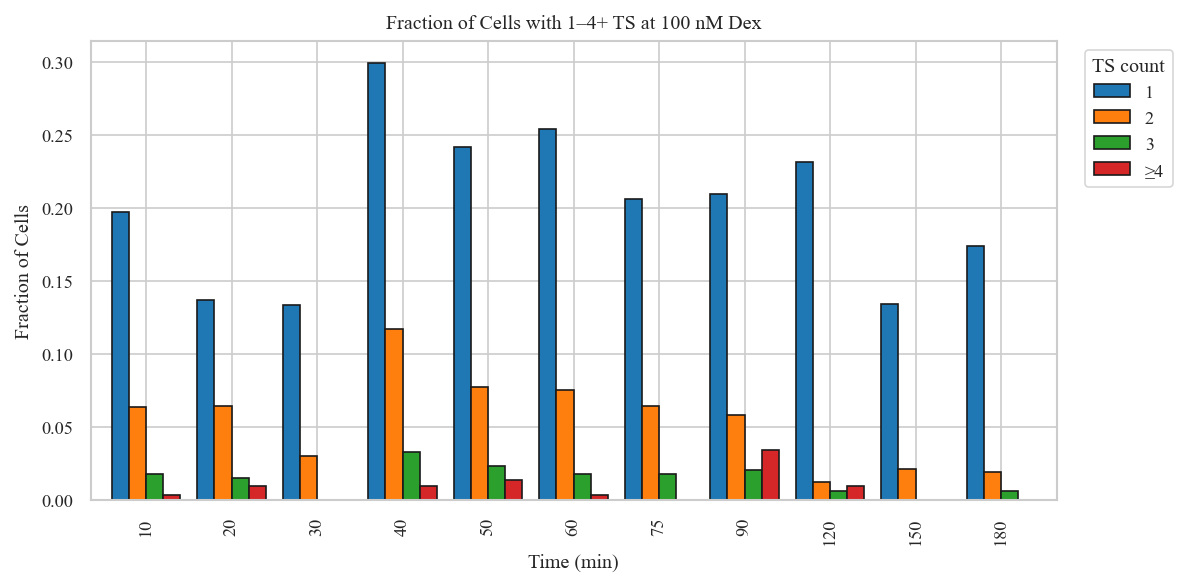

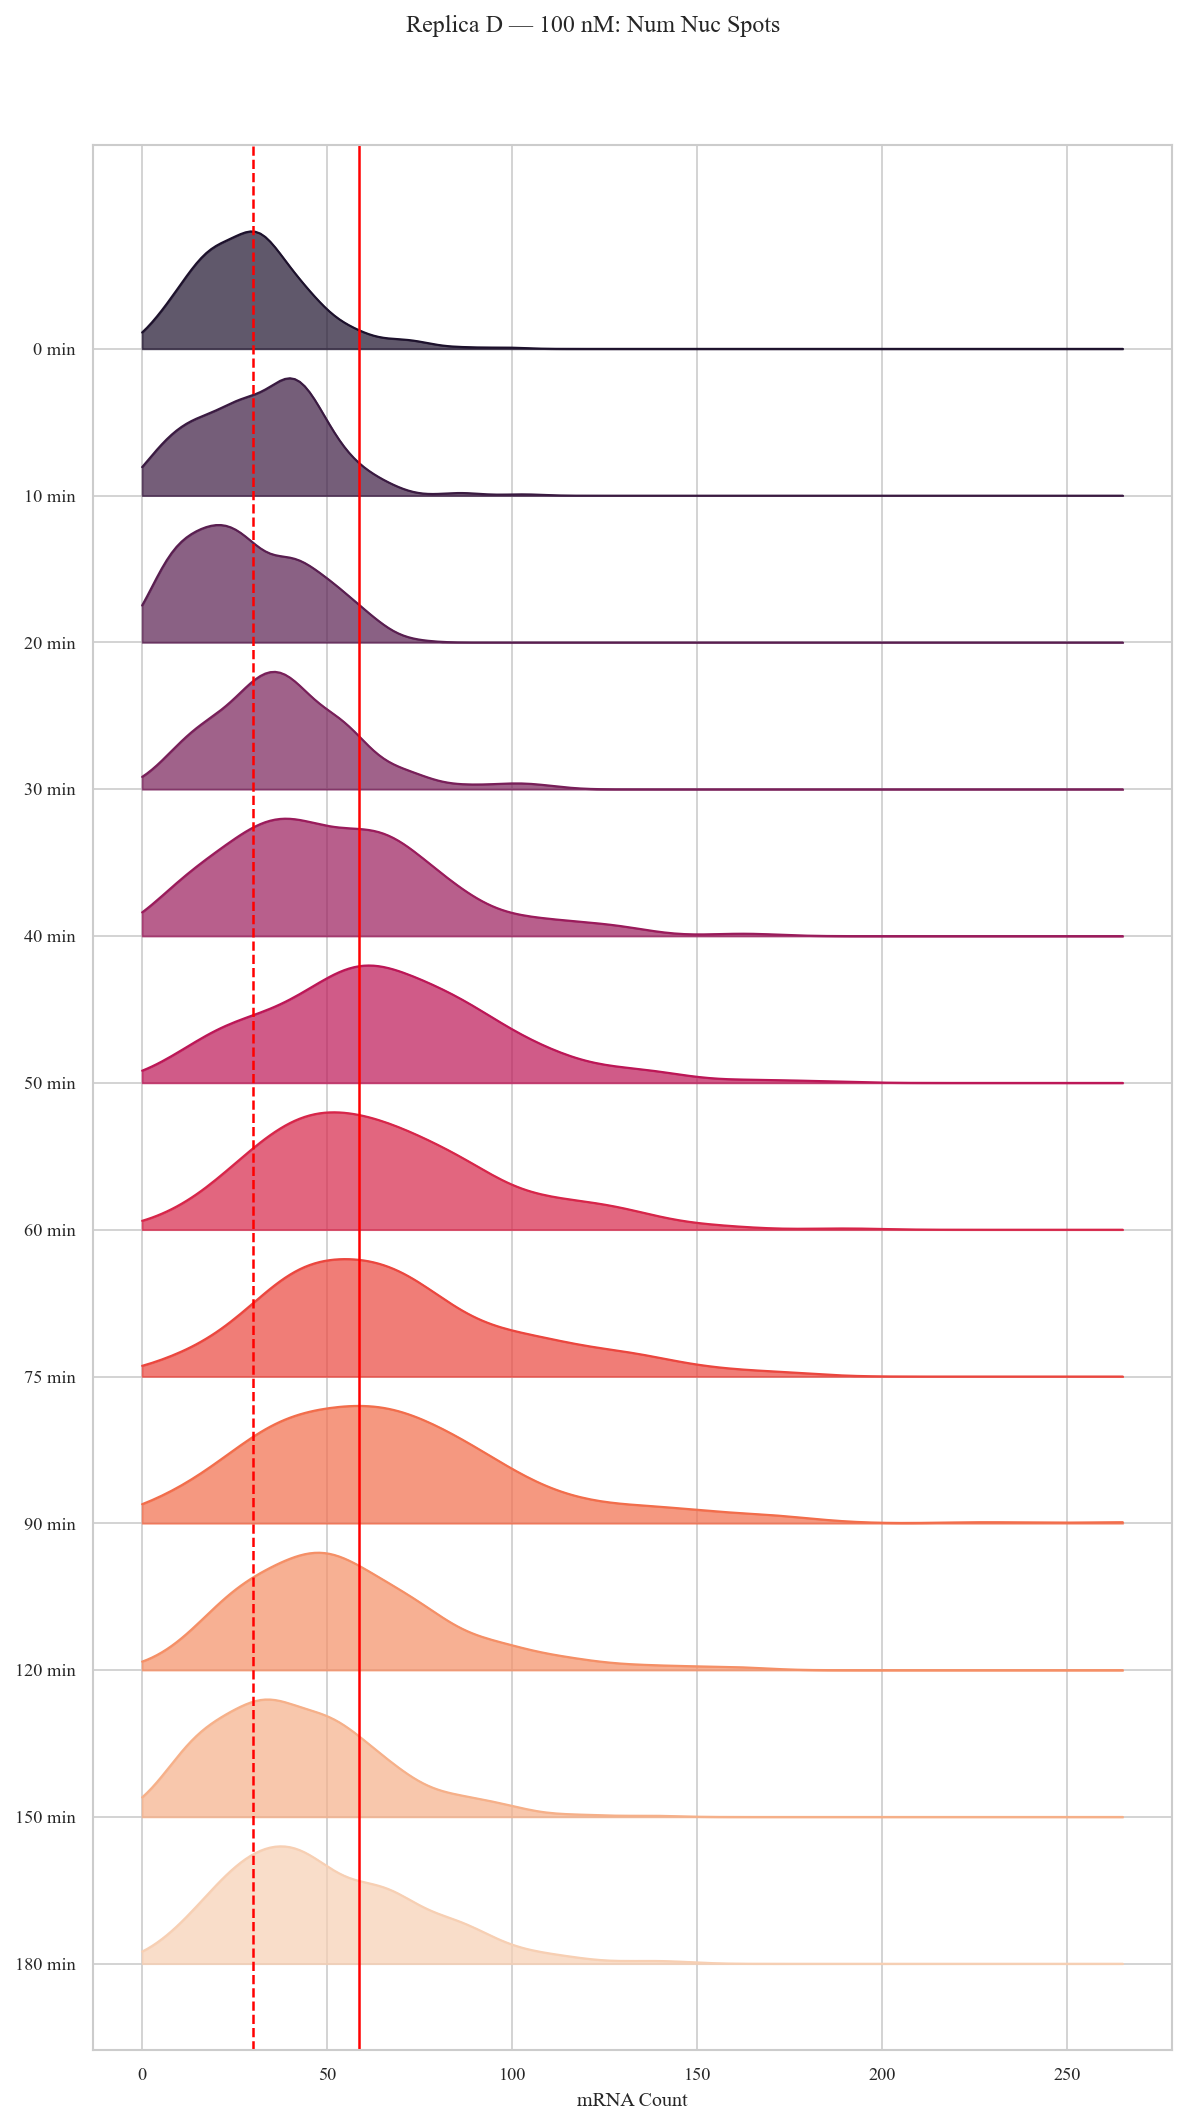

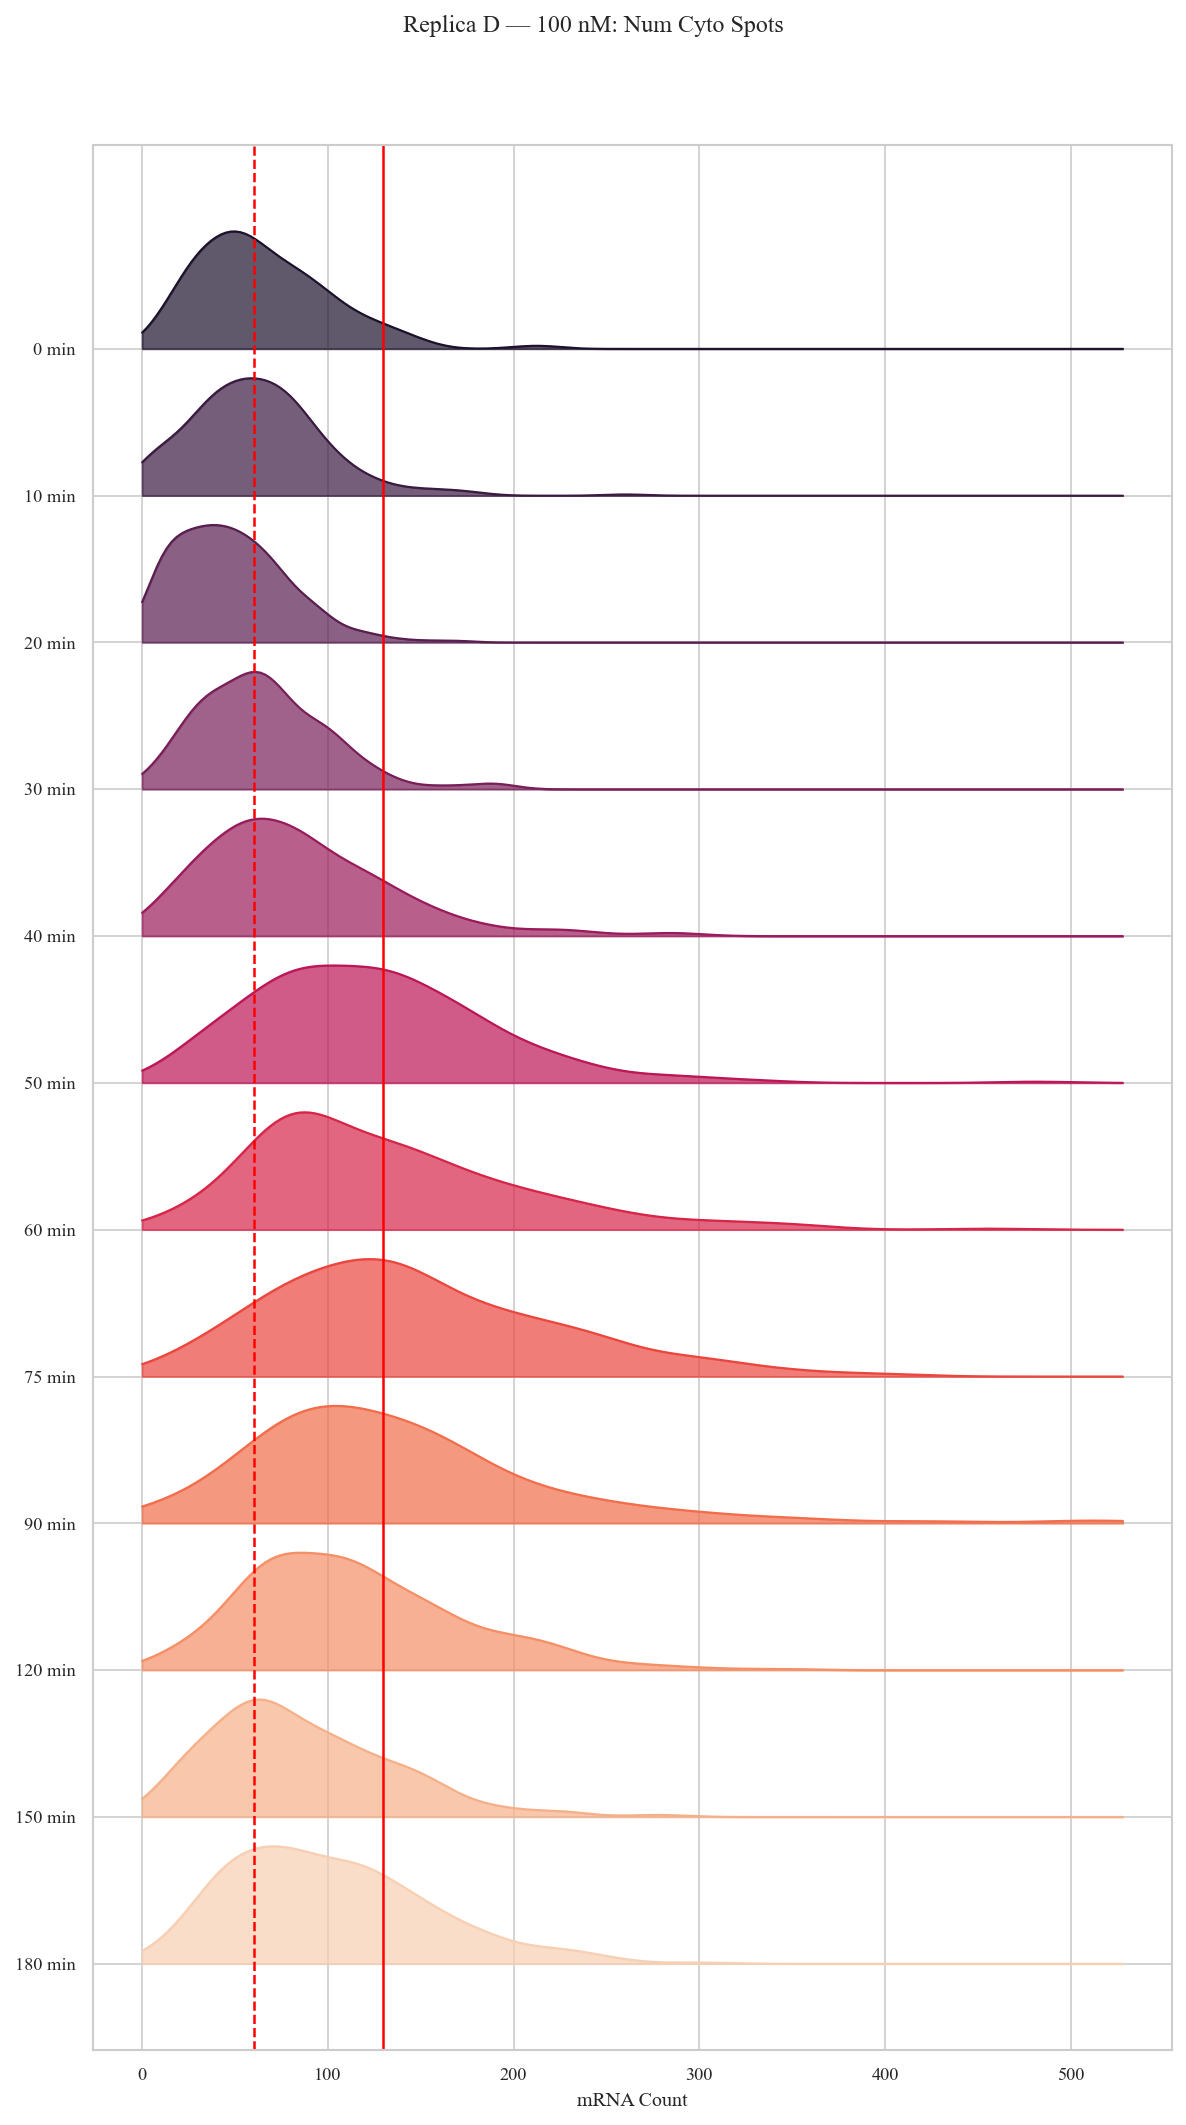

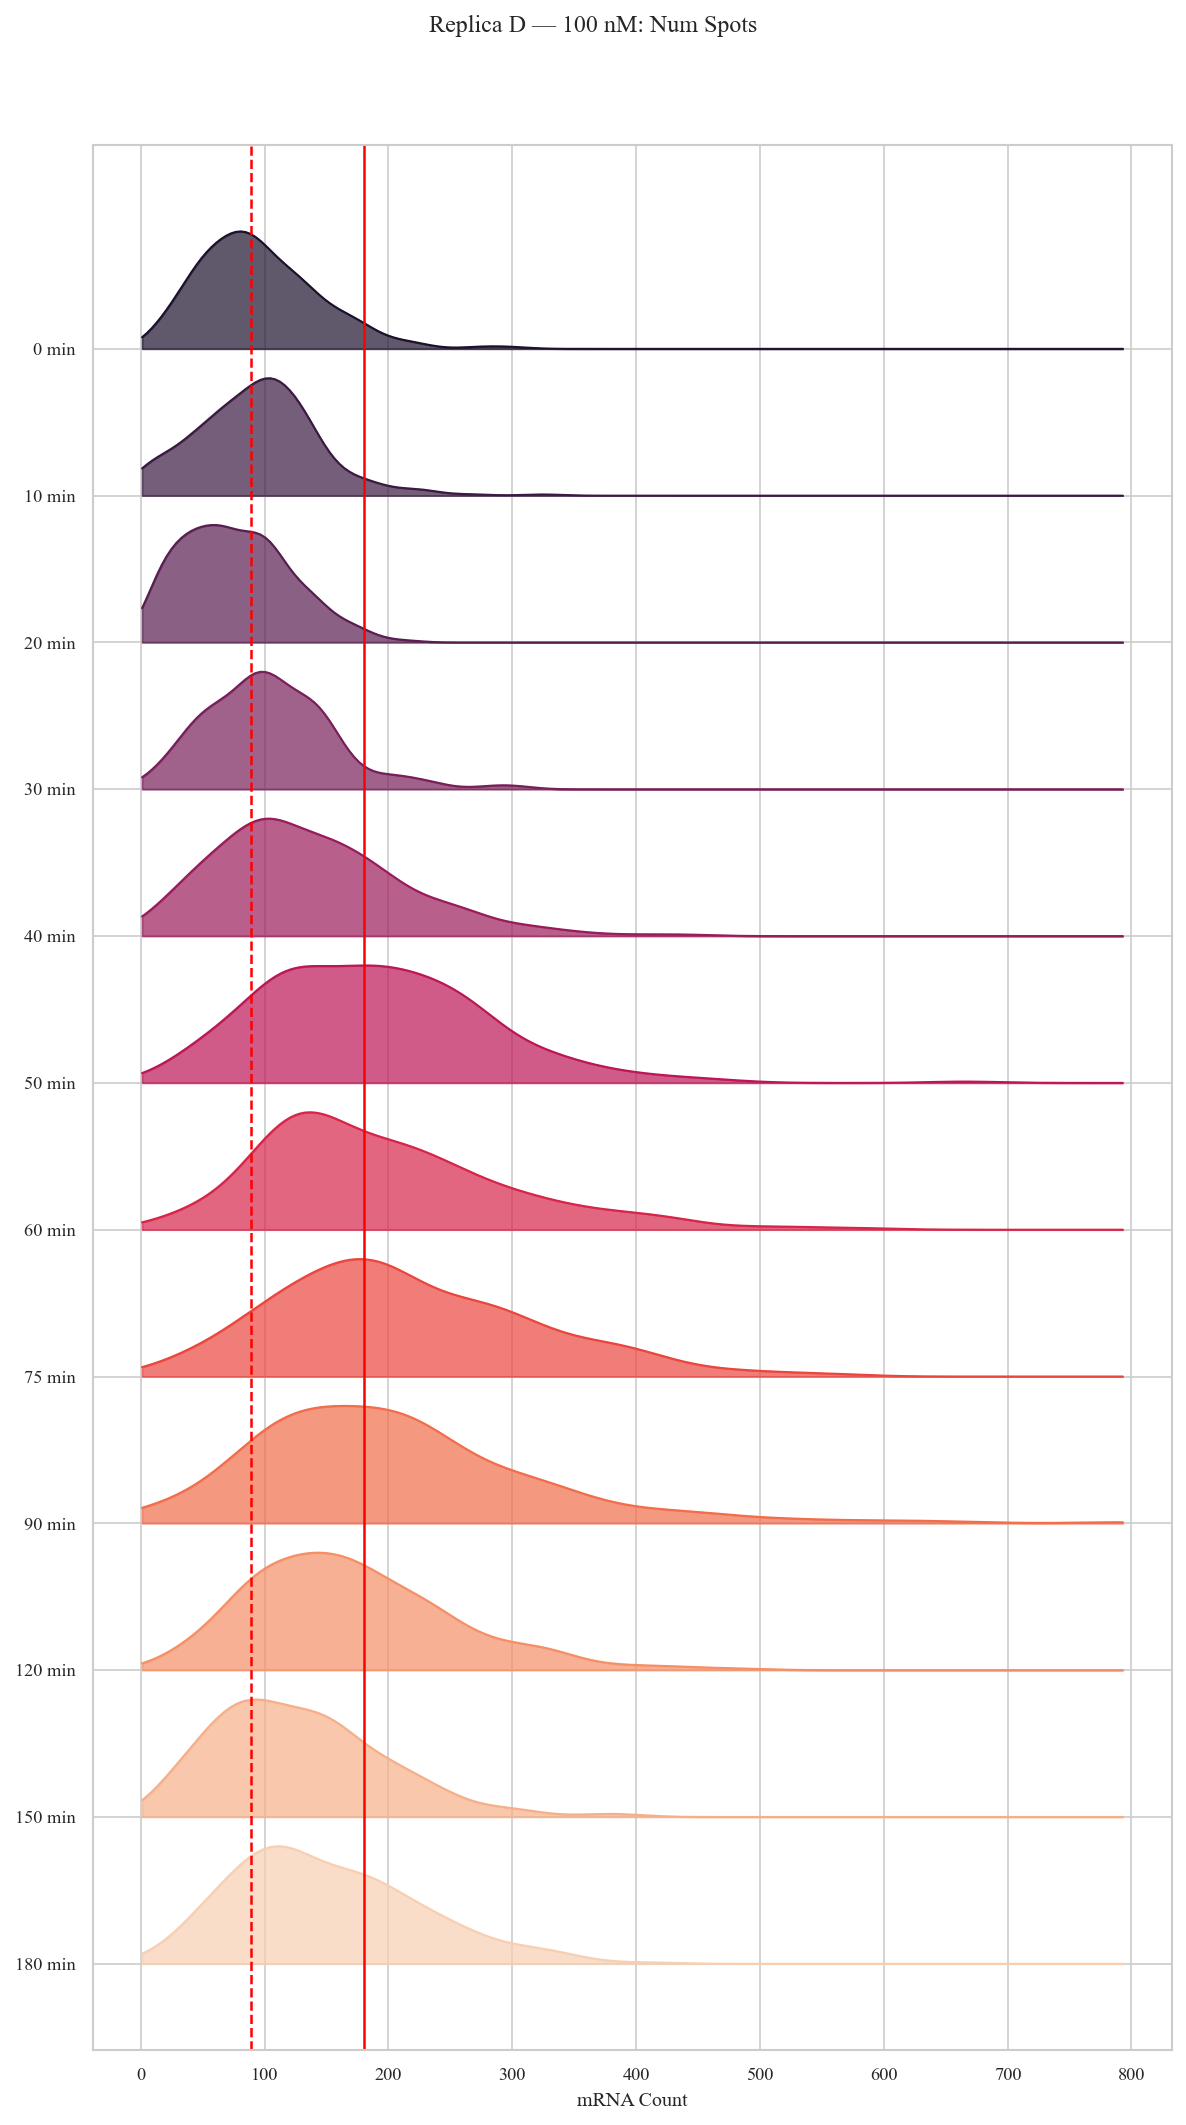

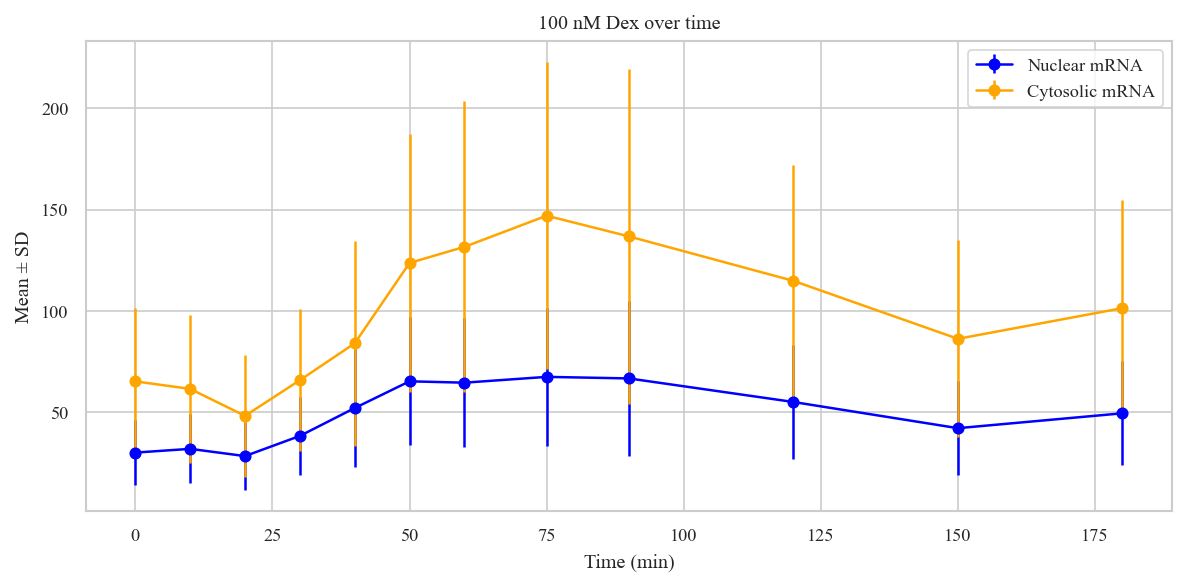

In [3]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_D_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '10' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 10
prefix = rep_prefix * (10 ** num_digits)  # e.g., if max_id = 30245 → prefix = 1000000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# (optional) Save the intermediate results
rep_string = 'DUSP1_D'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")


# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)
print(f"Filtering complete, saving results...")

# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica E 3hr 100nM time-sweep R2`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220421/DUSP1_100nM_Dex_R3_20220419_40min.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220421/DUSP1_100nM_Dex_R3_20220419_40min.h5 -> Analysis_DUSP1_E_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220425/DUSP1_100nM_Dex_R3_20220419_180min.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220425/DUSP1_100nM_Dex_R3_20220419_180min.h5 -> Analysis_DUSP1_E_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220421/DUSP1_100nM_Dex_R3_20220419_75min.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220421/DUSP1_100nM_Dex_R3_20220419_75min.h5 -> Analysis_DUSP1_E_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_0min.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_i

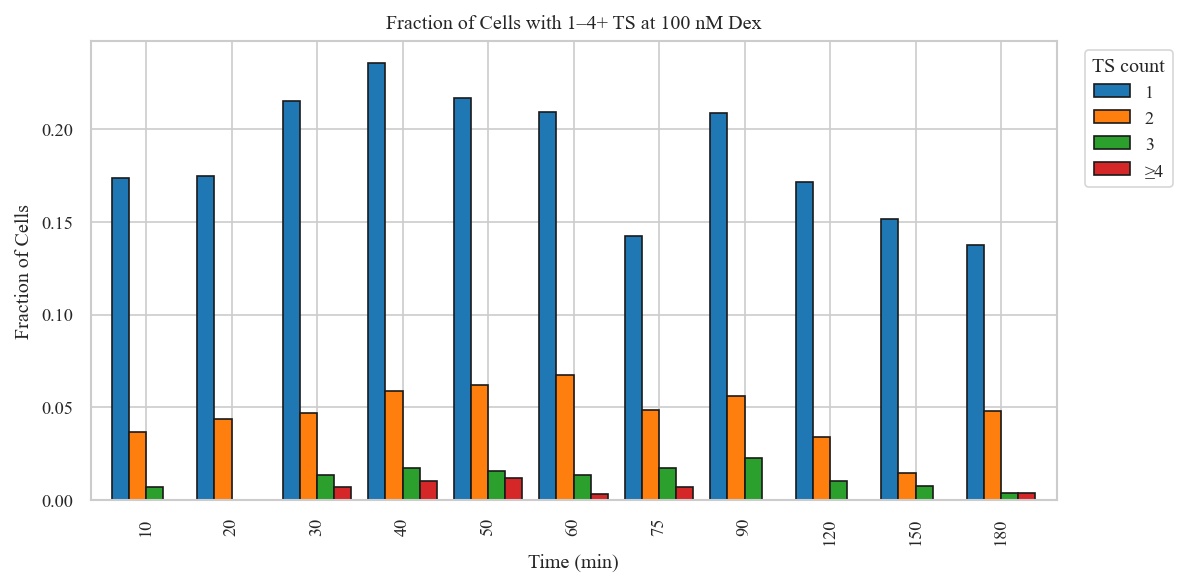

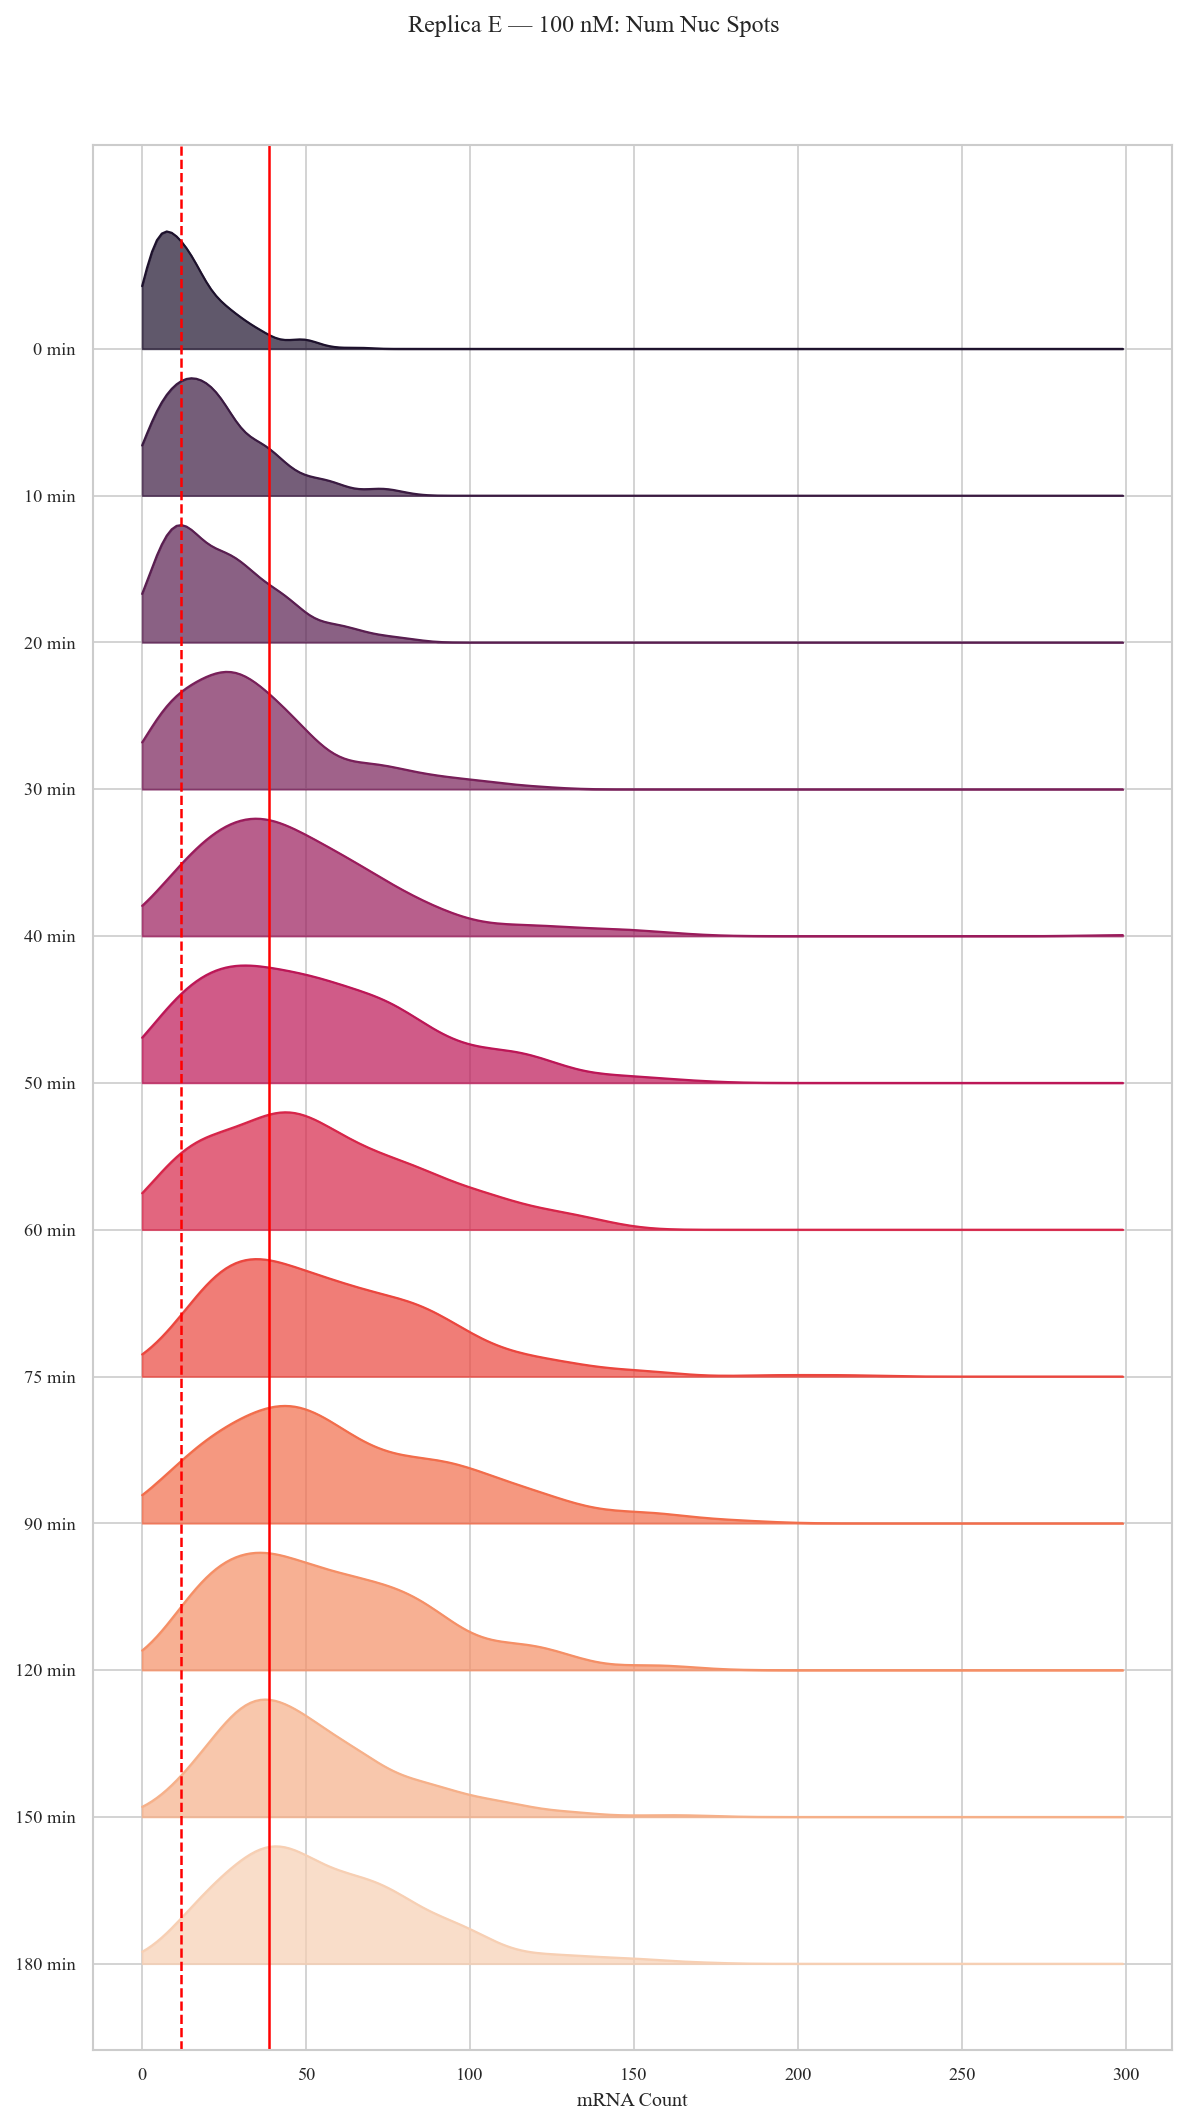

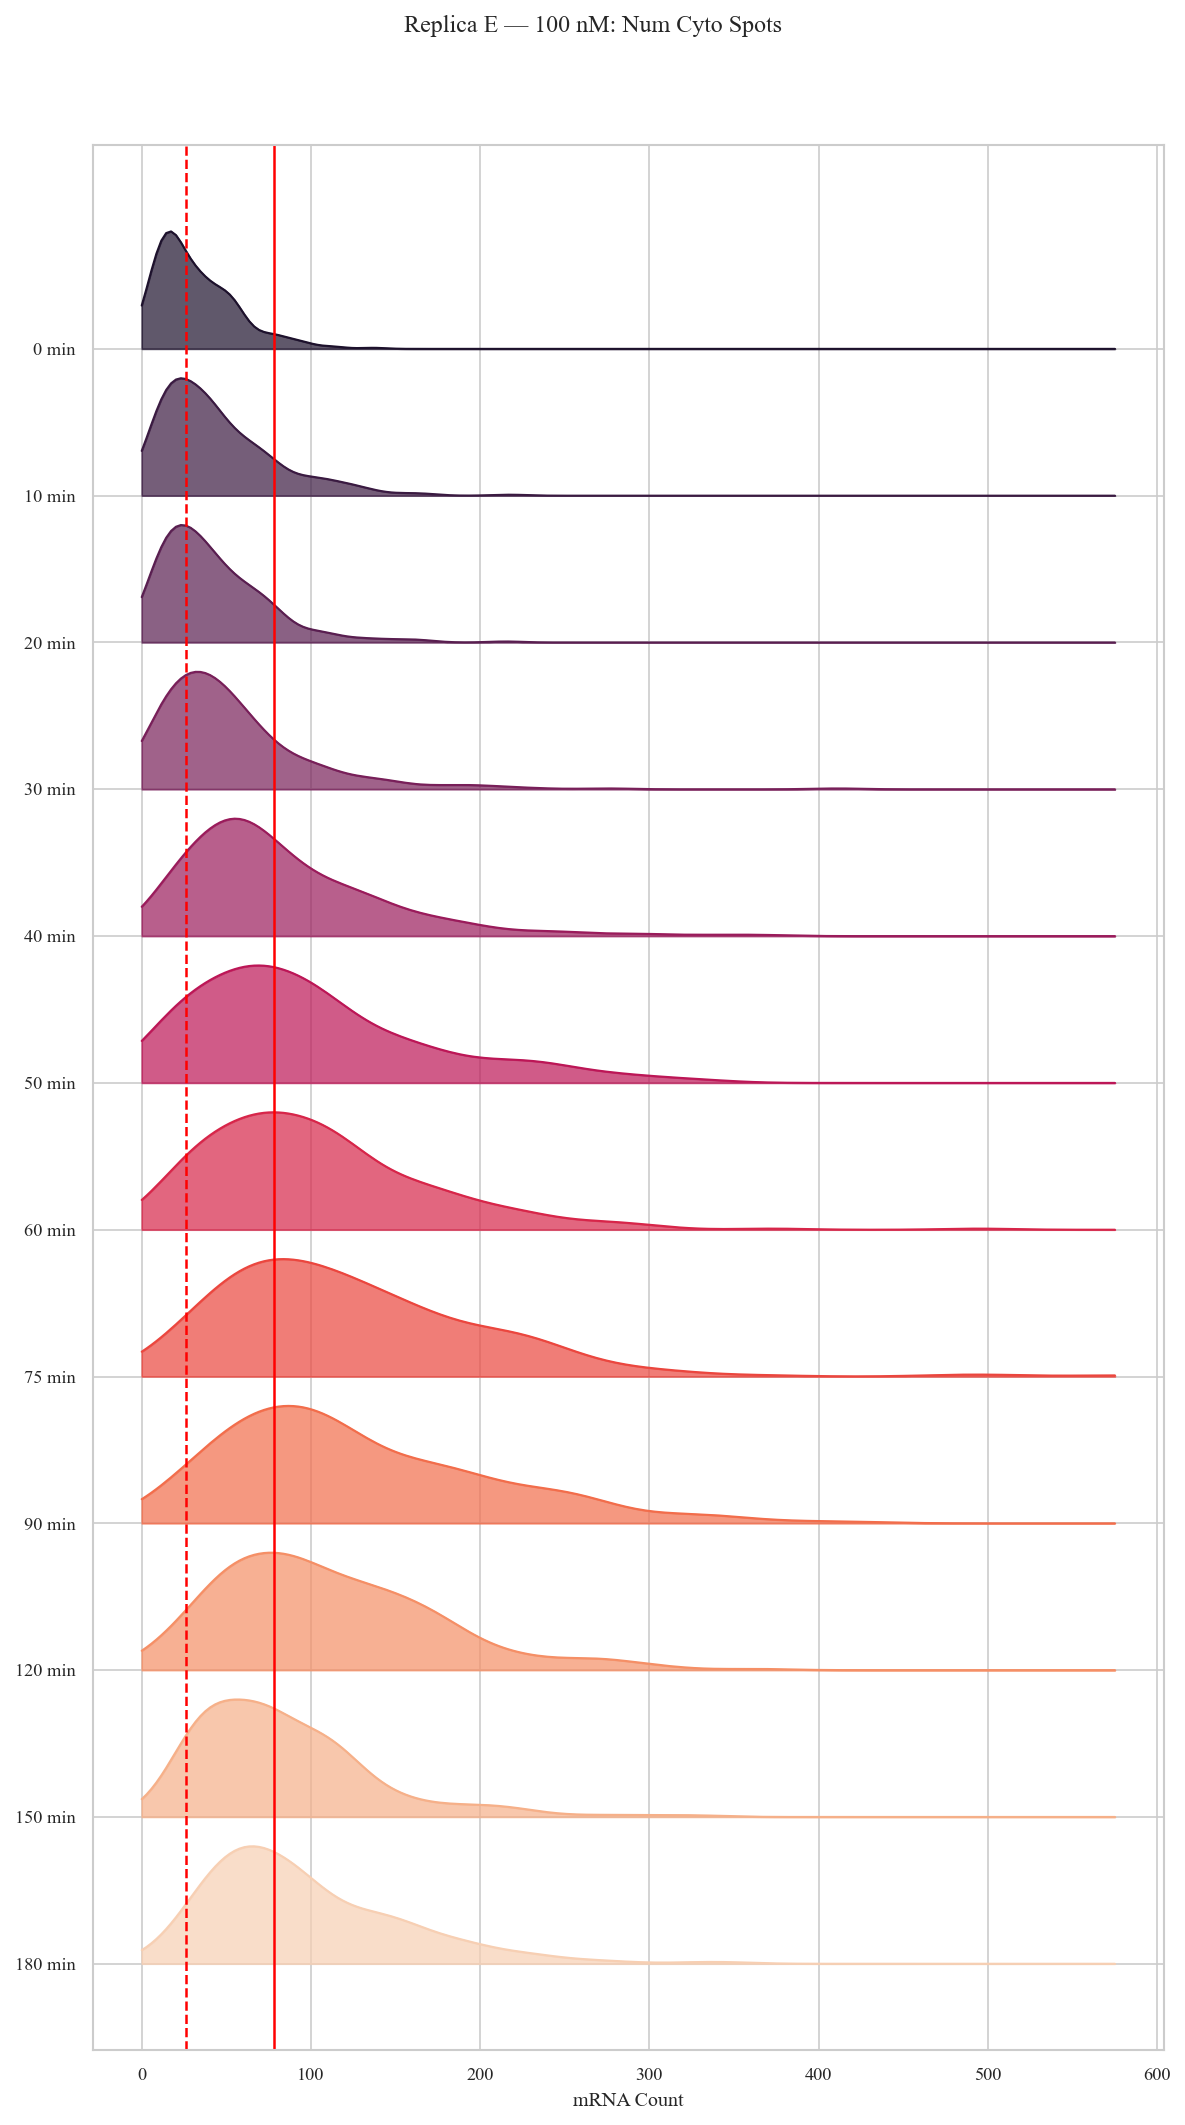

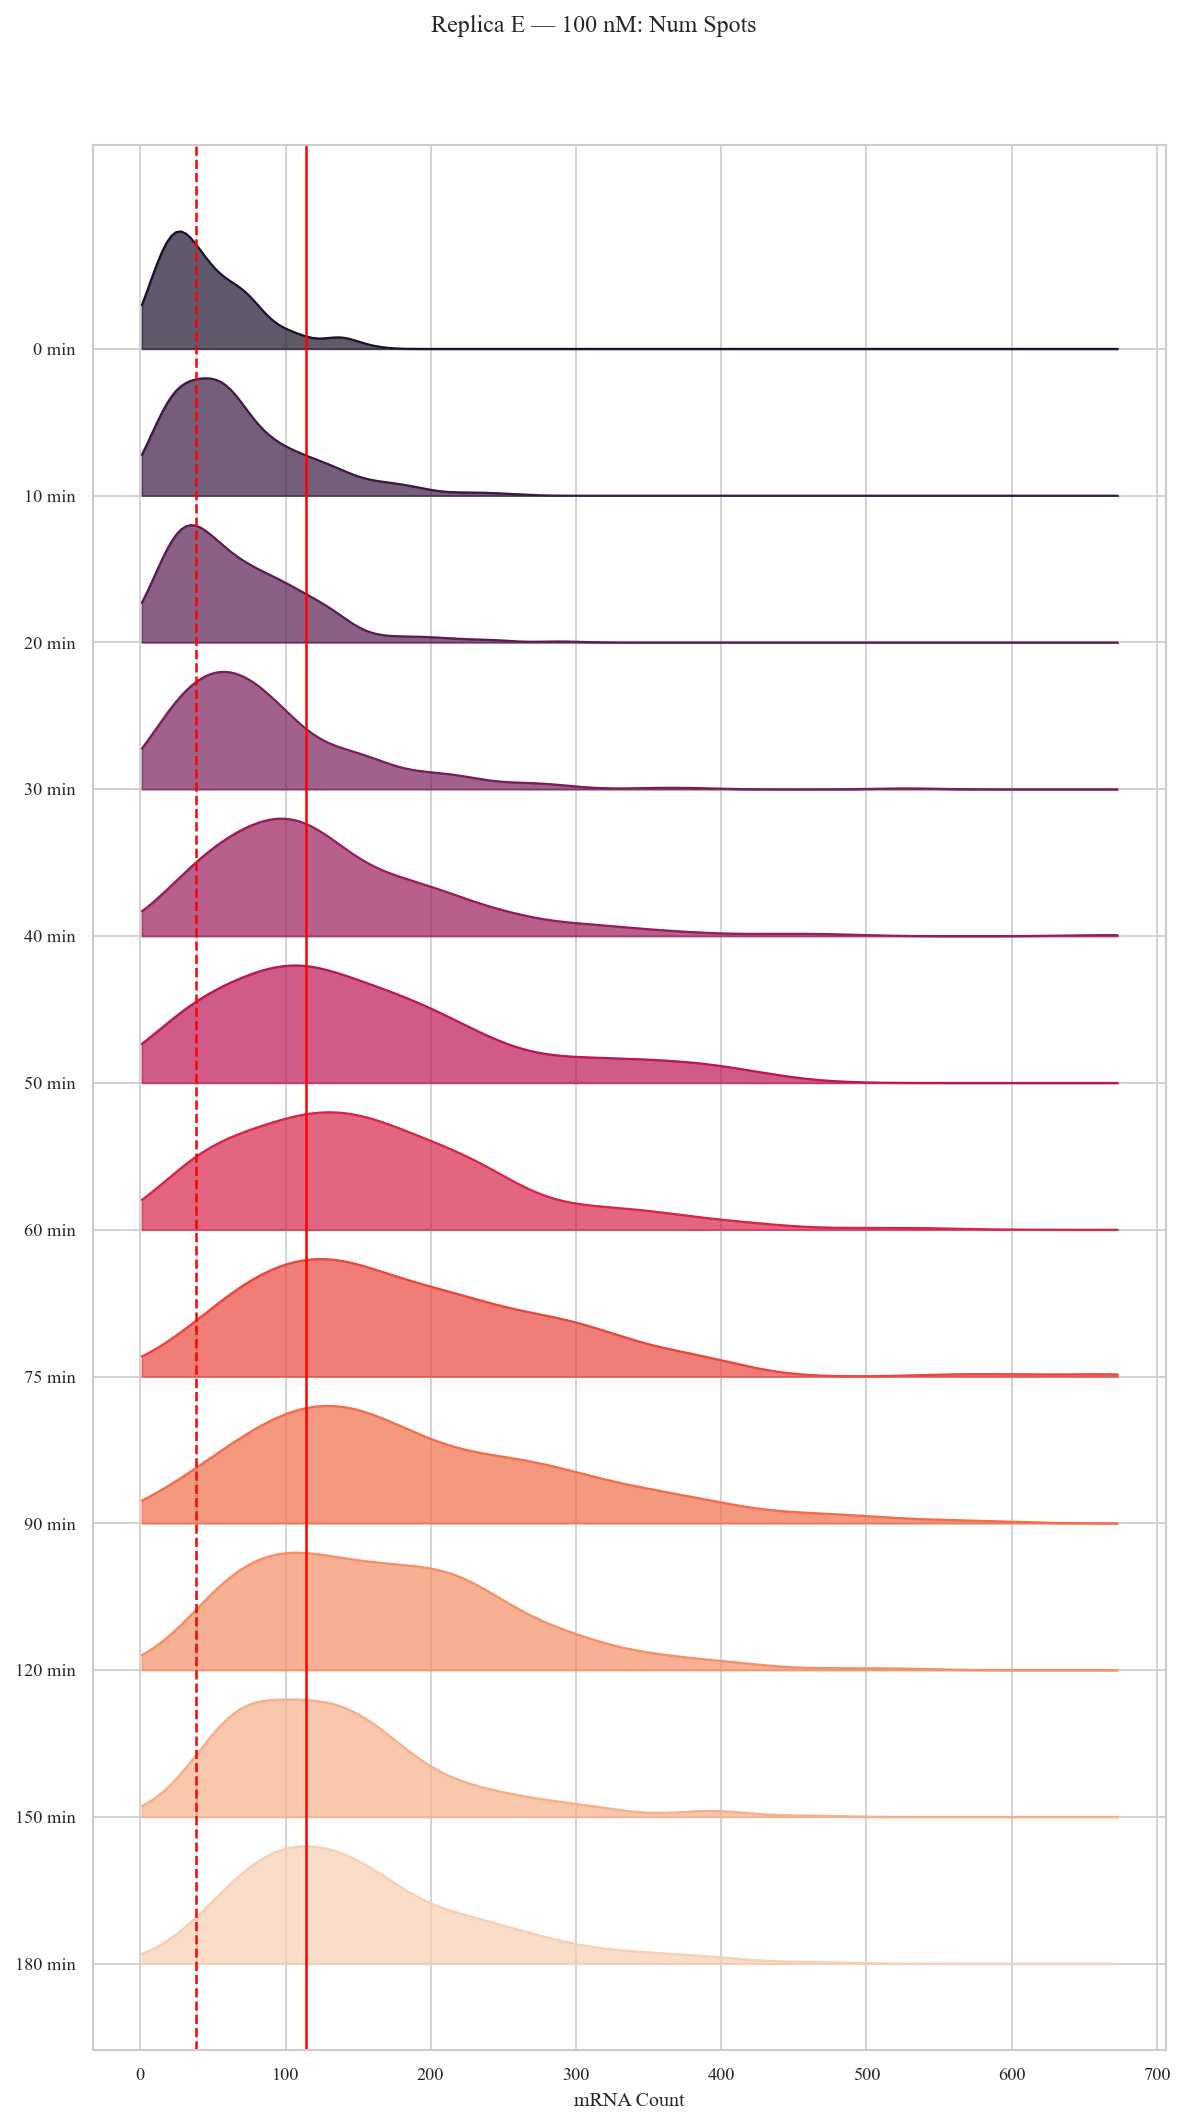

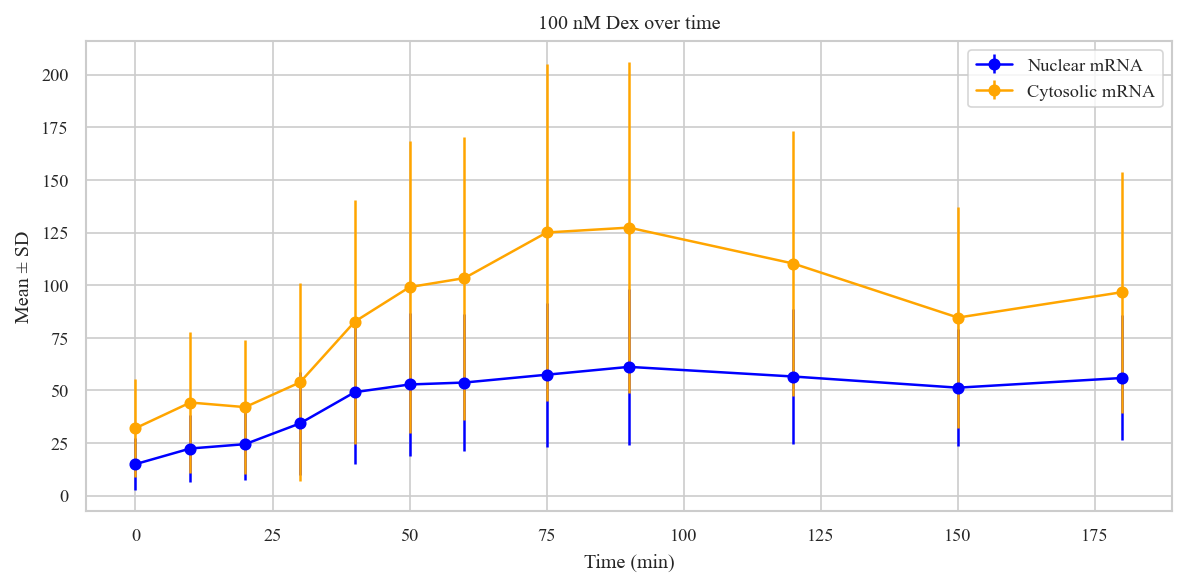

In [4]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_E_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")
print(f"Data loaded and moving to SNRAnalysis...")

# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()
print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")

# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '20' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 20
prefix = rep_prefix * (10 ** num_digits)  

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_E'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica F 3hr 100nM time-sweep R3`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_0min_NoSpin_052722.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_0min_NoSpin_052722.h5 -> Analysis_DUSP1_F_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220606/DUSP1_Dex_100nM_60min_NoSpin_052722.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220606/DUSP1_Dex_100nM_60min_NoSpin_052722.h5 -> Analysis_DUSP1_F_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_10min_NoSpin_052722.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_10min_NoSpin_052722.h5 -> Analysis_DUSP1_F_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220606/DUSP1_Dex_100nM_75min_NoSpin_052722.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Er

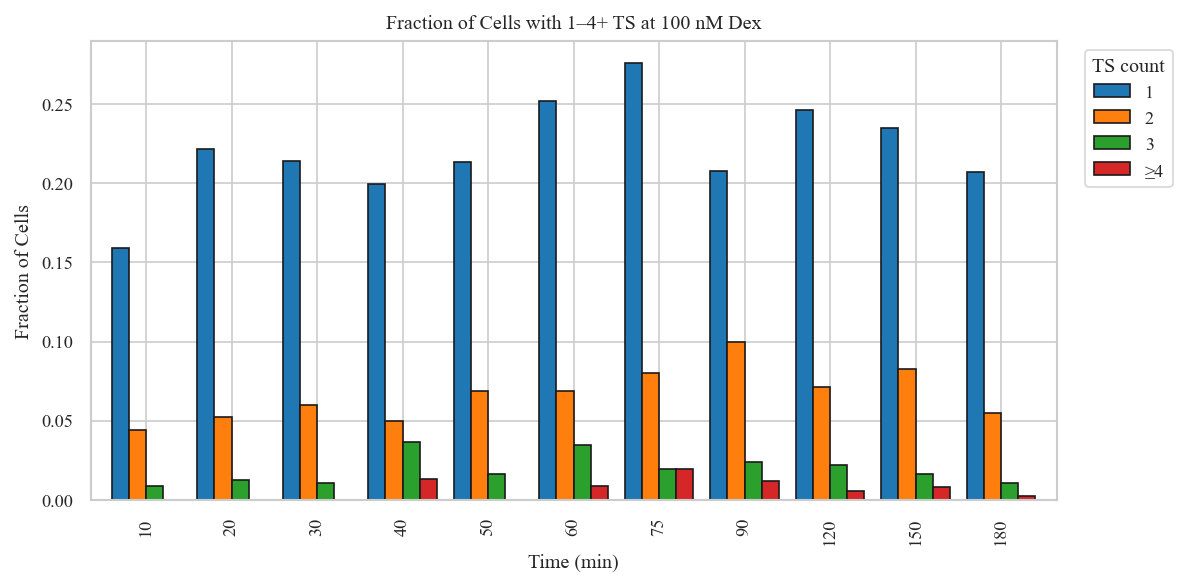

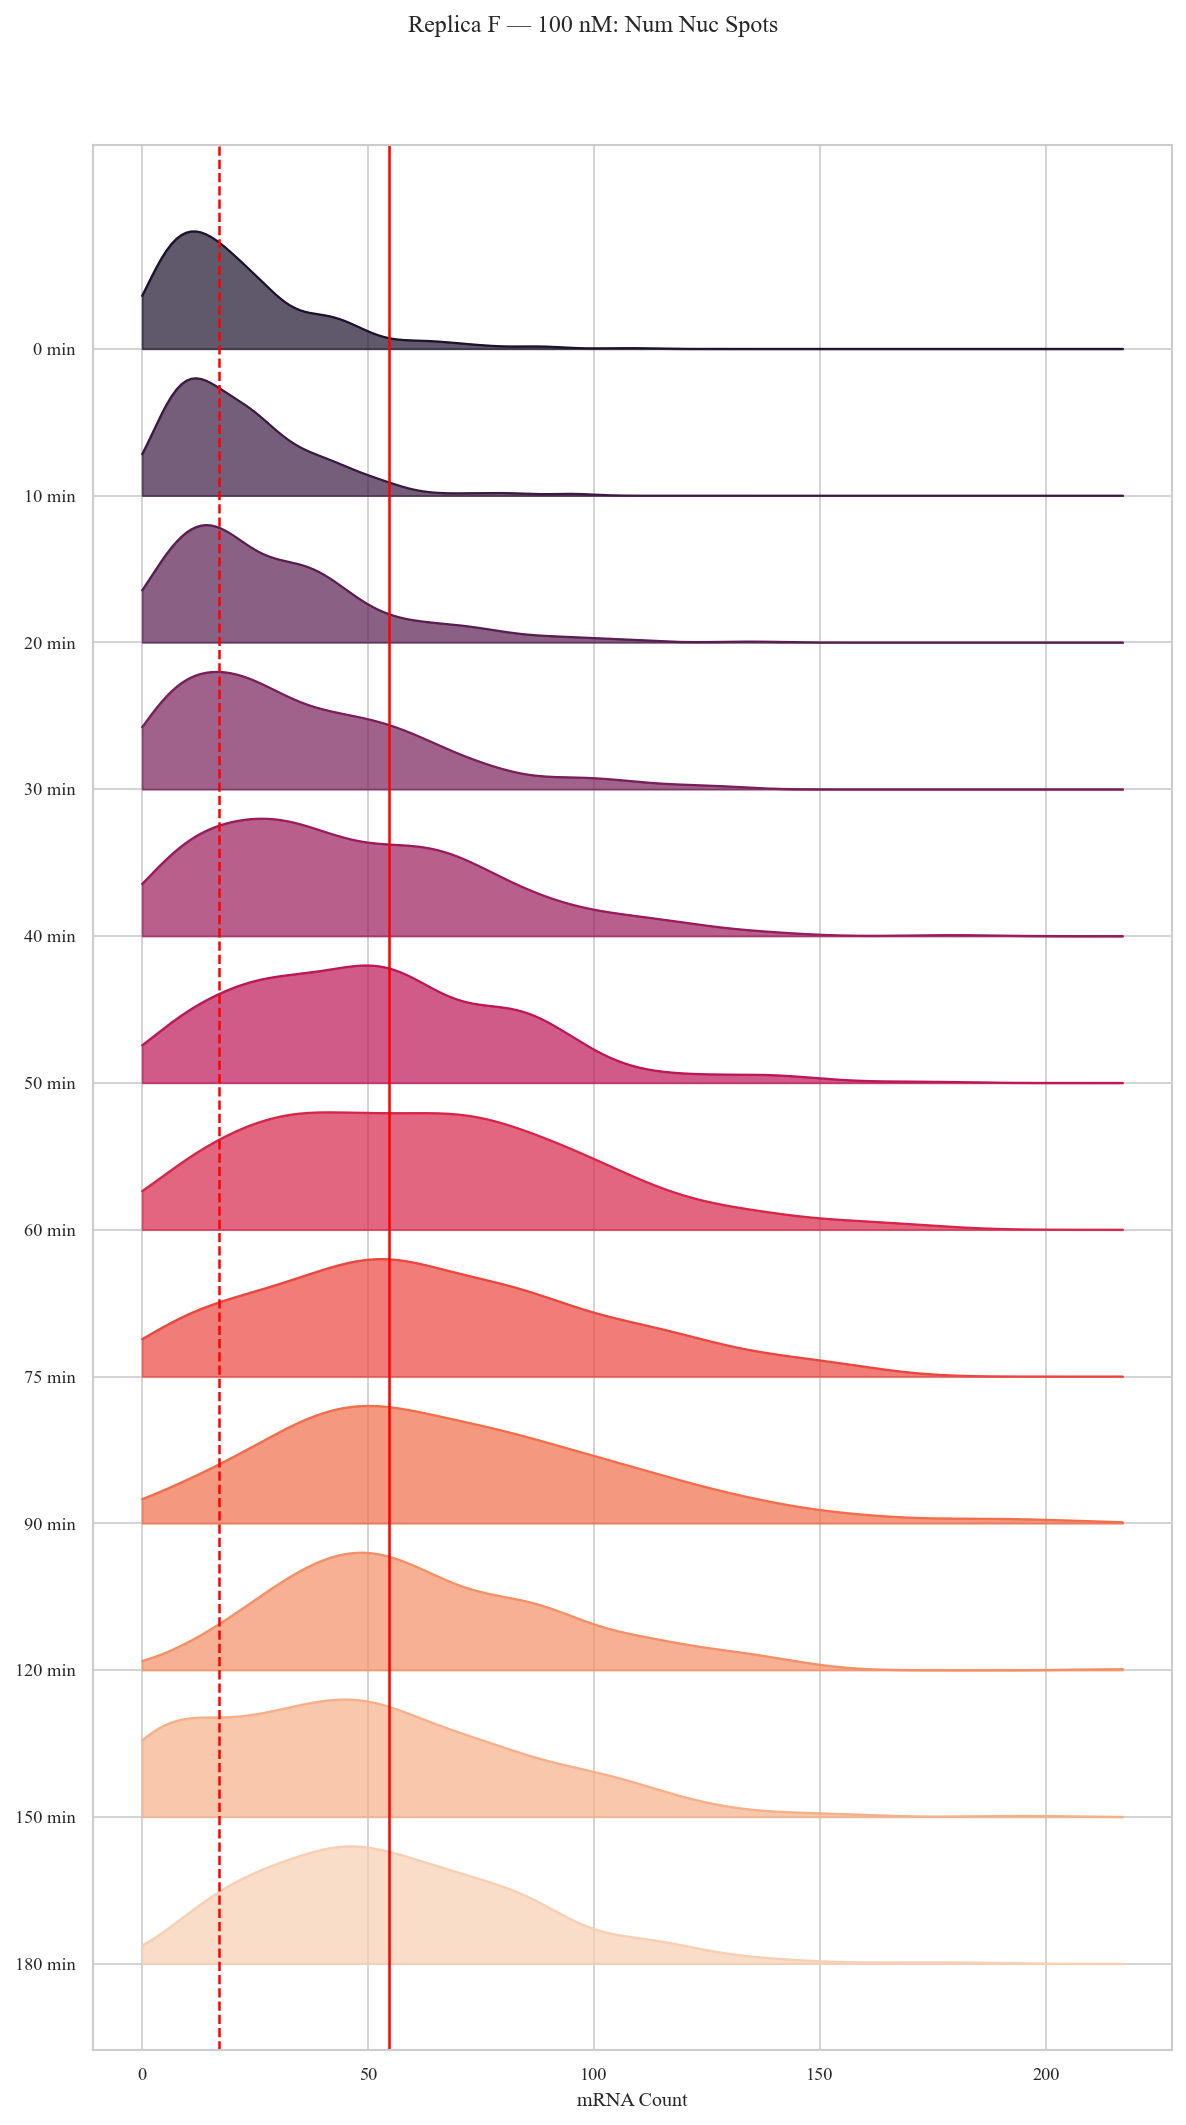

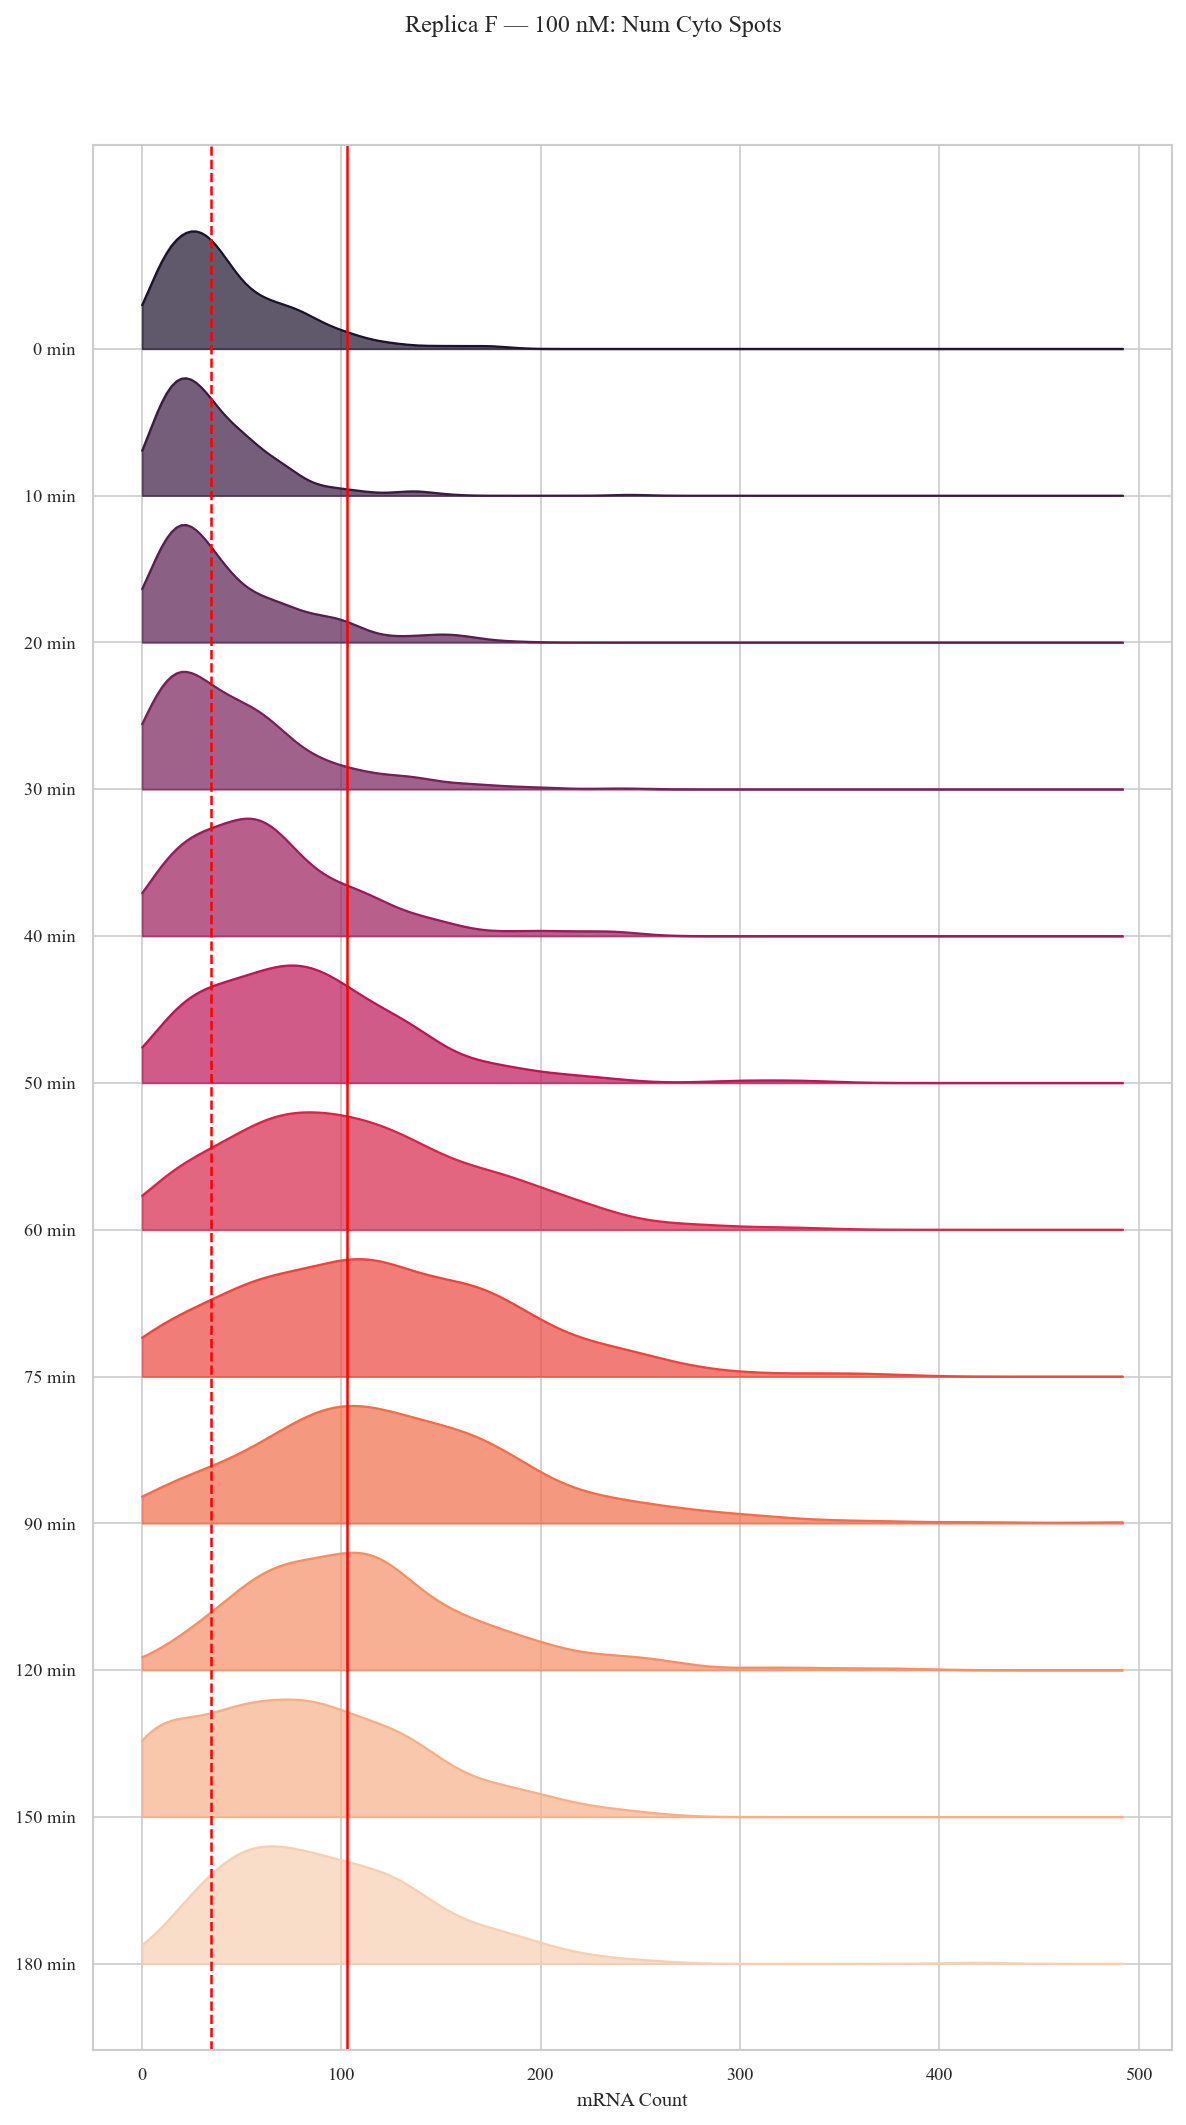

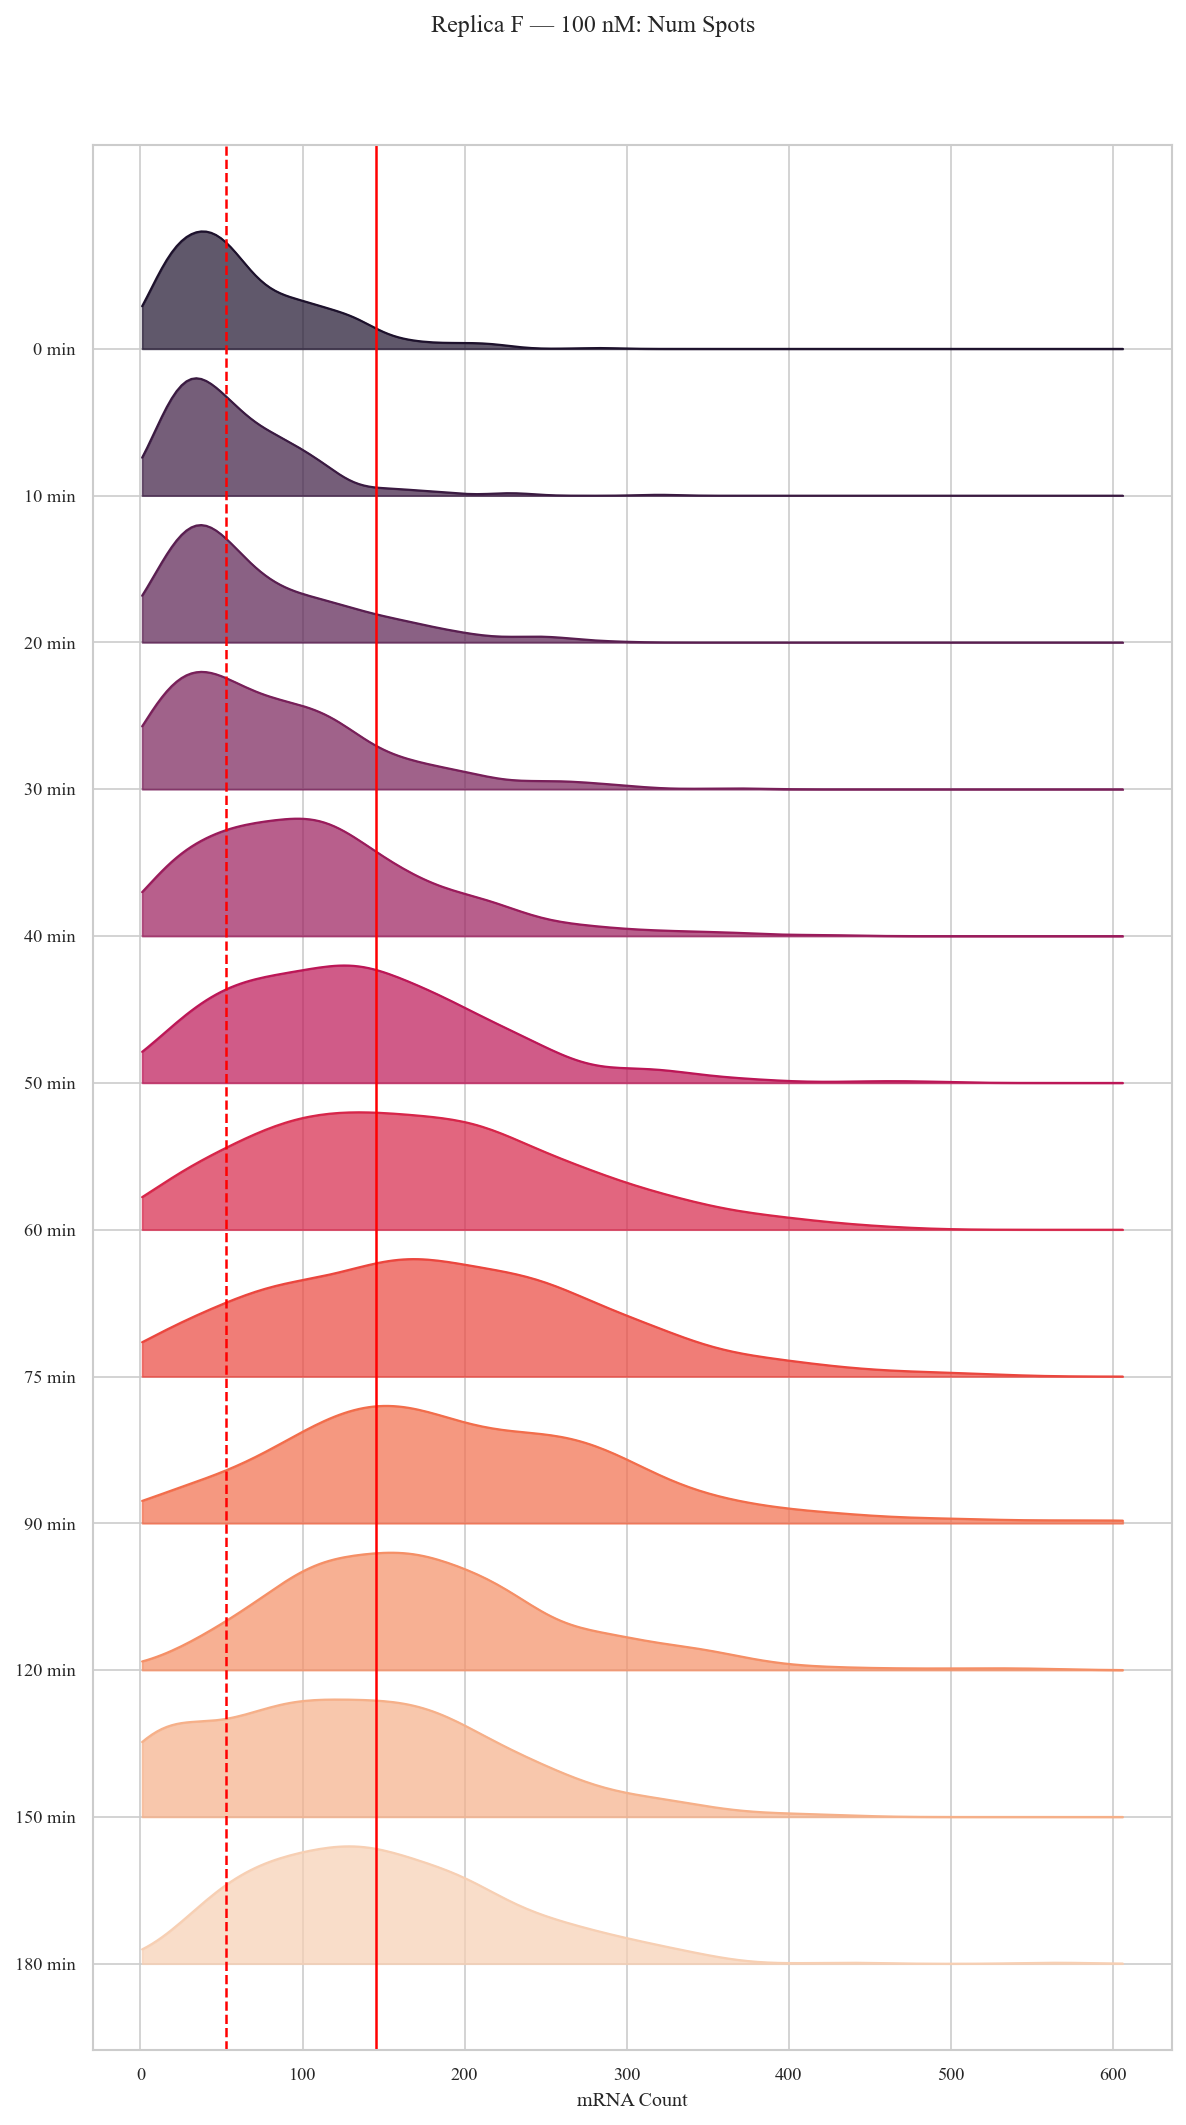

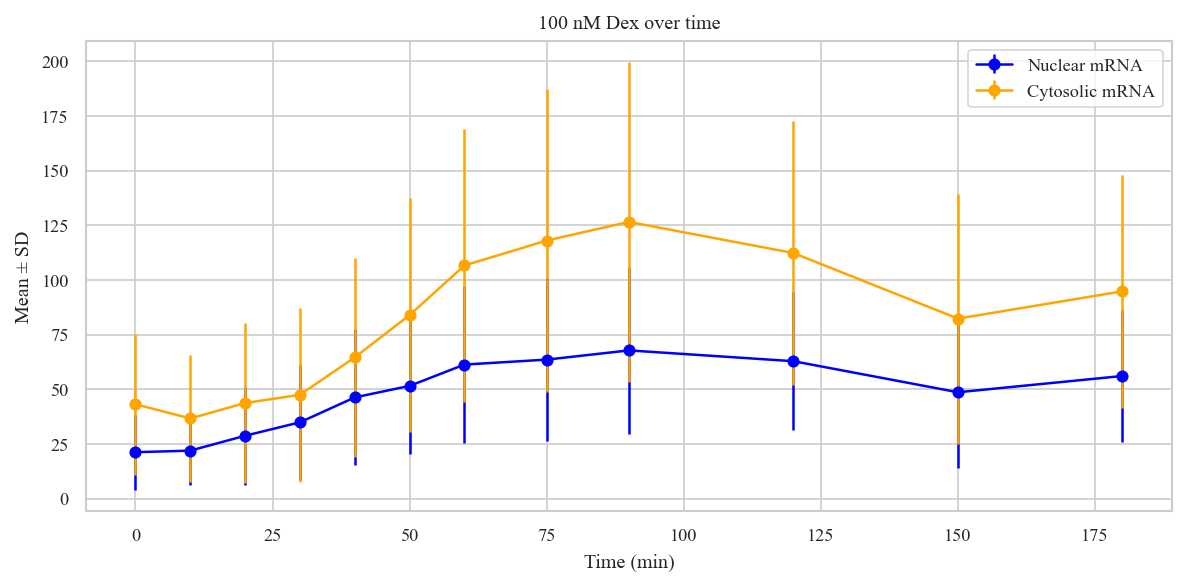

In [5]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_F_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '30' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 30
prefix = rep_prefix * (10 ** num_digits)  

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_F'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica M 3hr 100nM time-sweep Partial Replica`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_150min_072022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_150min_072022.h5 -> Analysis_DUSP1_M_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_0min_072022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_0min_072022.h5 -> Analysis_DUSP1_M_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_180min_072022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_180min_072022.h5 -> Analysis_DUSP1_M_Final_2025-03-05/spotresults
Successfully loaded 3 DataFrames. Merging...
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_150min_072022.h5
Reading DataFrame from: /V

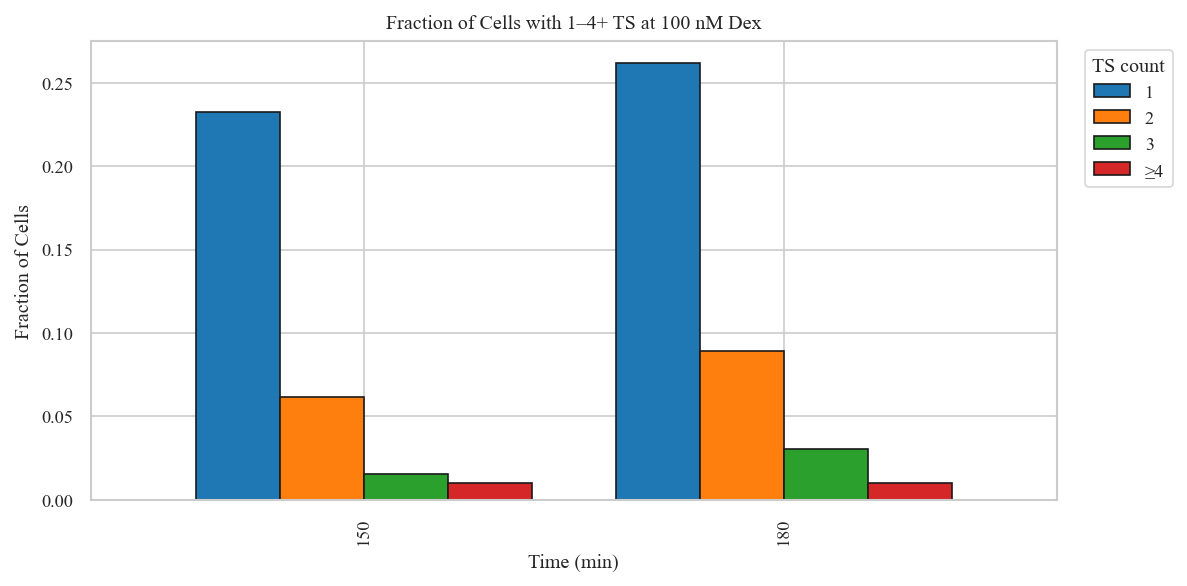

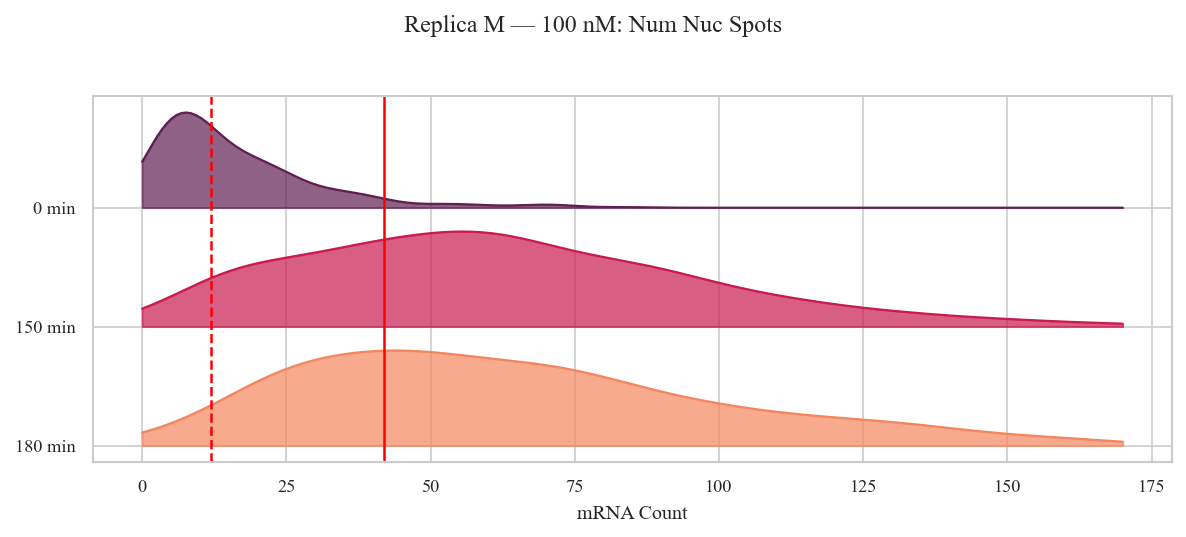

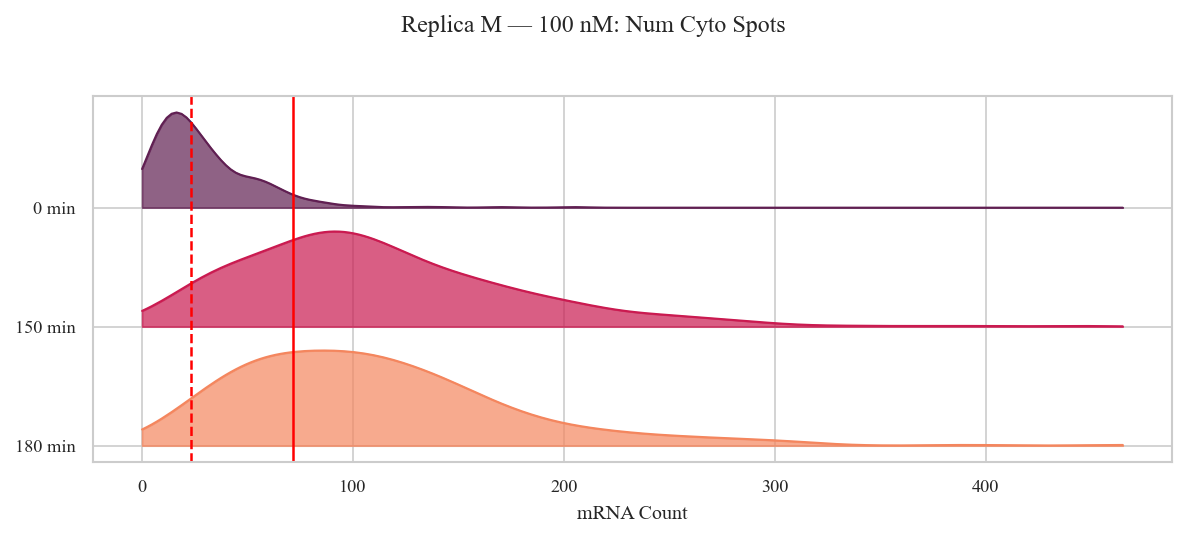

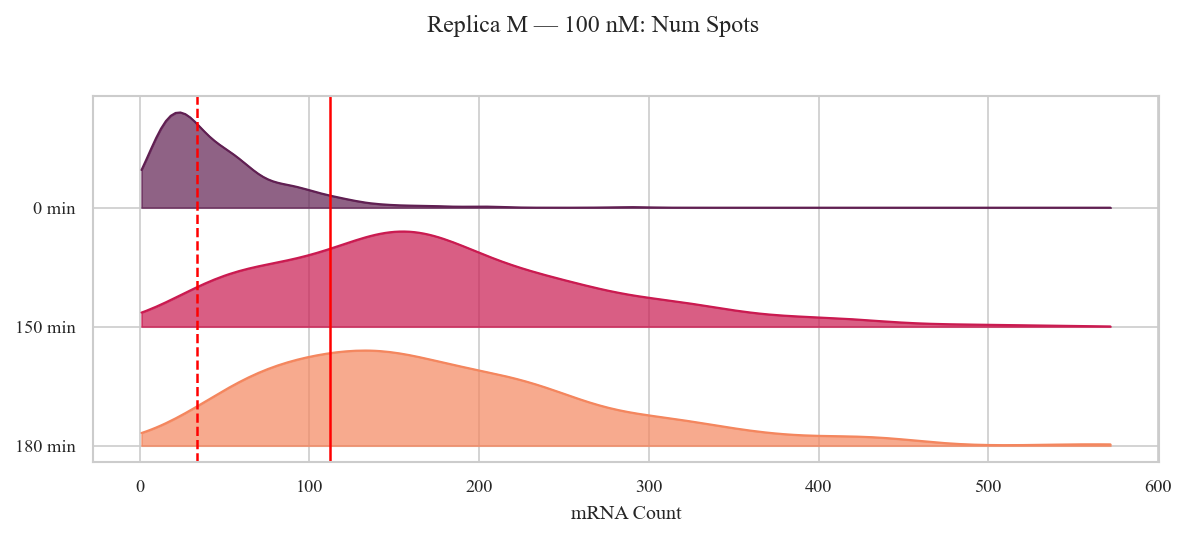

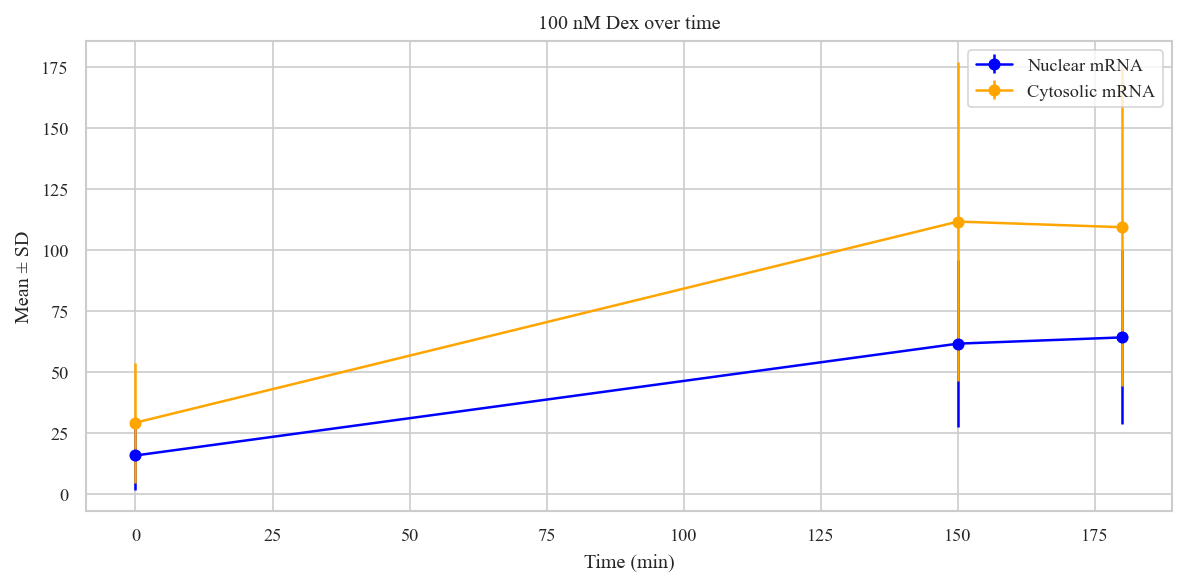

In [6]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_M_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '40' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 40
prefix = rep_prefix * (10 ** num_digits)  

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_M'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica N 3hr 100nM time-sweep Partial Replica`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_60min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_60min_081822.h5 -> Analysis_DUSP1_N_Final2_2025-03-06/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220929/DUSP1_100nM_Dex_180min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220929/DUSP1_100nM_Dex_180min_081822.h5 -> Analysis_DUSP1_N_Final2_2025-03-06/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_30min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_30min_081822.h5 -> Analysis_DUSP1_N_Final2_2025-03-06/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220928/DUSP1_100nM_Dex_150min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220928/DUSP1_100nM_Dex

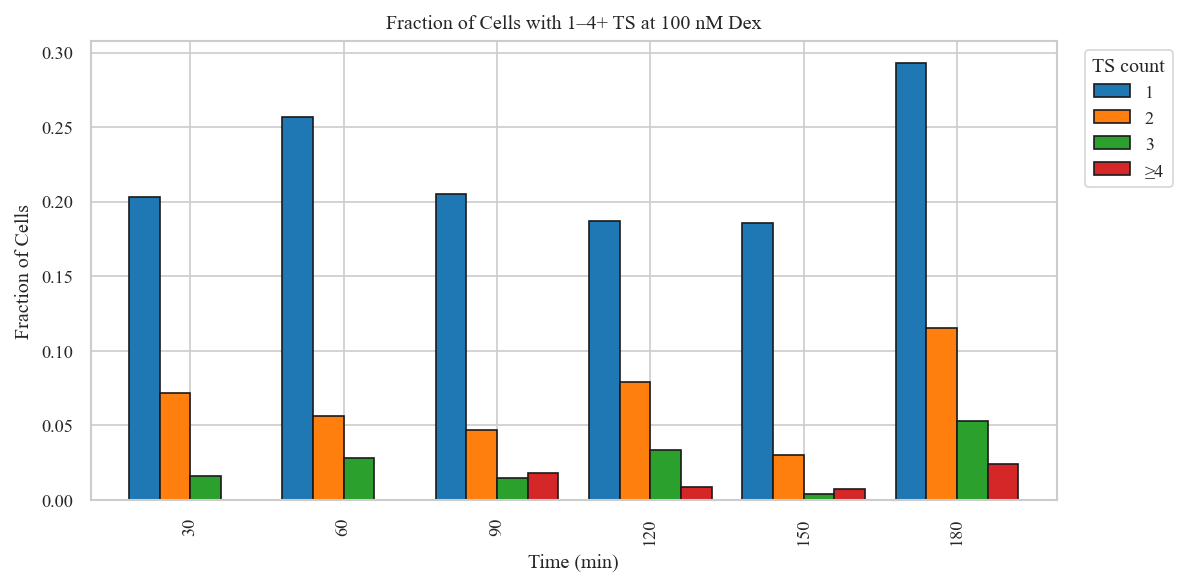

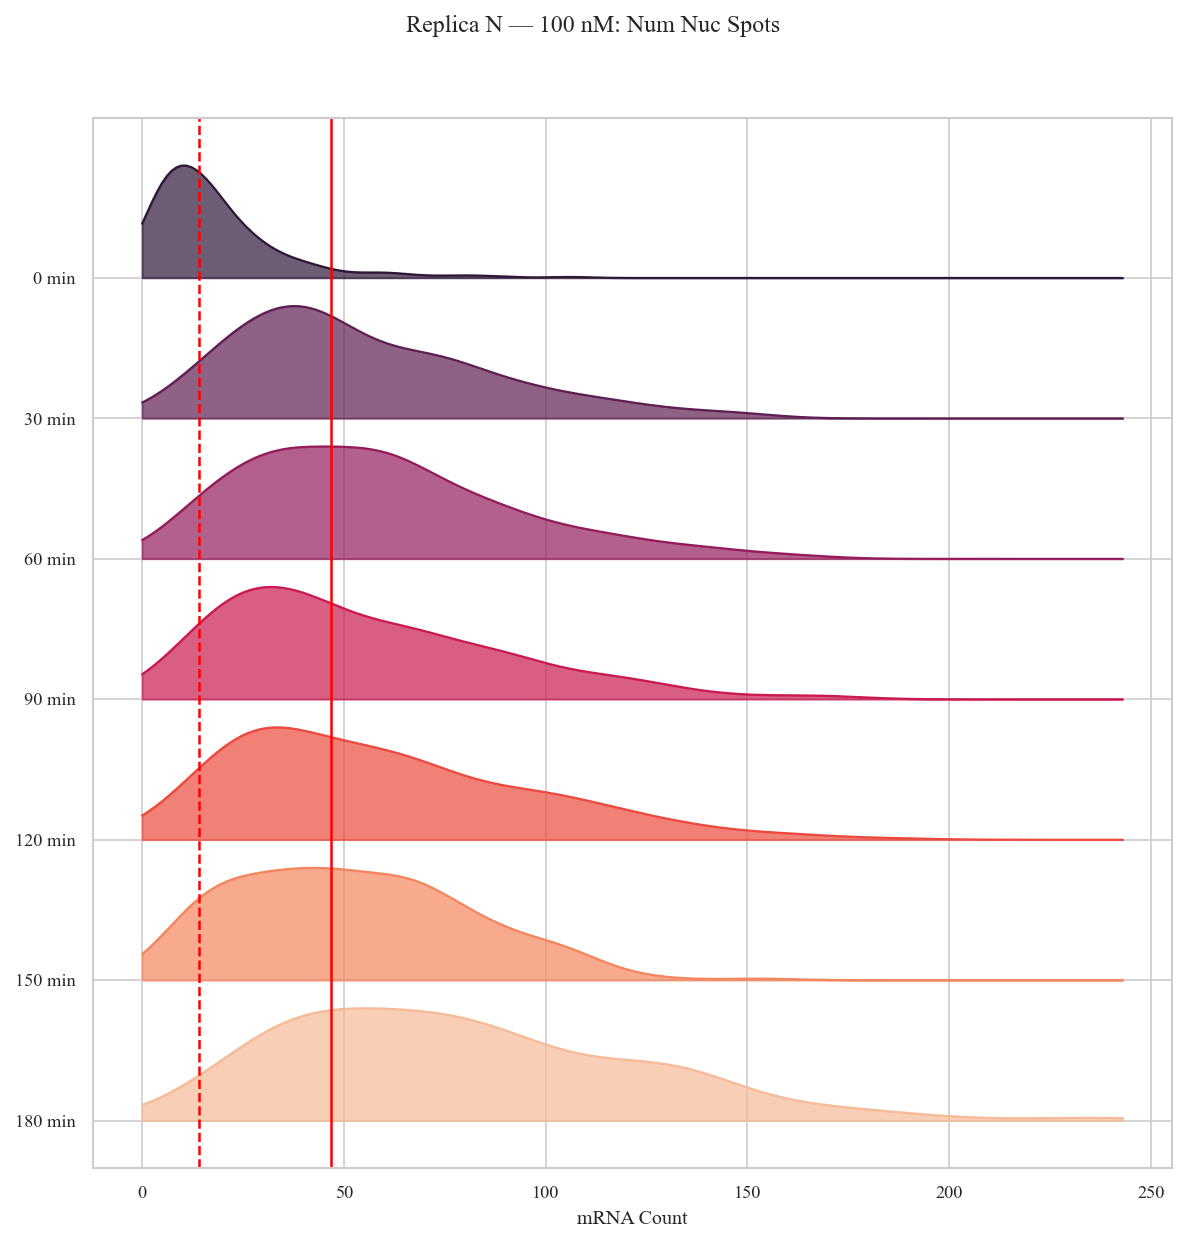

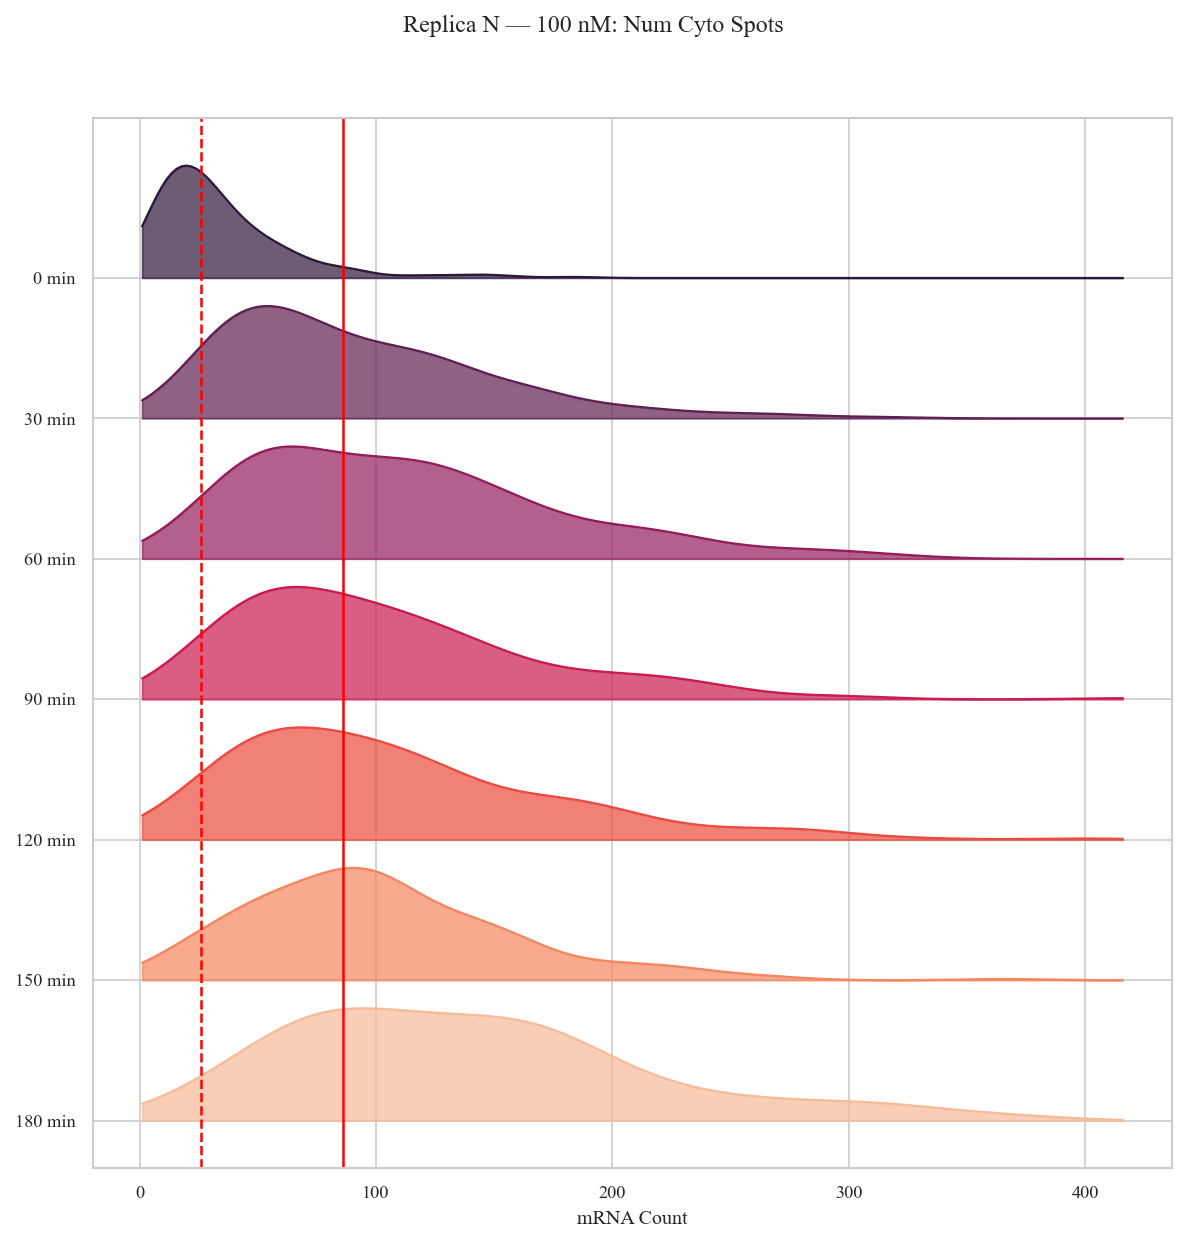

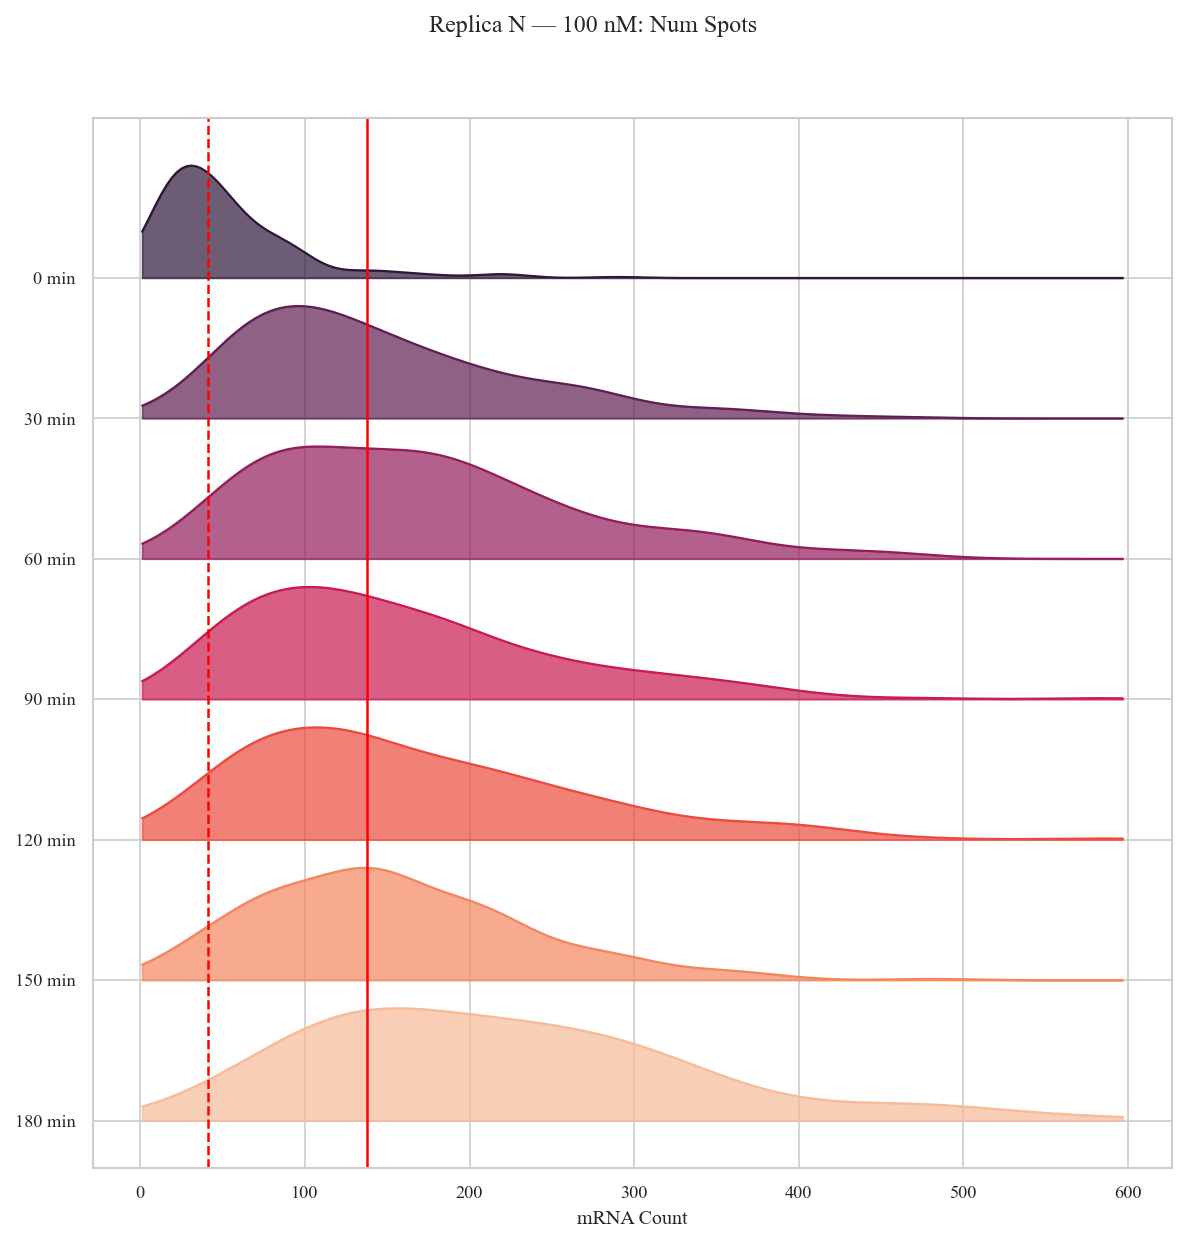

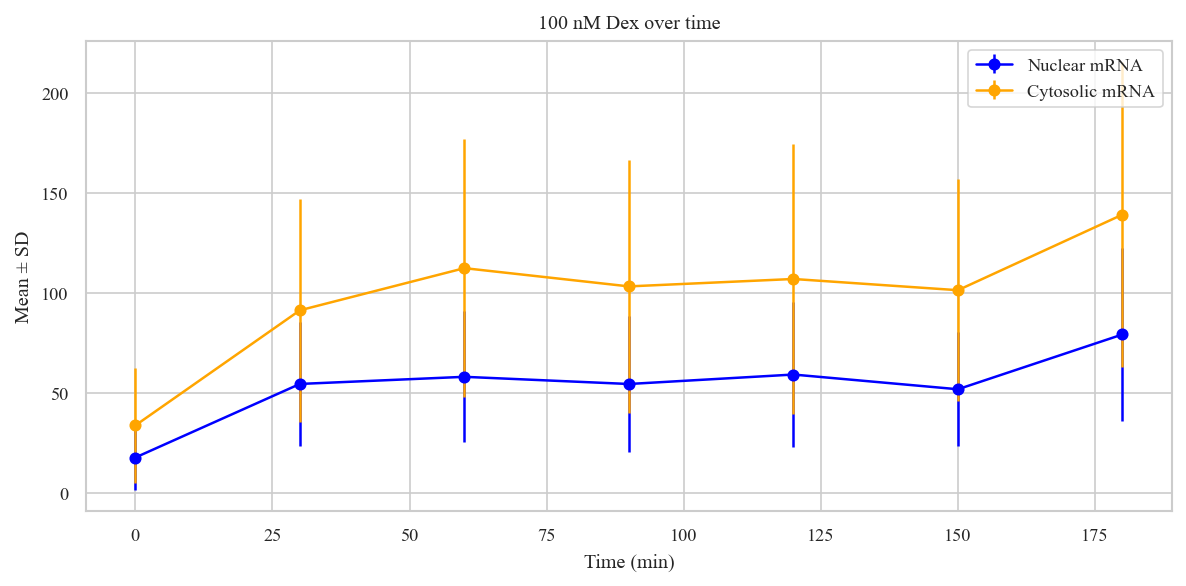

In [7]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_N_Final2')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '50' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 50
prefix = rep_prefix * (10 ** num_digits)

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_N'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")

# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica J 3hr 100nM time-concentration sweep R1`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_50min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_50min_012623.h5 -> Analysis_DUSP1_TCS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_50min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_50min_012623.h5 -> Analysis_DUSP1_TCS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230309/DUSP1_300pM_Dex_180min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230309/DUSP1_300pM_Dex_180min_012623.h5 -> Analysis_DUSP1_TCS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_1nM_Dex_180min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP

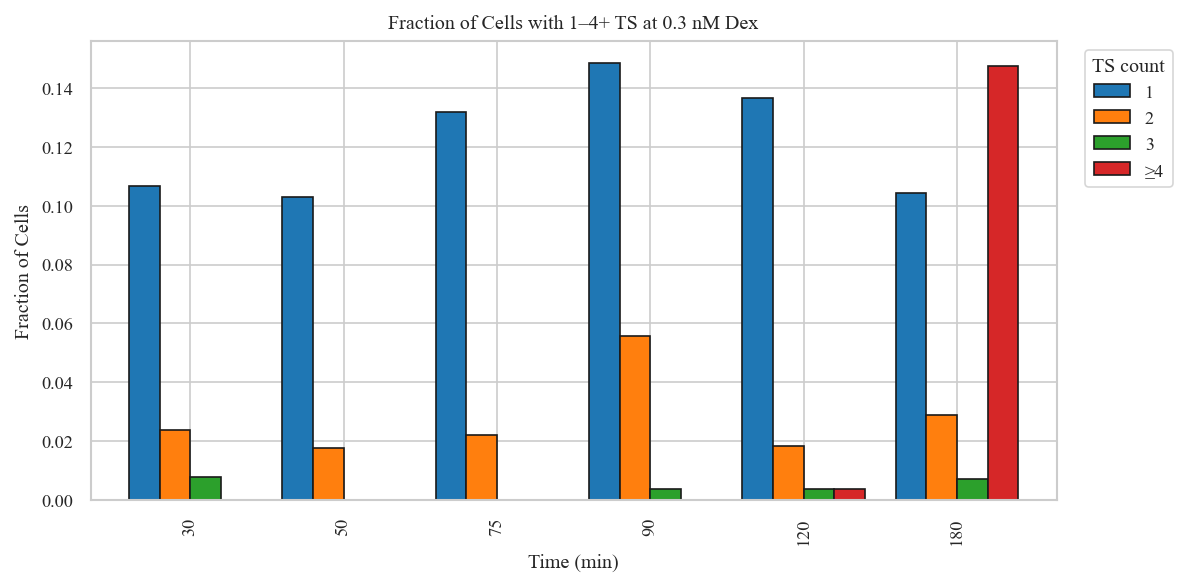

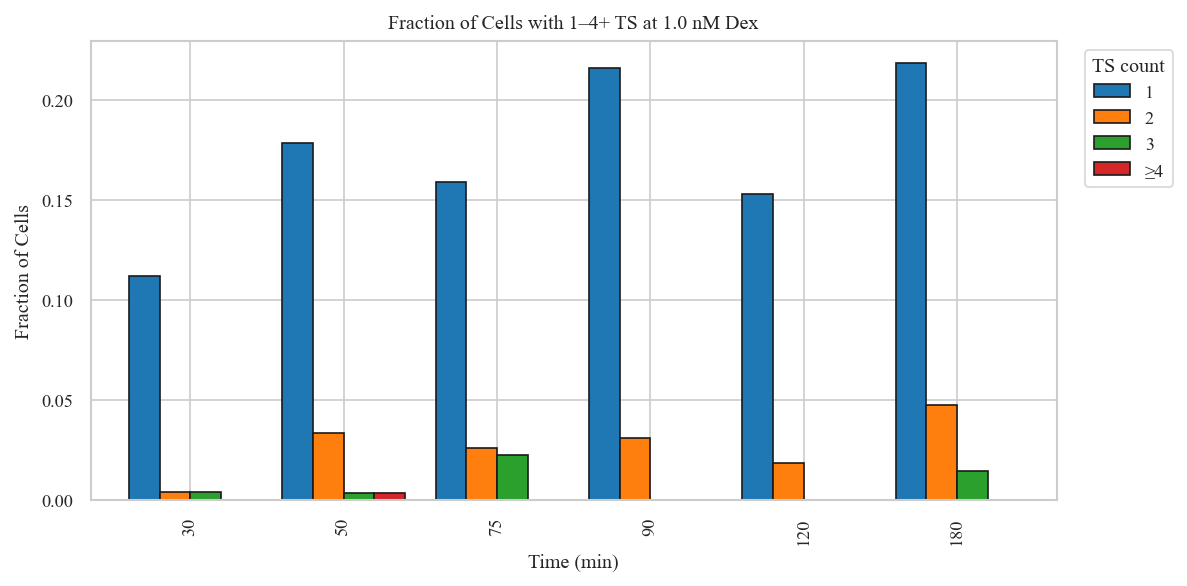

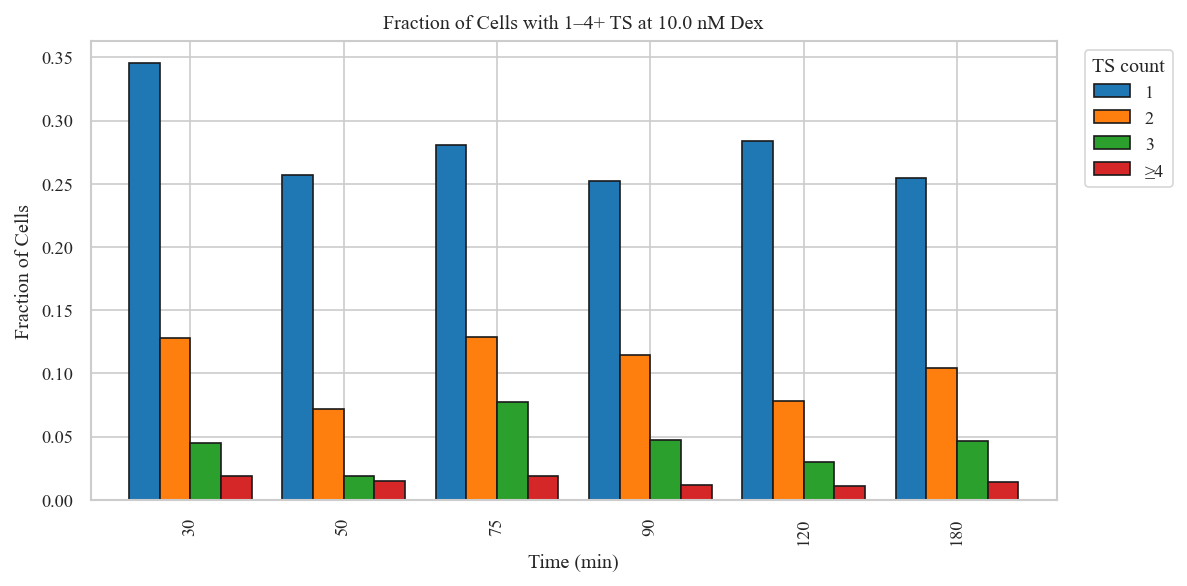

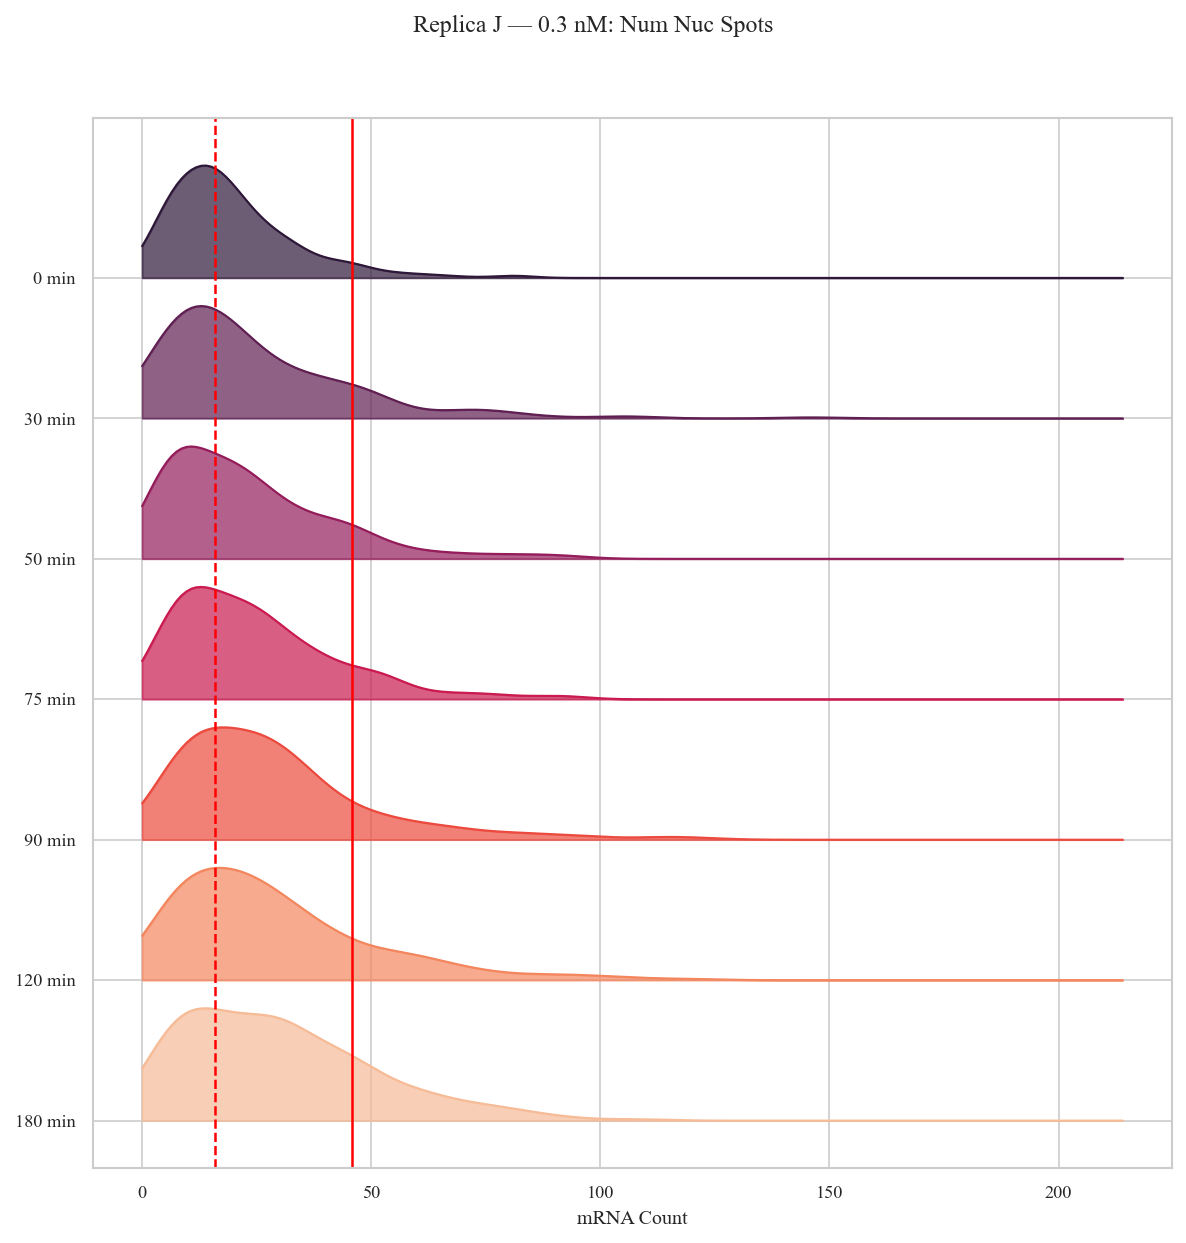

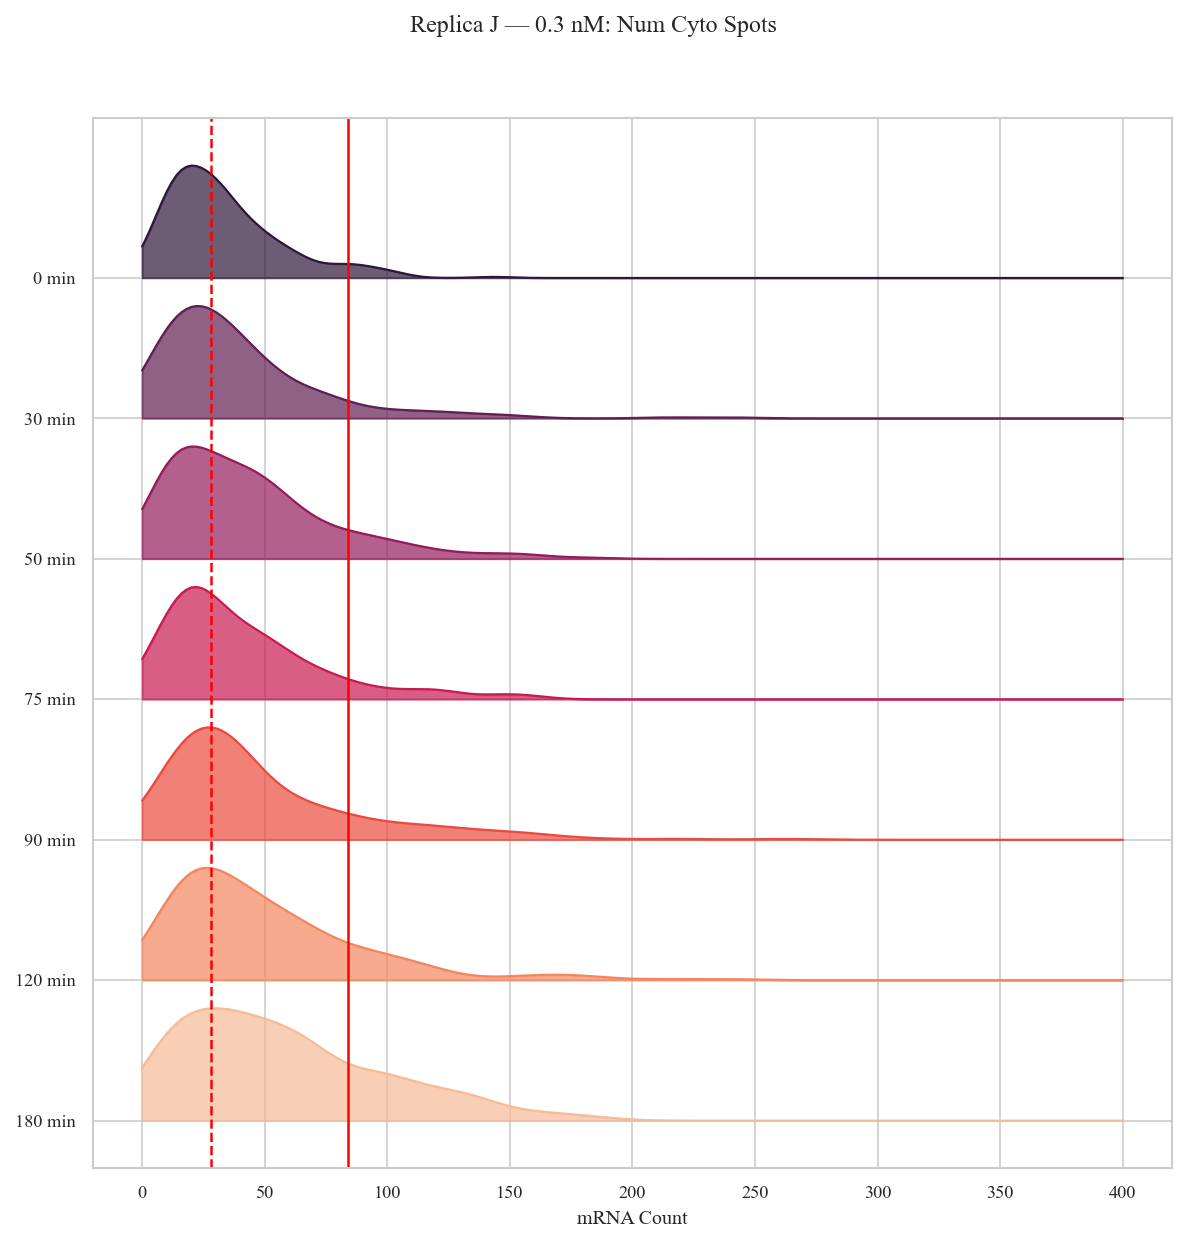

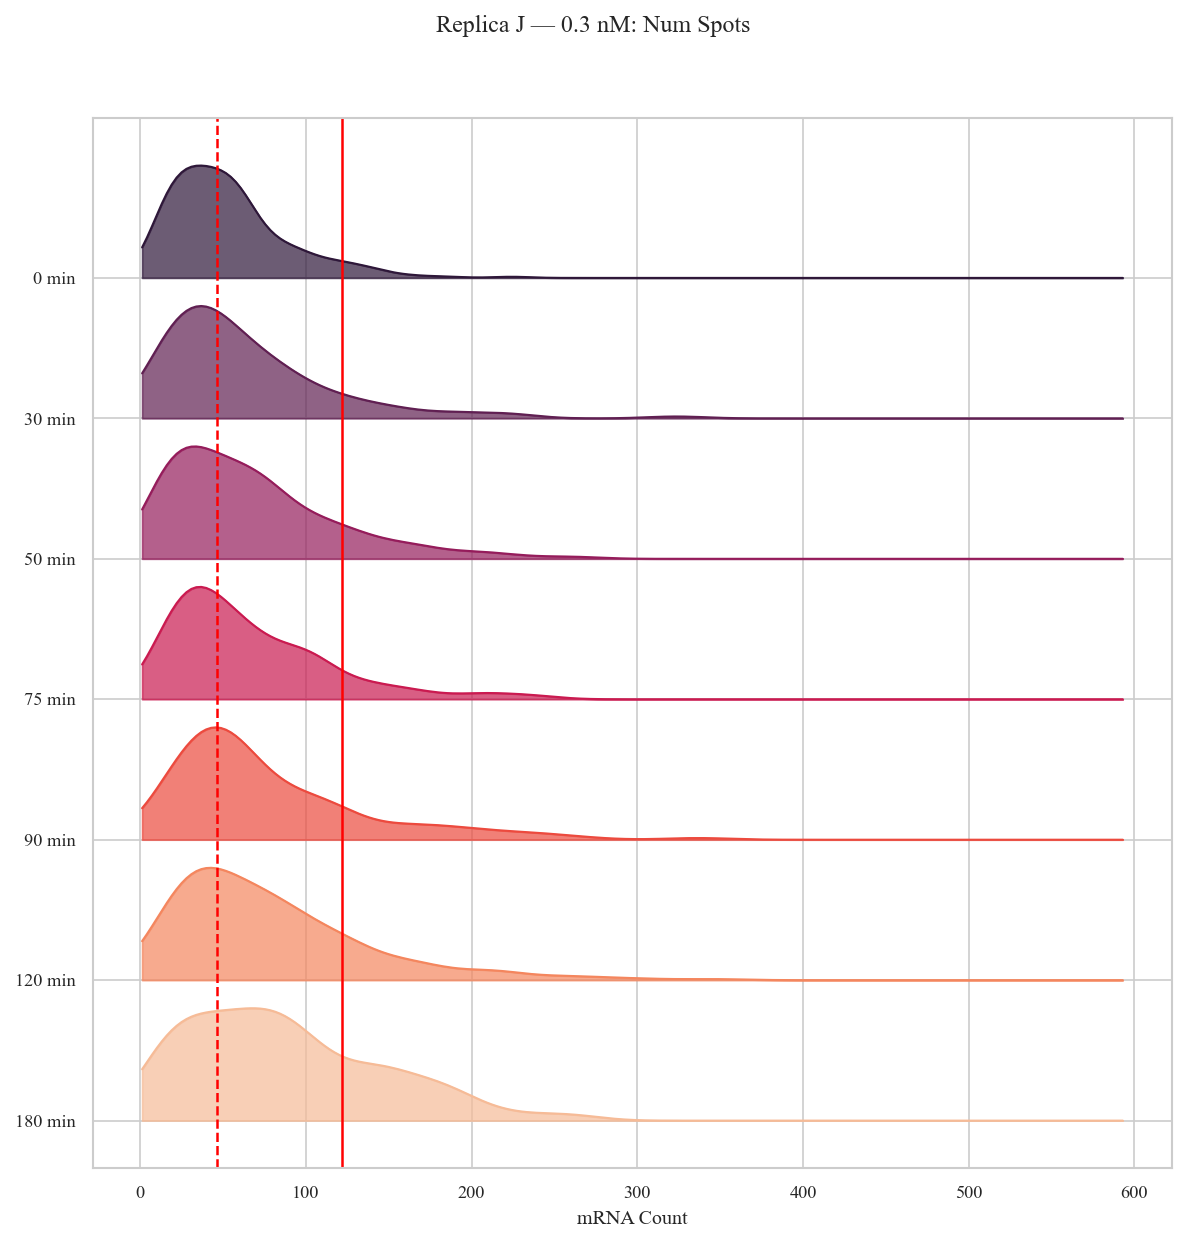

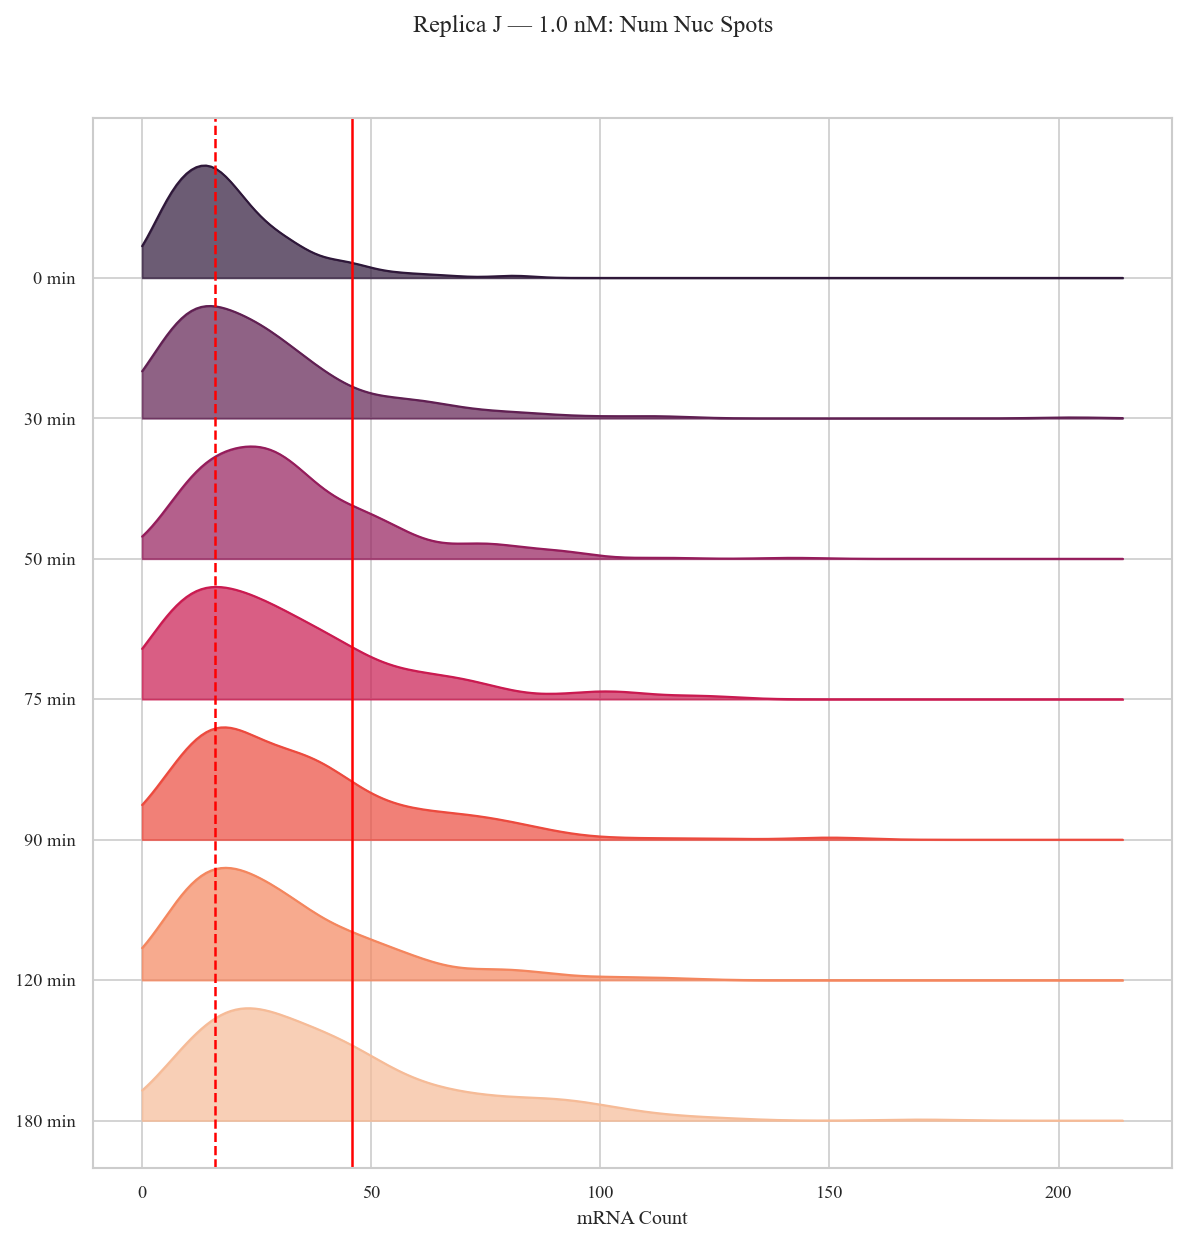

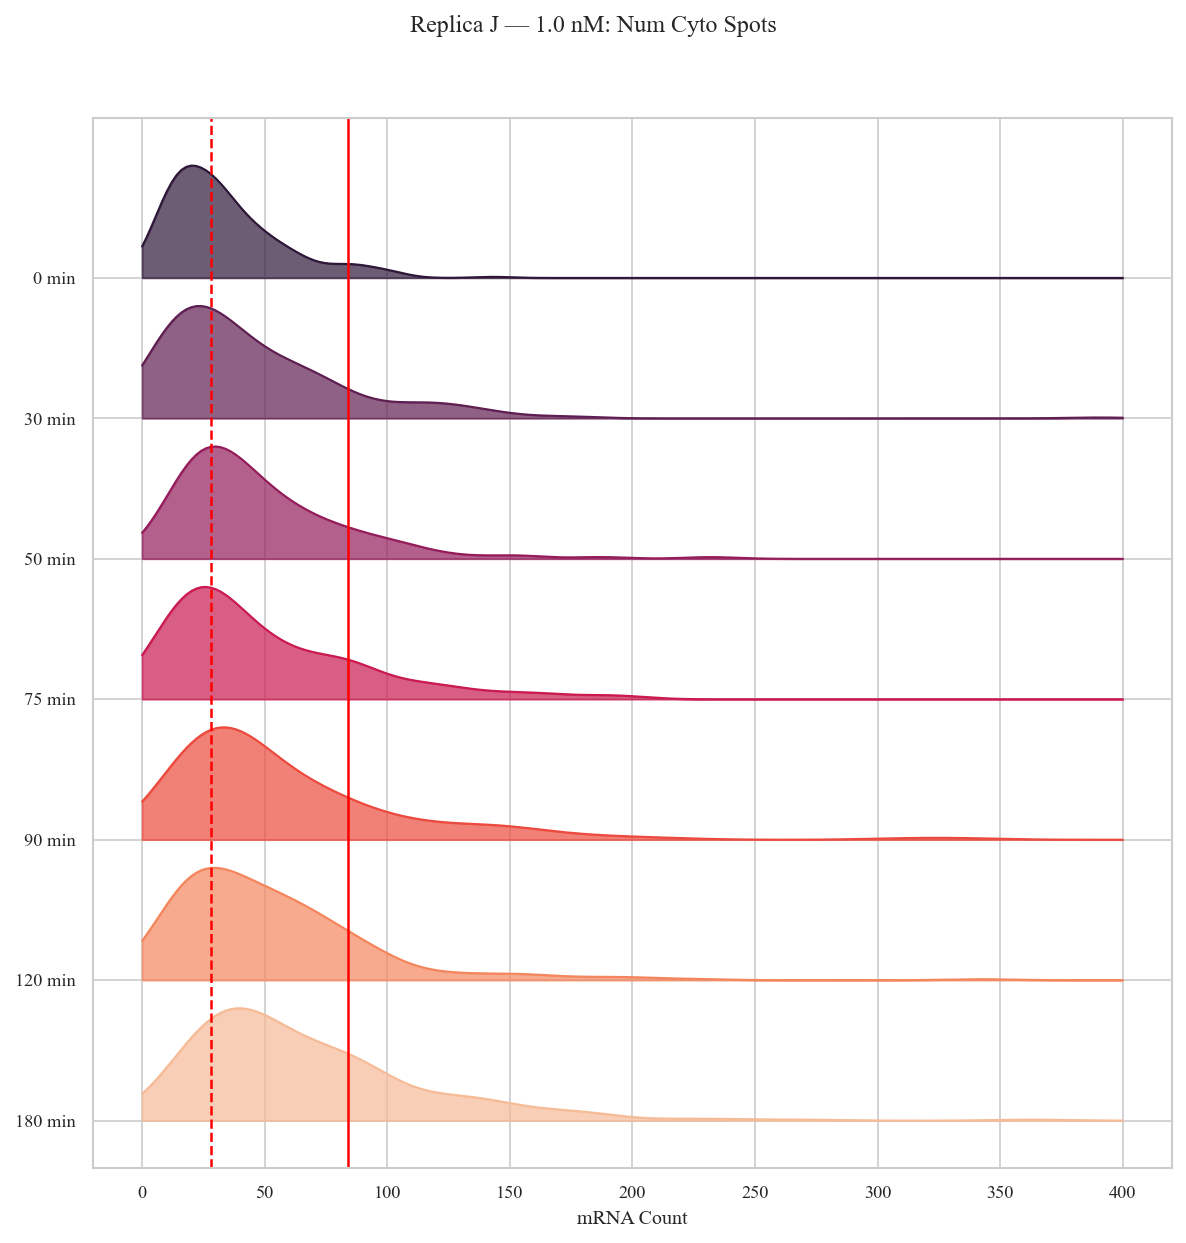

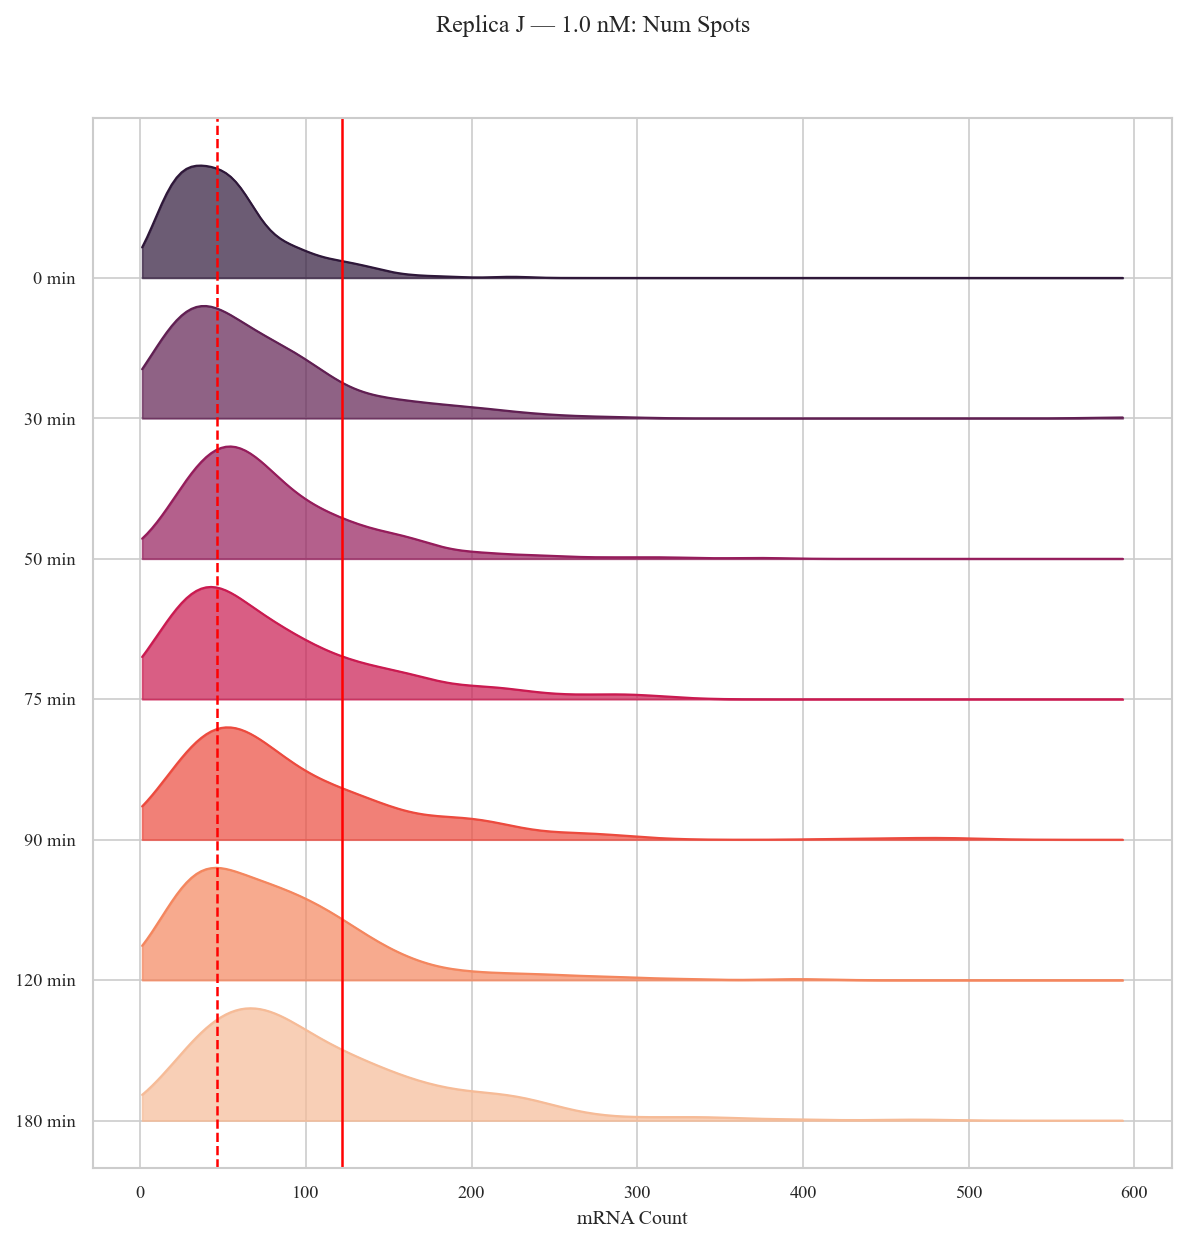

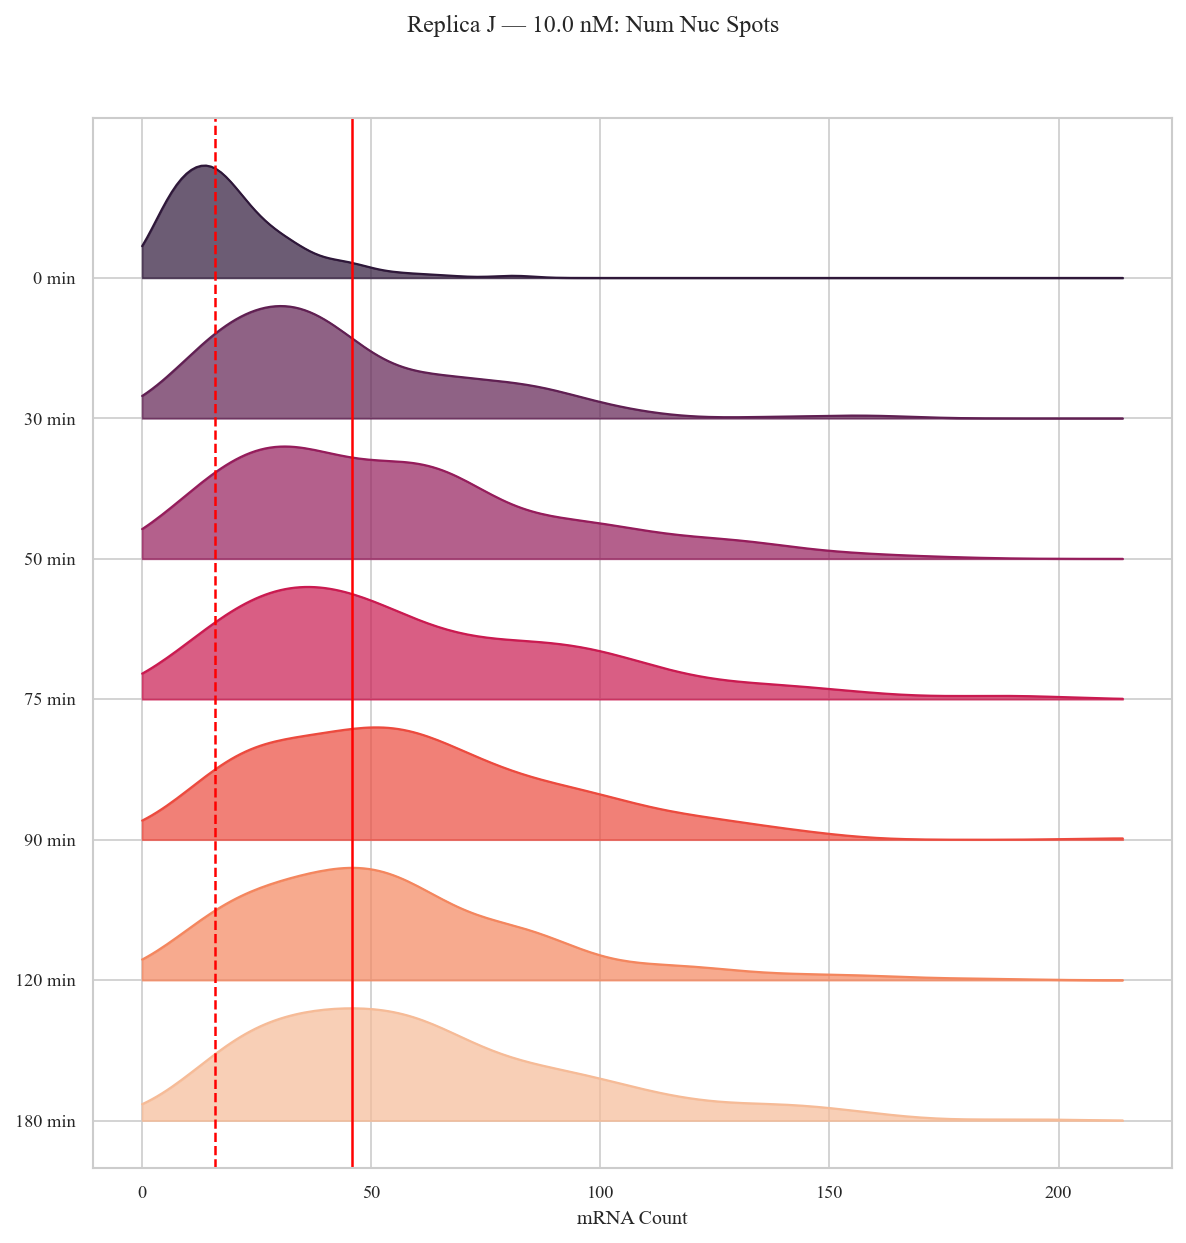

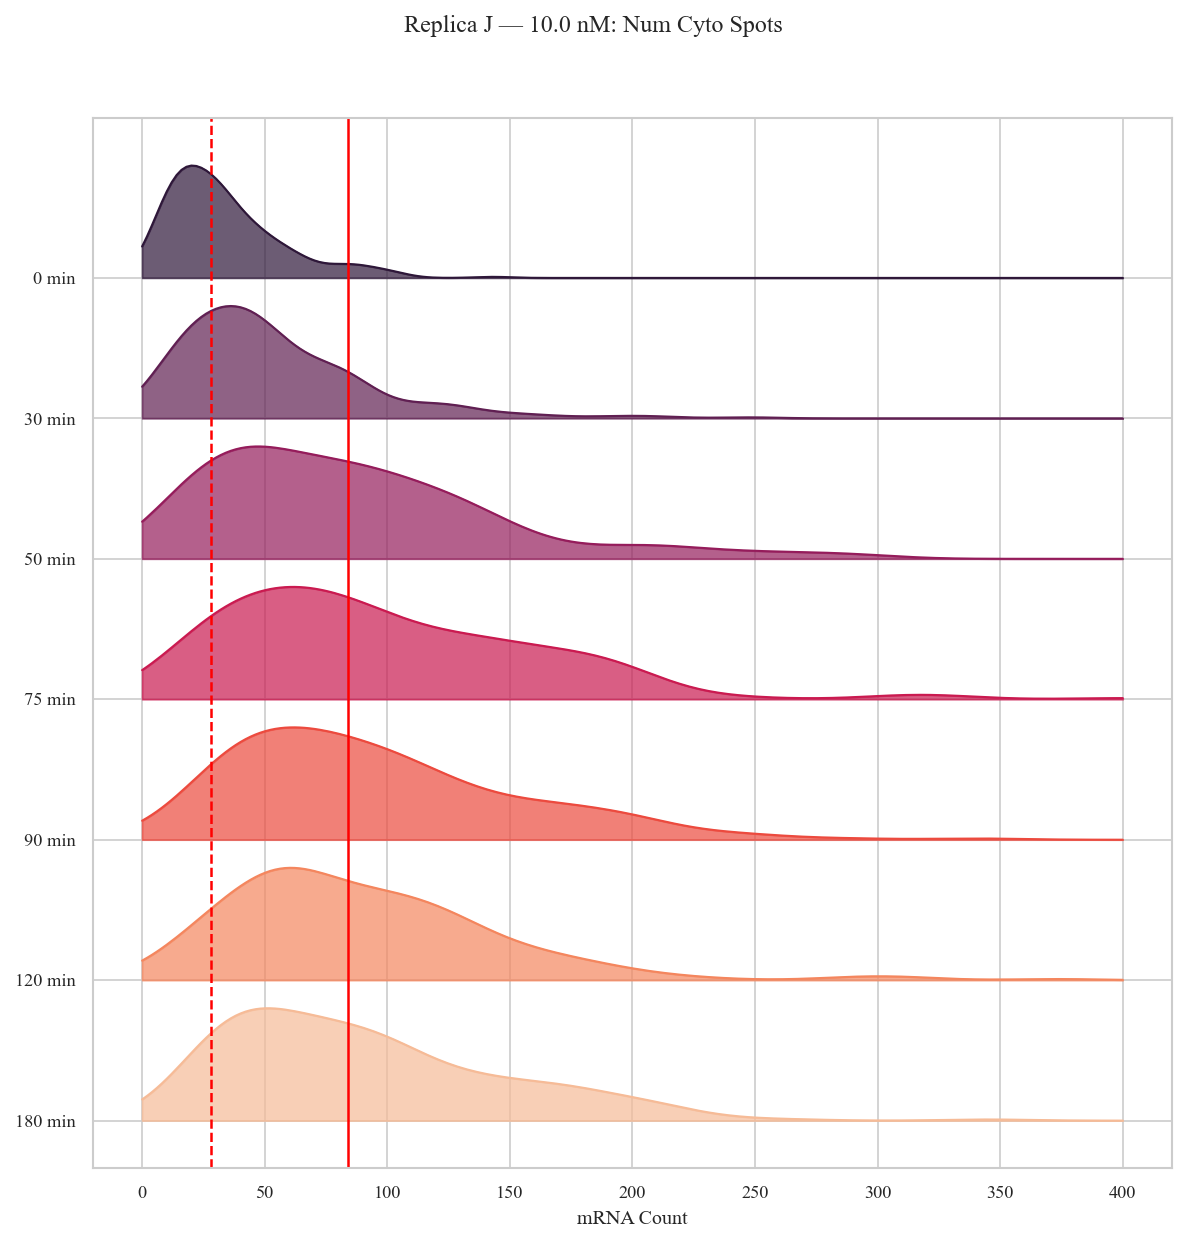

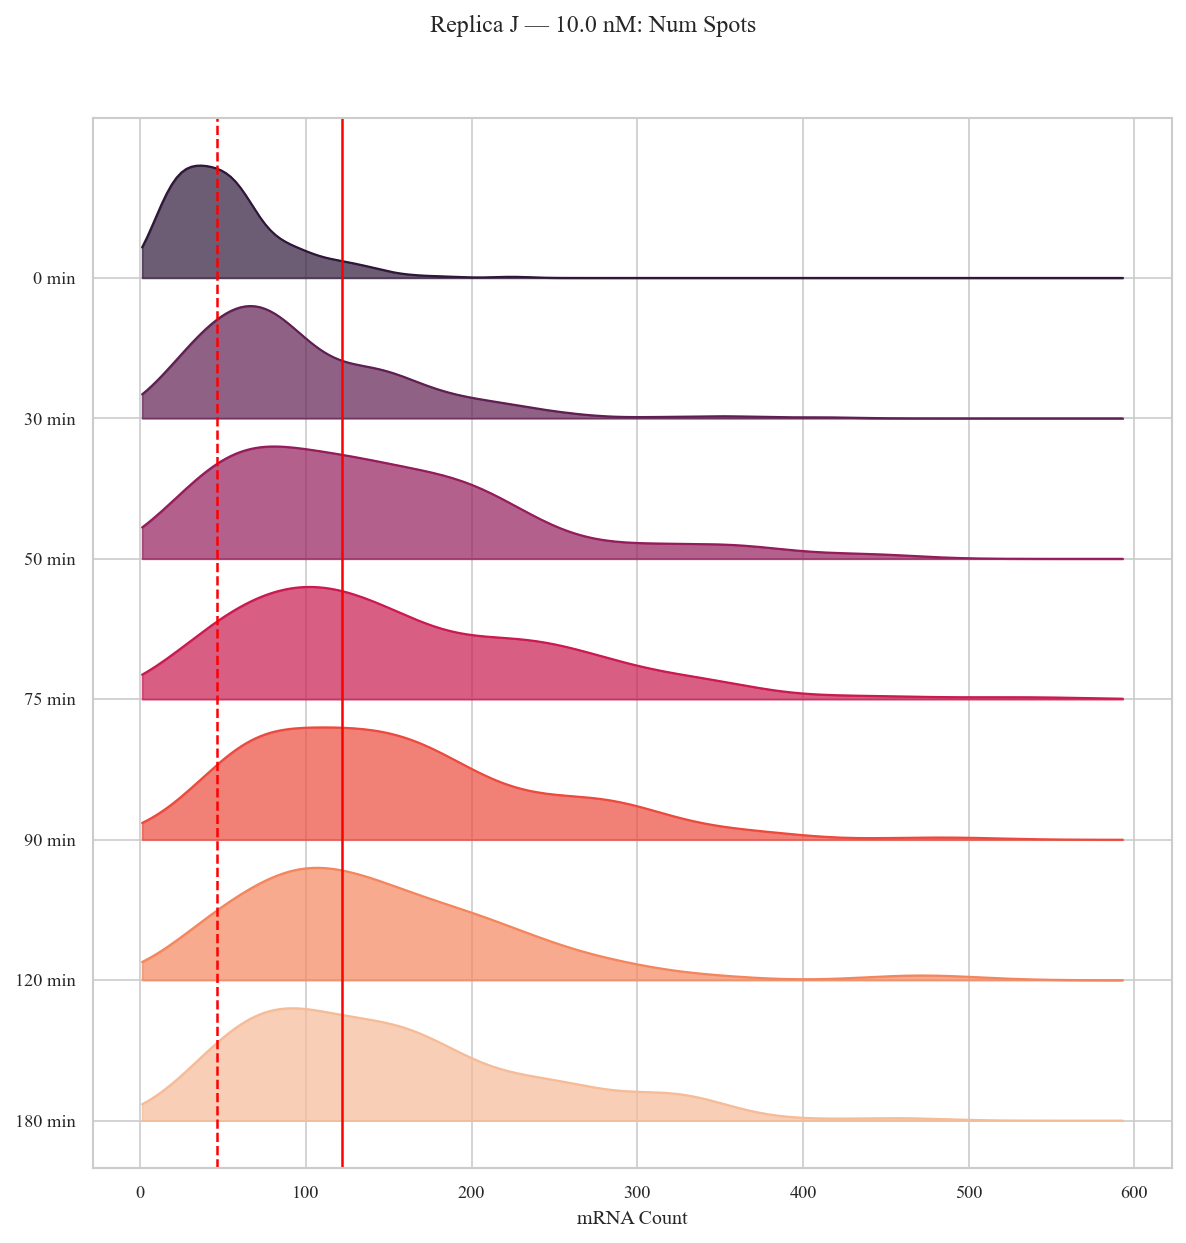

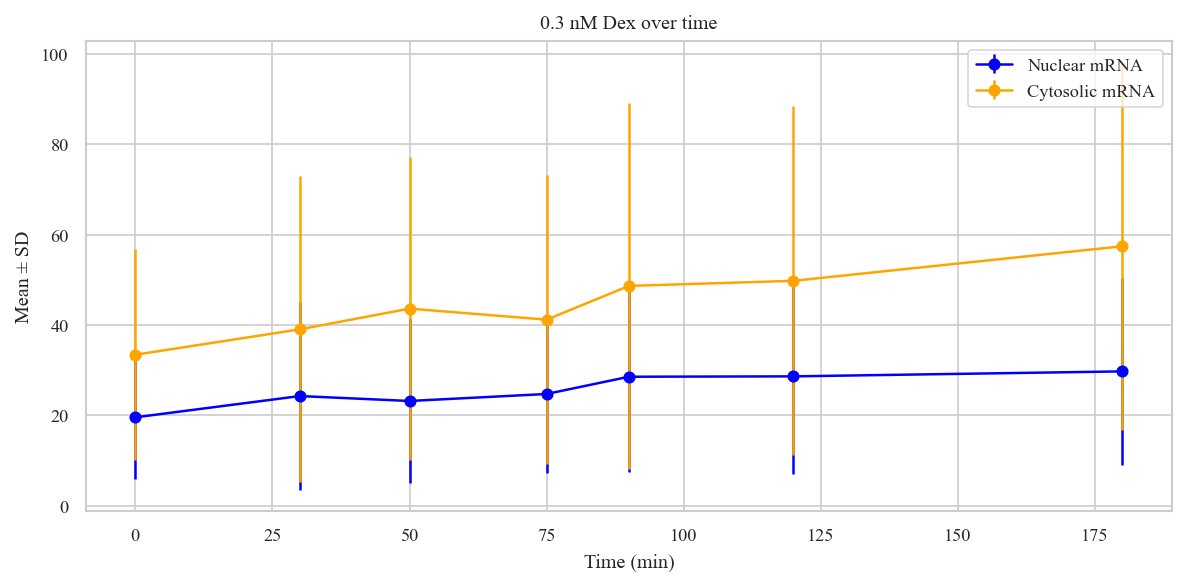

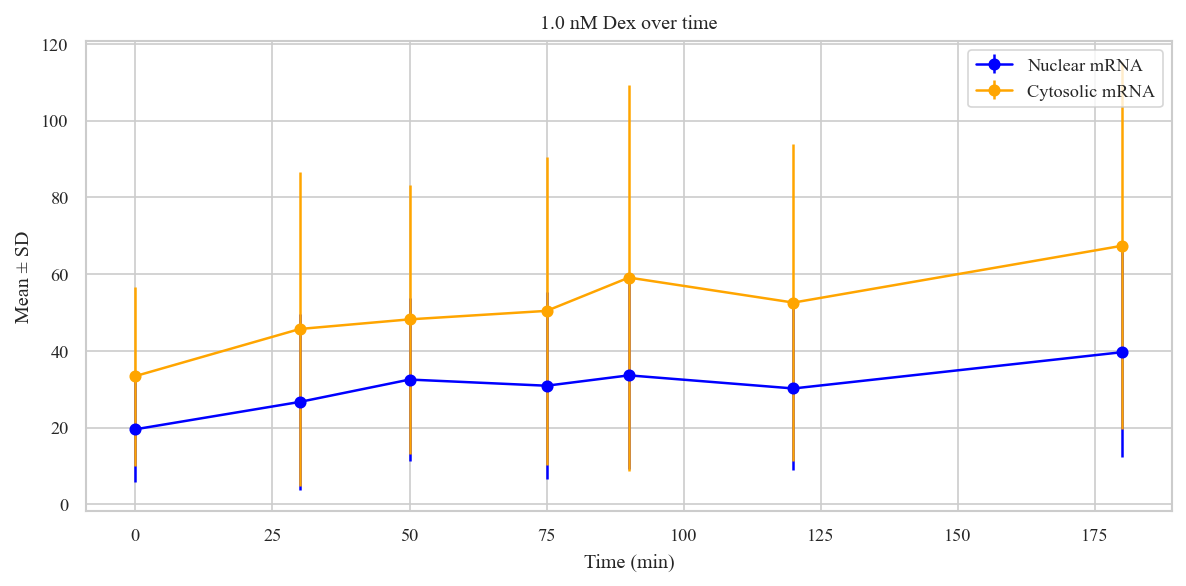

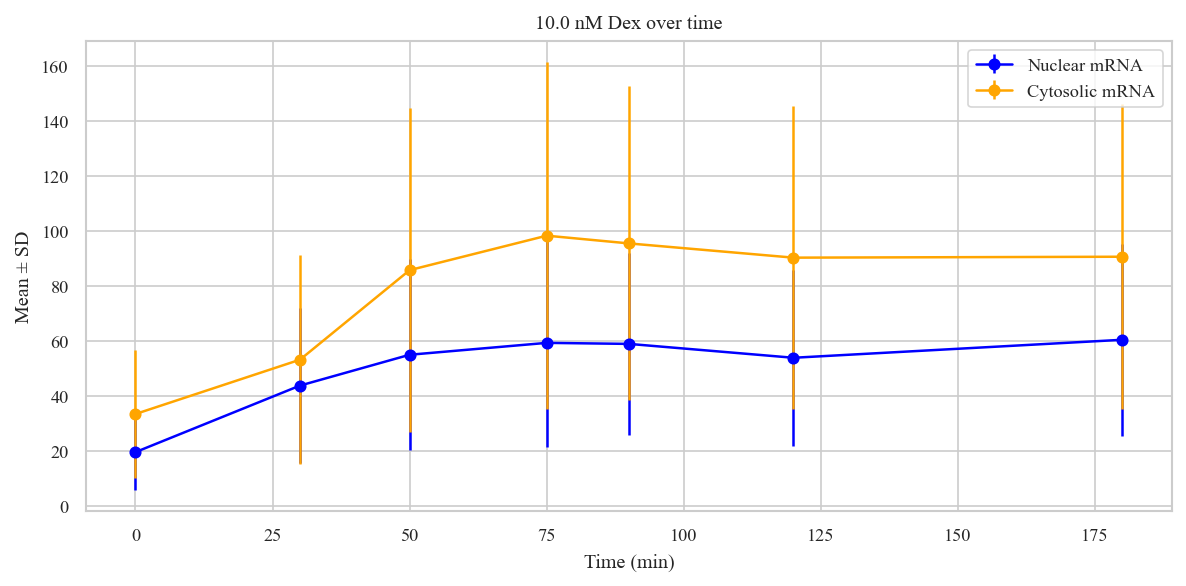

In [8]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_TCS_R1_Final3')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '60' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 60
prefix = rep_prefix * (10 ** num_digits)  

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_J'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica K 3hr 100nM time-concentration sweep R2`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230424/DUSP1_DexTimeConcSweep_1nM_30min_041223.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230424/DUSP1_DexTimeConcSweep_1nM_30min_041223.h5 -> Analysis_DUSP1_K_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230424/DUSP1_DexTimeConcSweep_300pM_120min_041223.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230424/DUSP1_DexTimeConcSweep_300pM_120min_041223.h5 -> Analysis_DUSP1_K_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_300pM_30min_041223.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_300pM_30min_041223.h5 -> Analysis_DUSP1_K_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230427/DUSP1_DexTimeConcSweep_10nM_30min_041223.h5
Reading DataFr

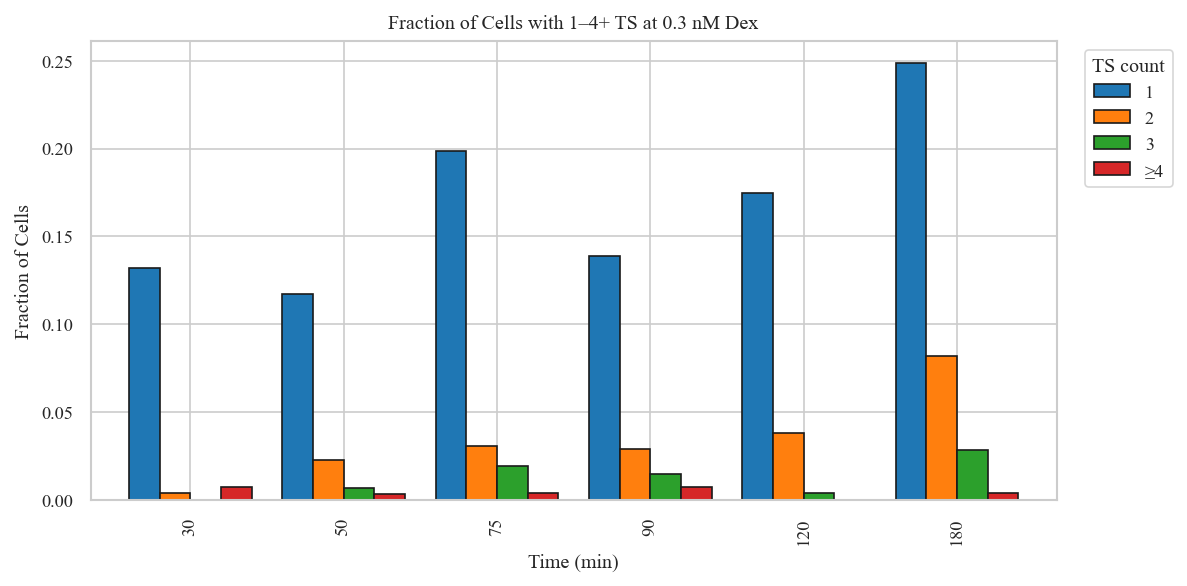

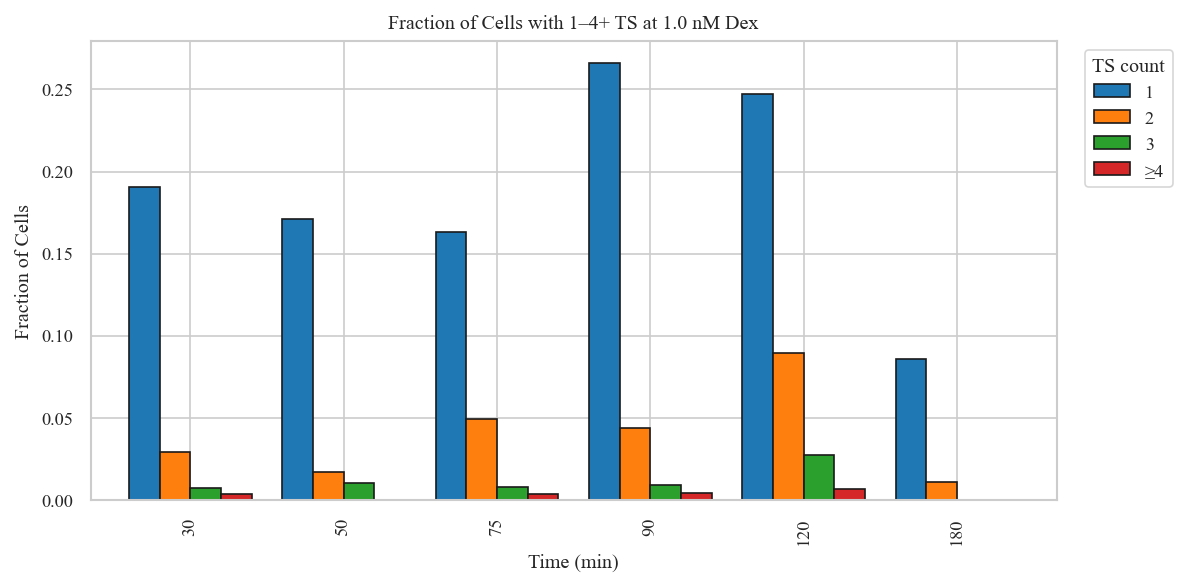

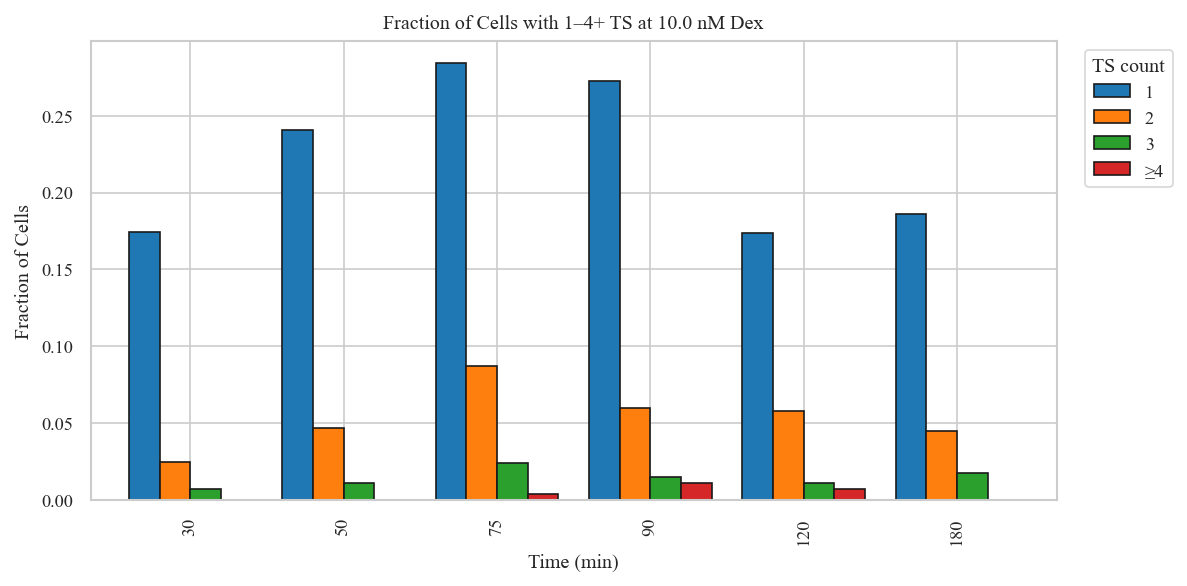

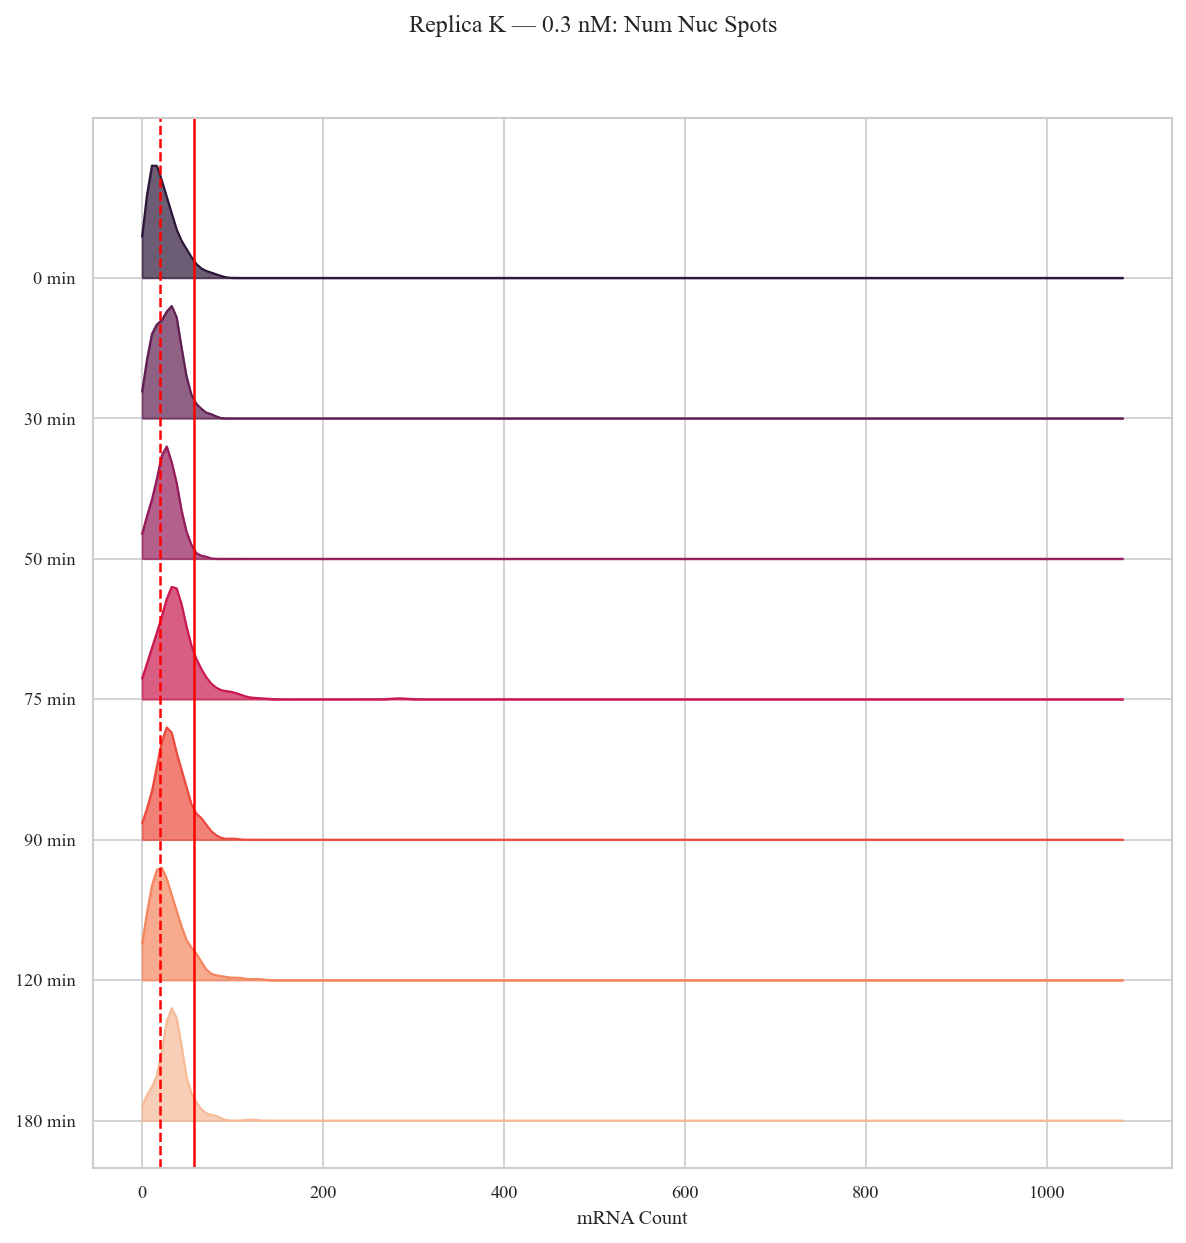

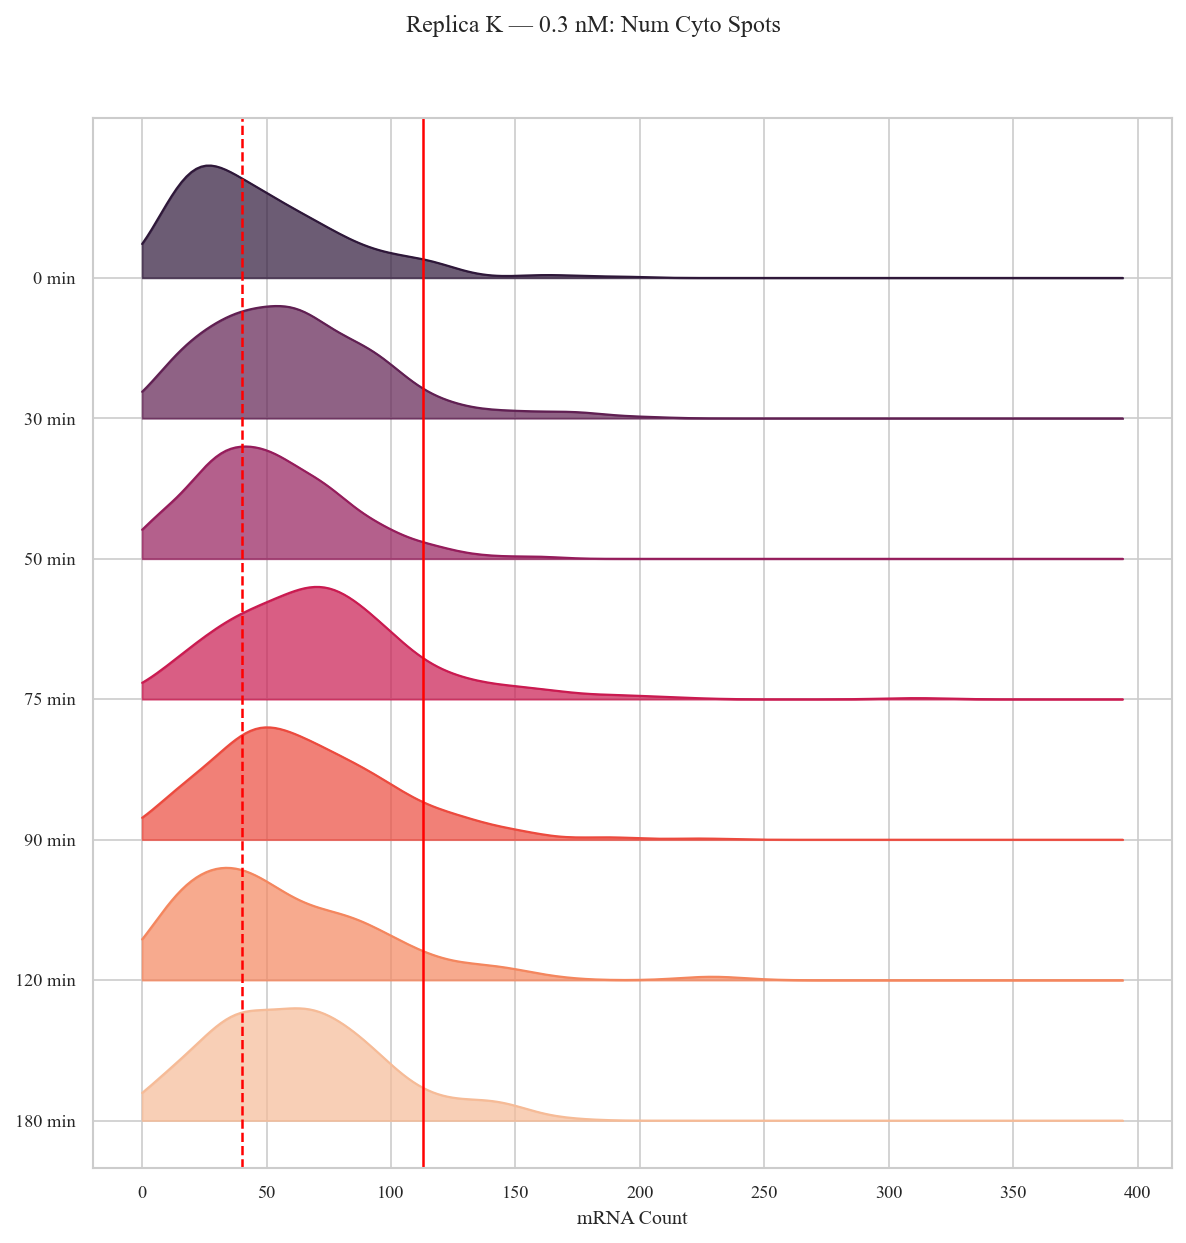

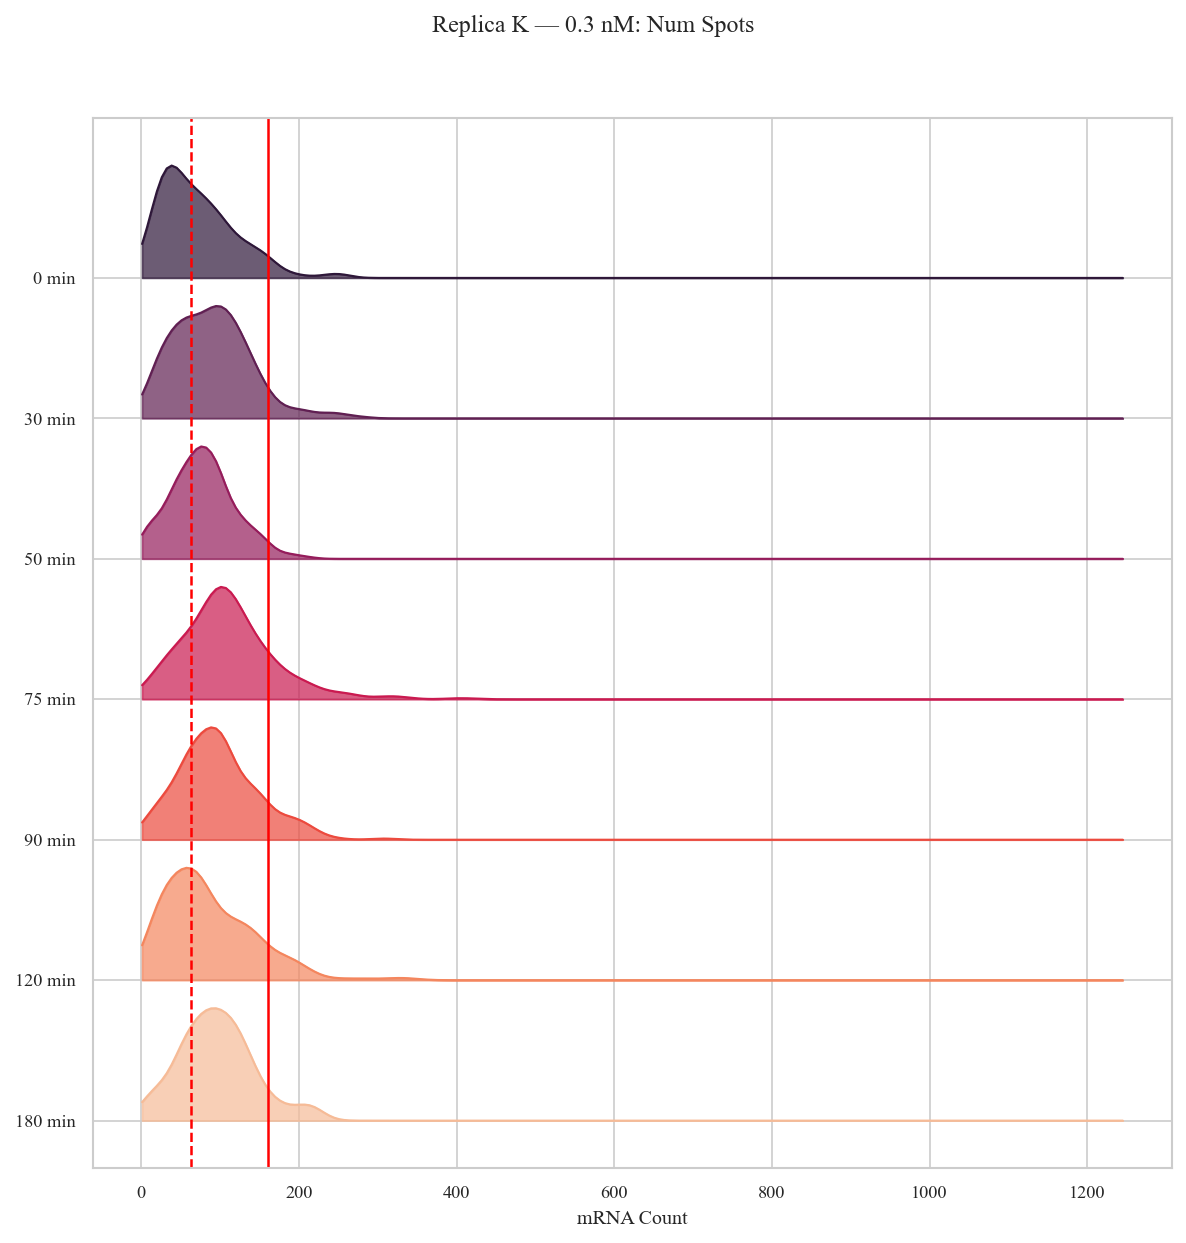

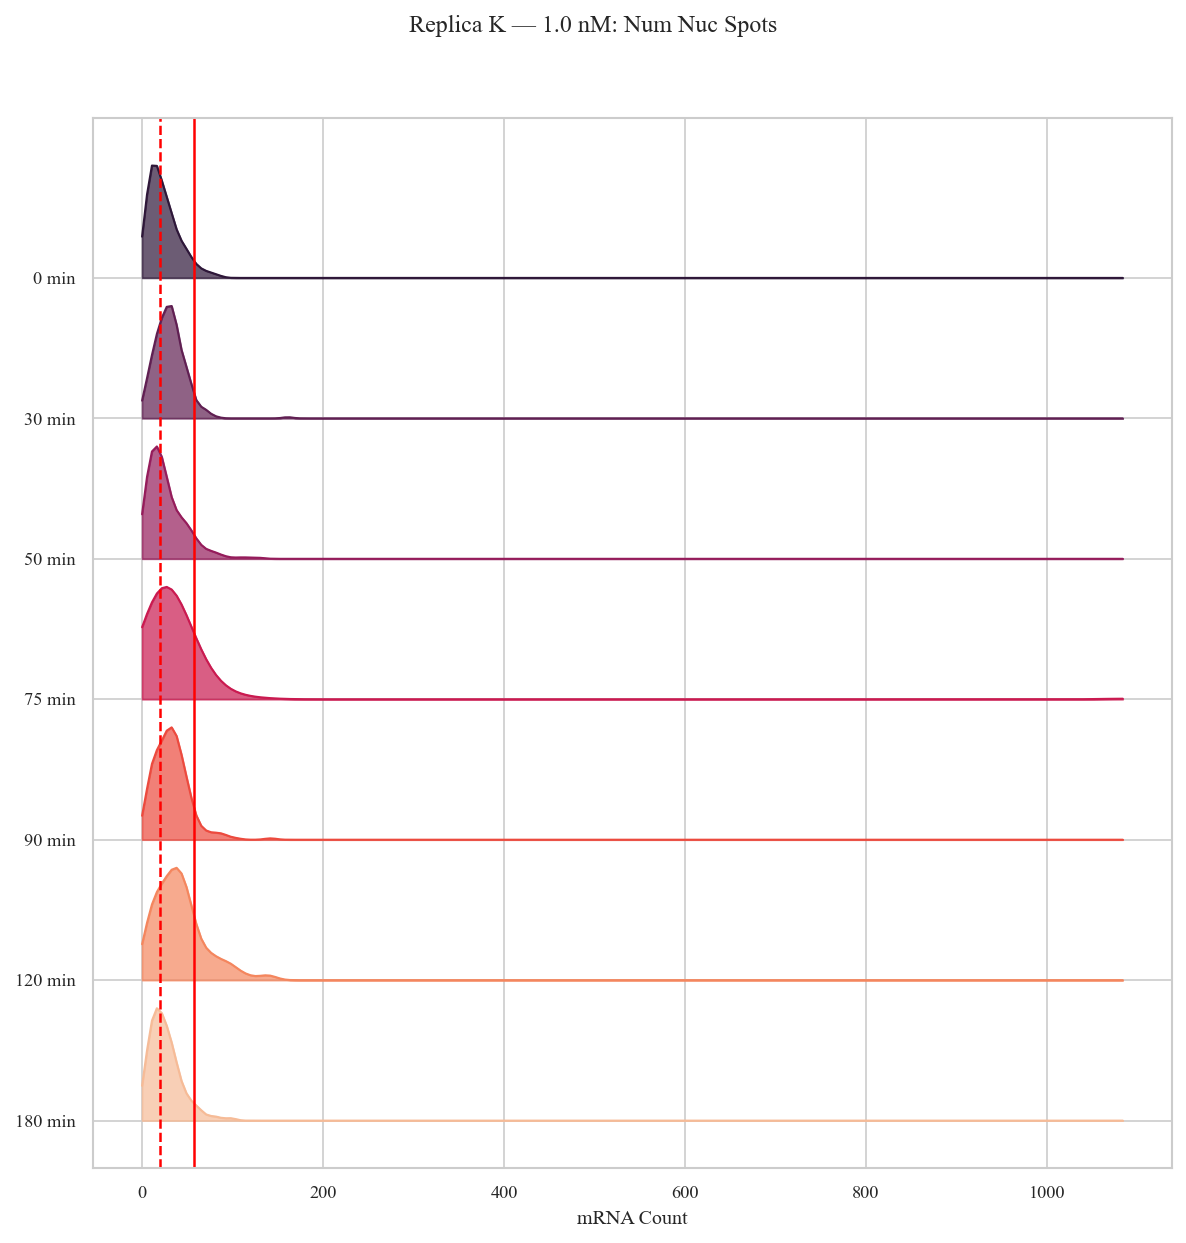

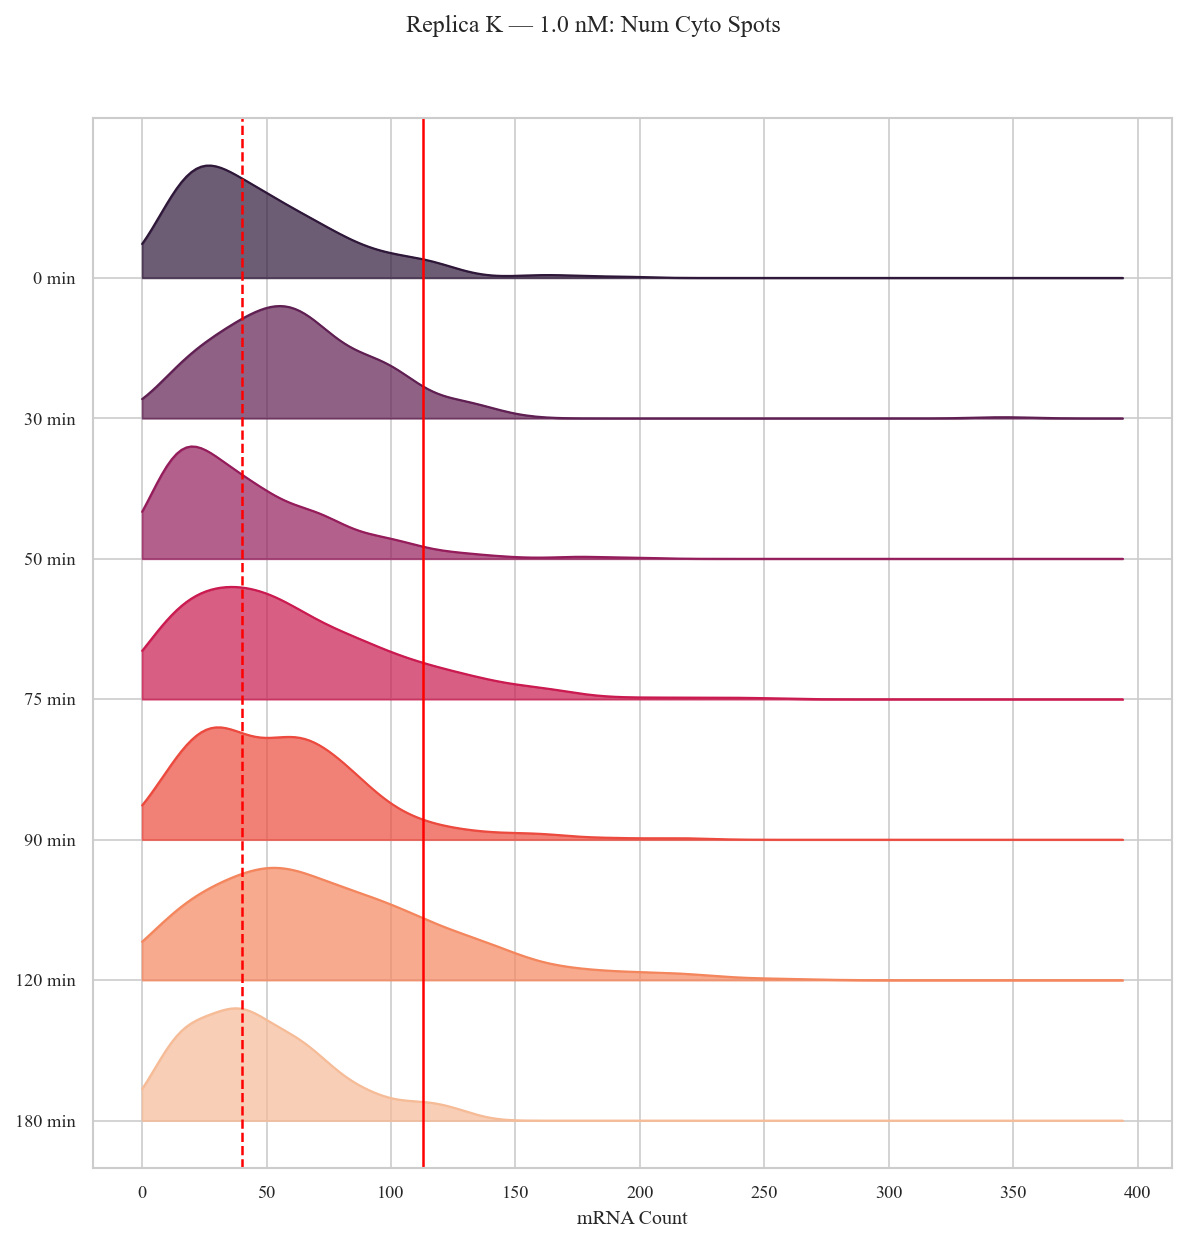

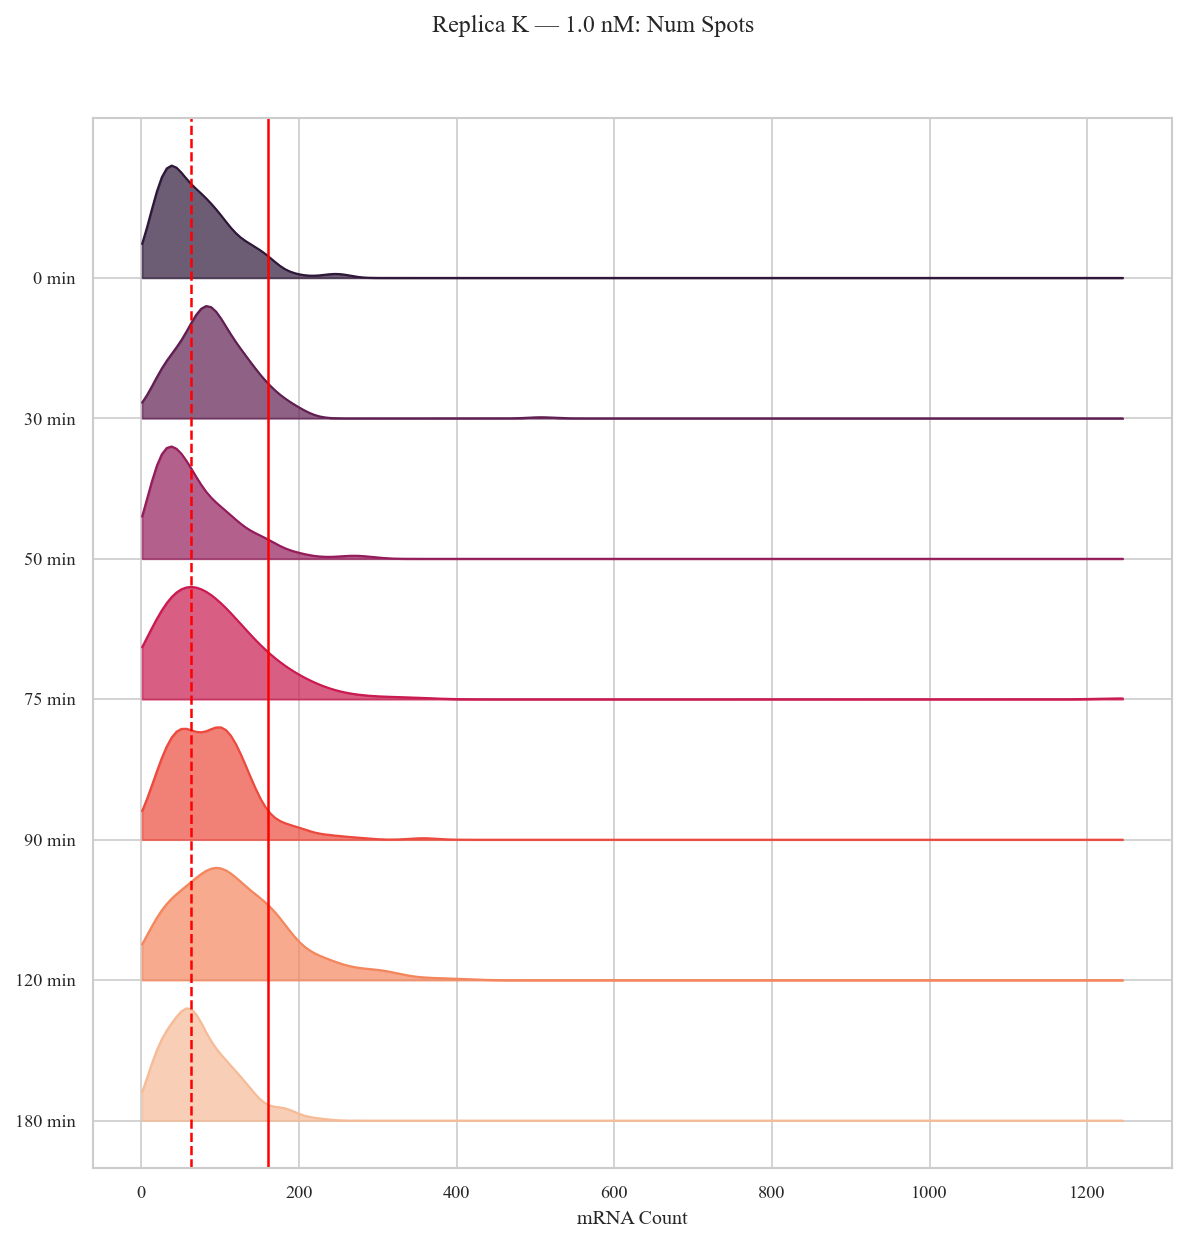

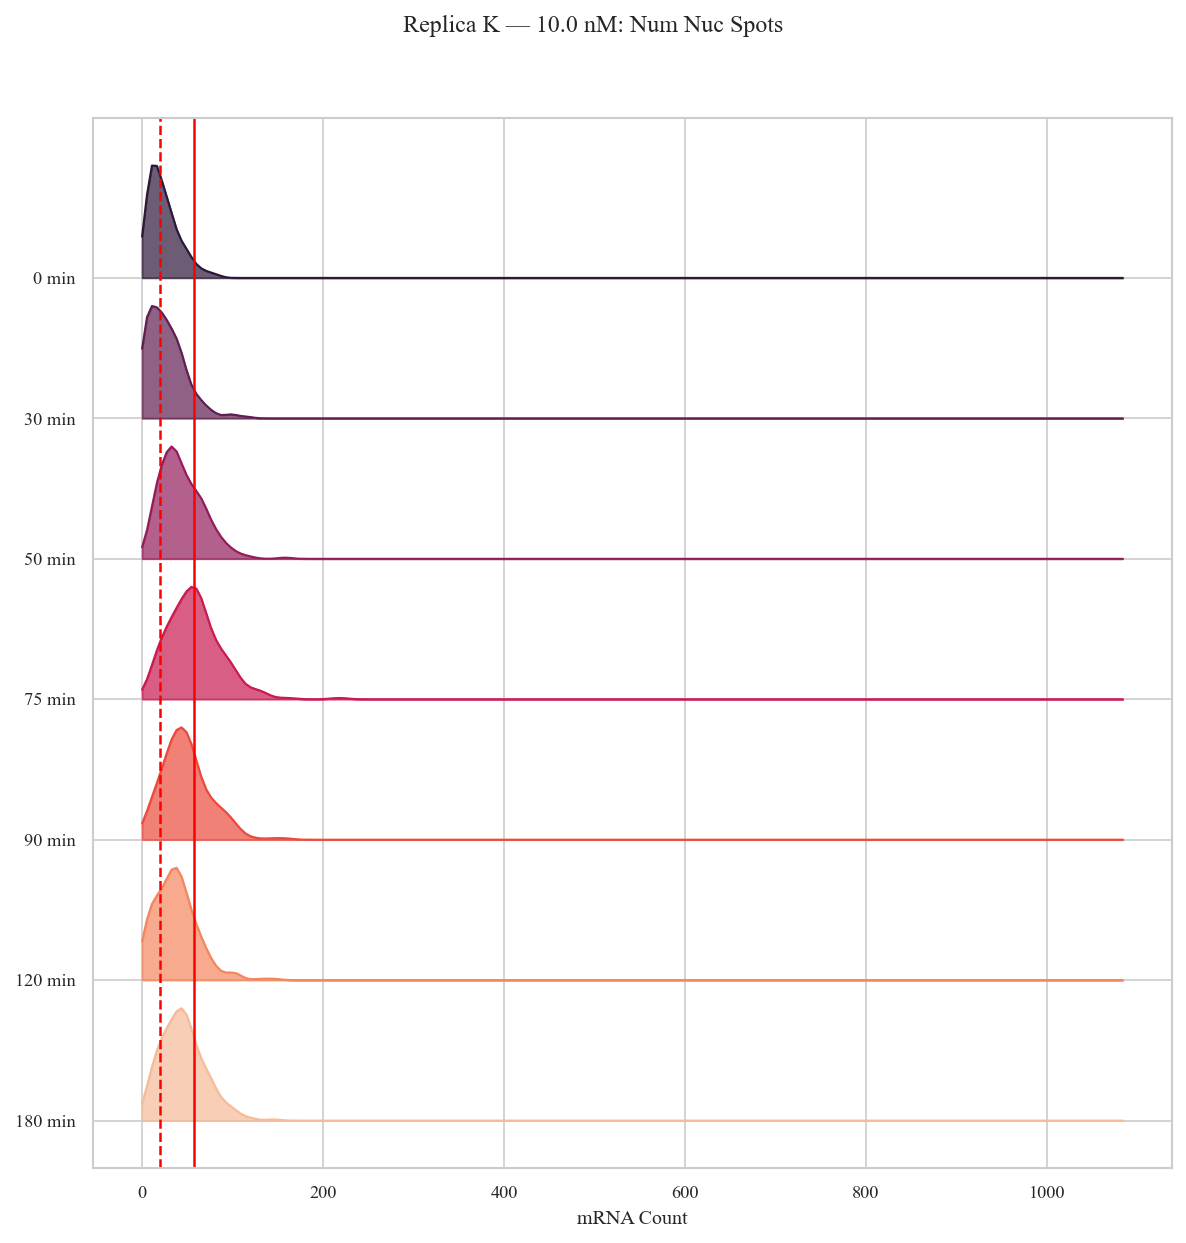

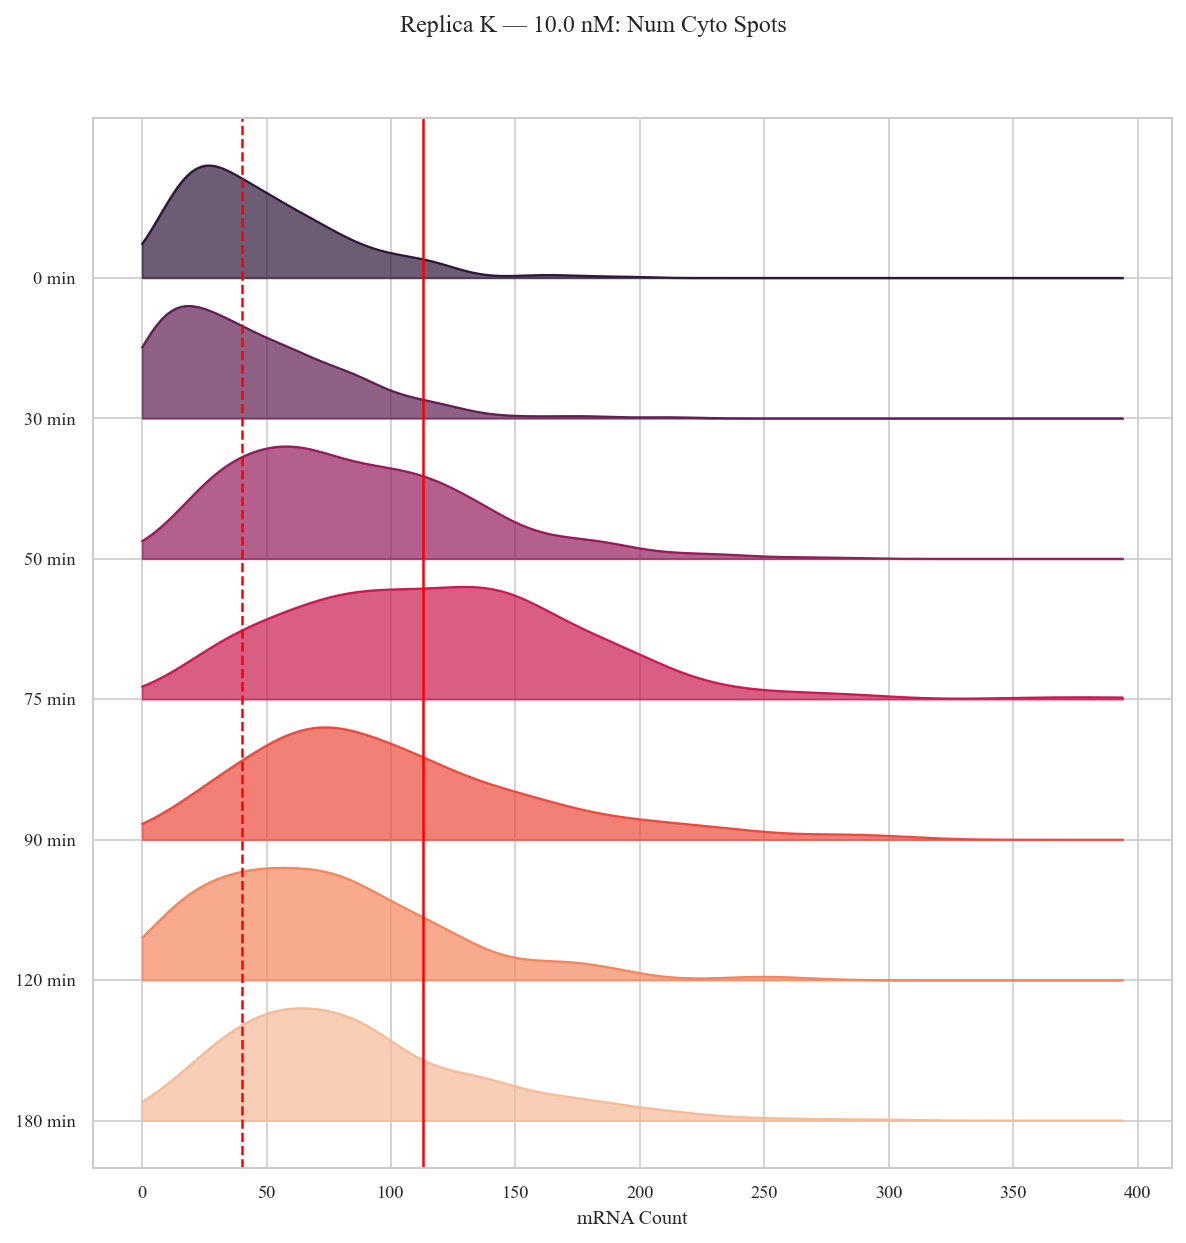

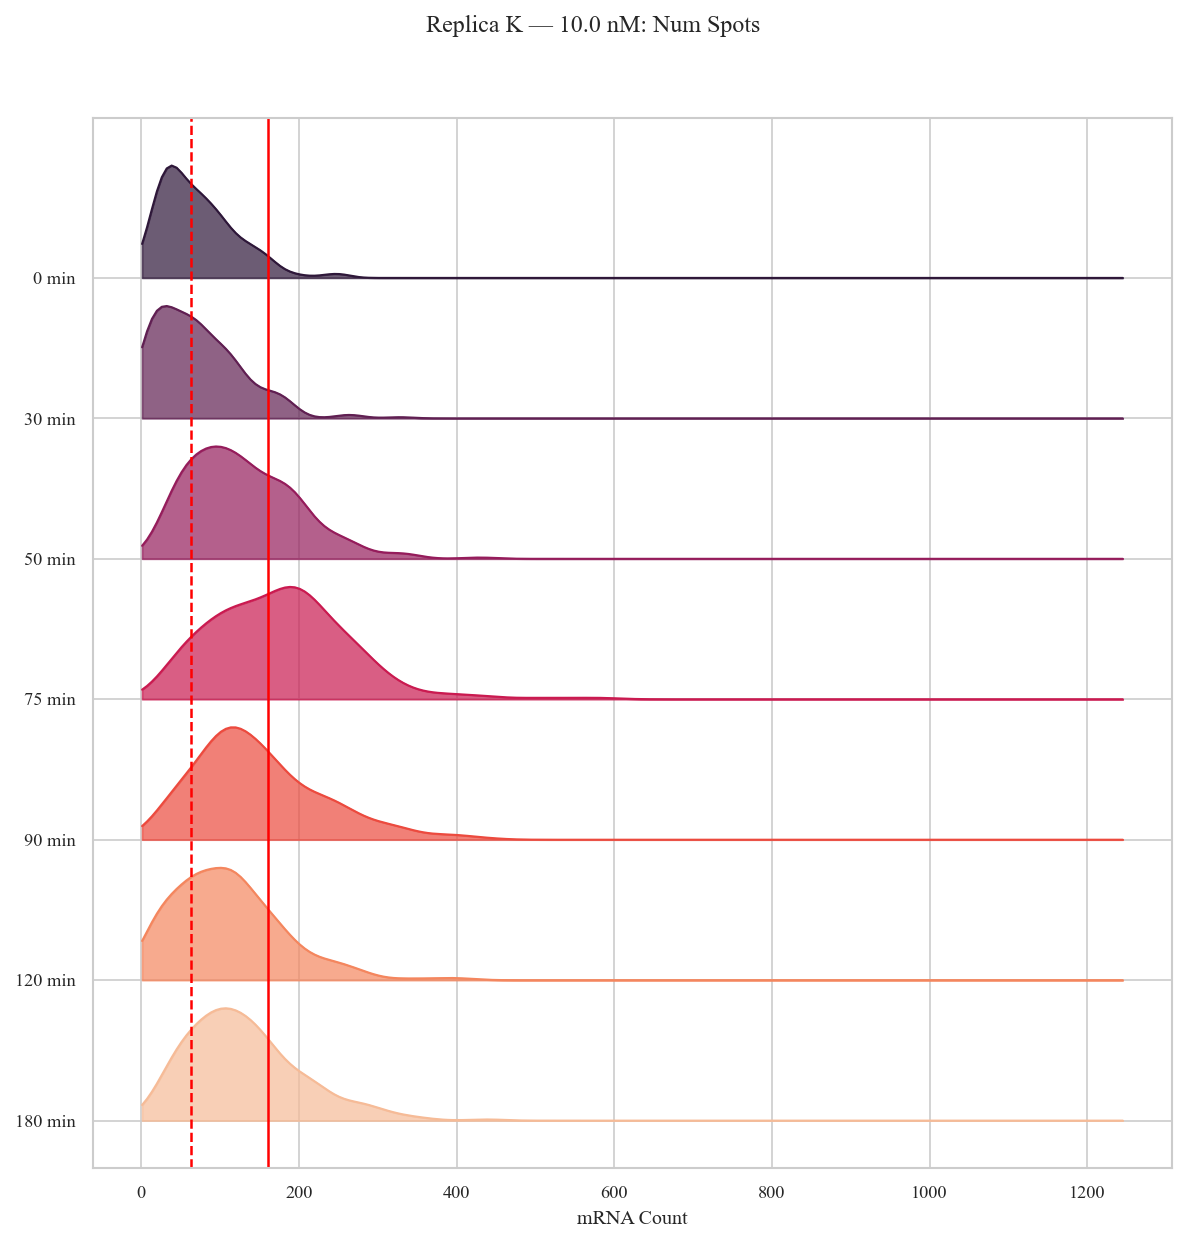

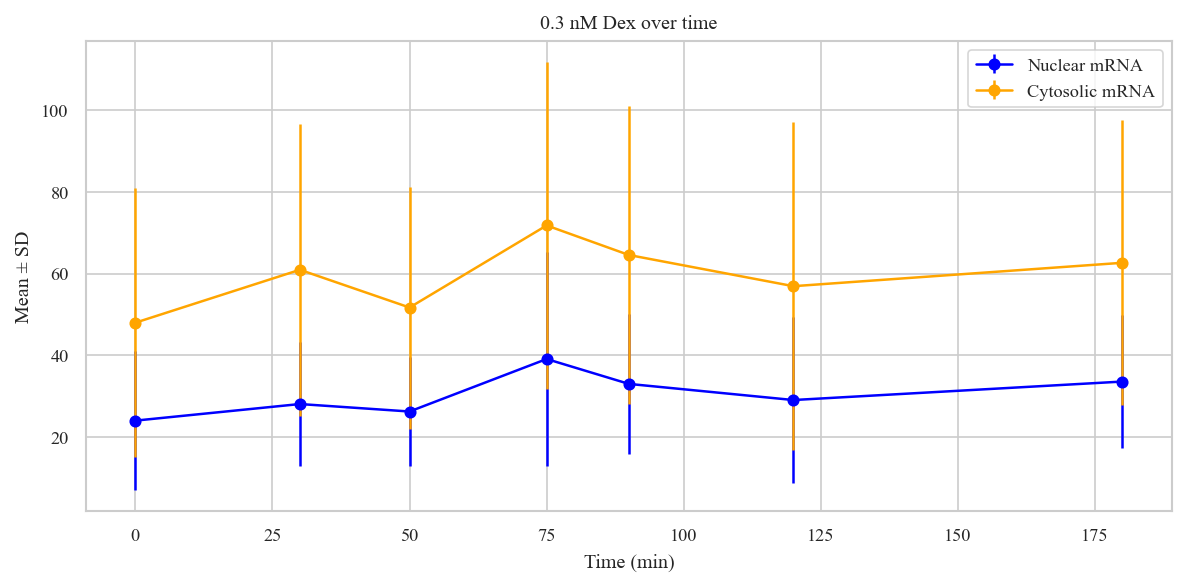

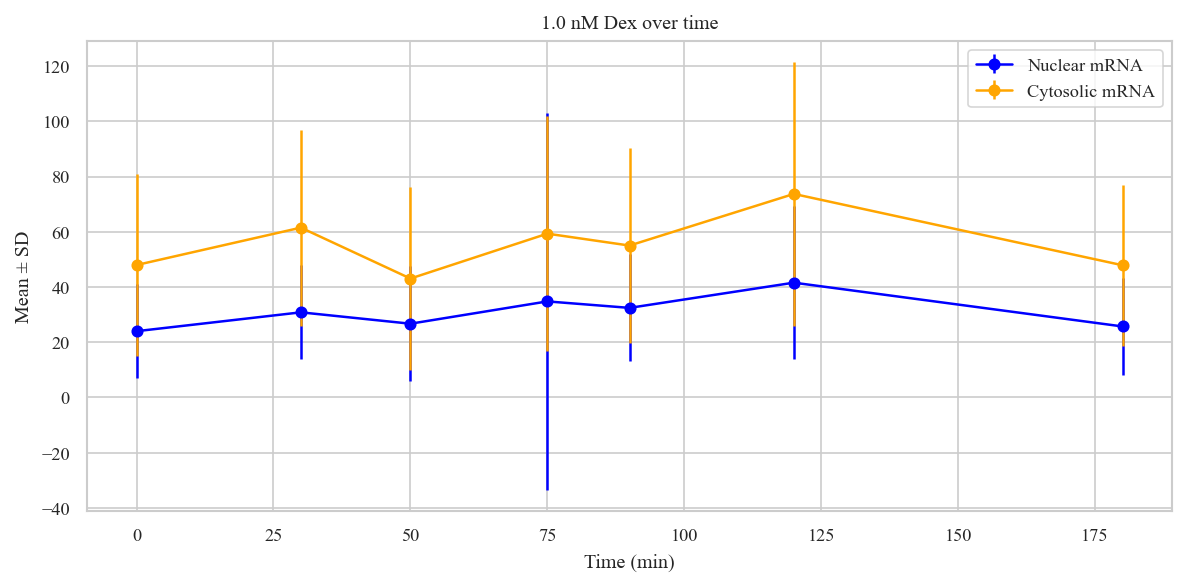

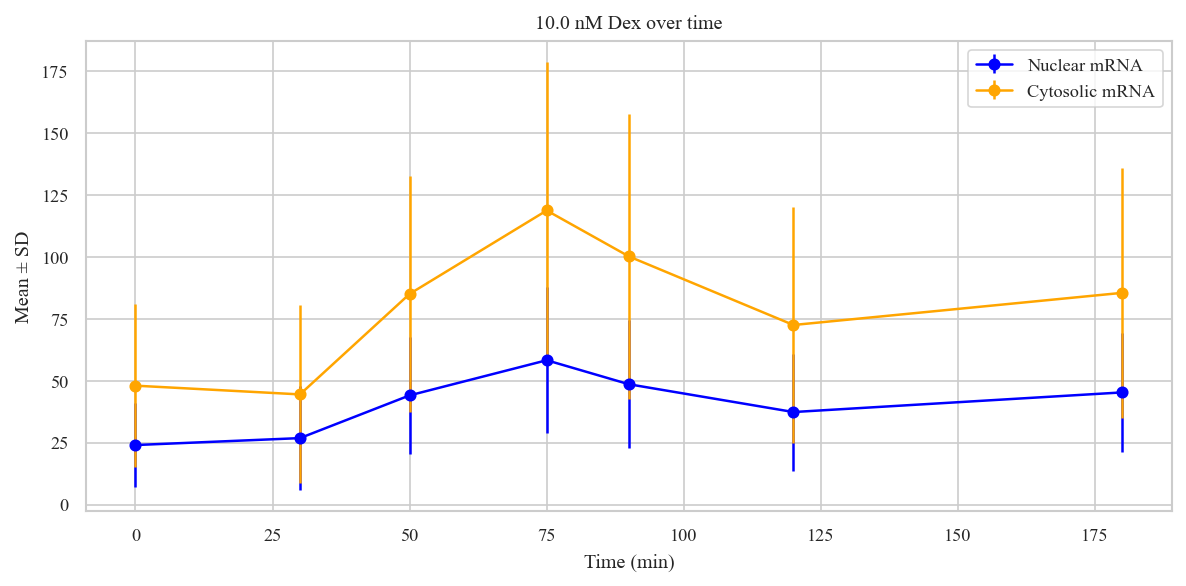

In [9]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_K_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '70' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 70
prefix = rep_prefix * (10 ** num_digits)  

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_K'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica L 3hr 100nM time-concentration sweep R2`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_time_conc_sweep_0min_050223_R3.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_time_conc_sweep_0min_050223_R3.h5 -> Analysis_DUSP1_L_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230614/DUSP1_Dex_10nM_30min_050223_R3_redo.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230614/DUSP1_Dex_10nM_30min_050223_R3_redo.h5 -> Analysis_DUSP1_L_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230608/DUSP1_Dex_10nM_120min_050223_R3.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230608/DUSP1_Dex_10nM_120min_050223_R3.h5 -> Analysis_DUSP1_L_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230605/DUSP1_Dex_300pM_90min_050223_R3.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Er

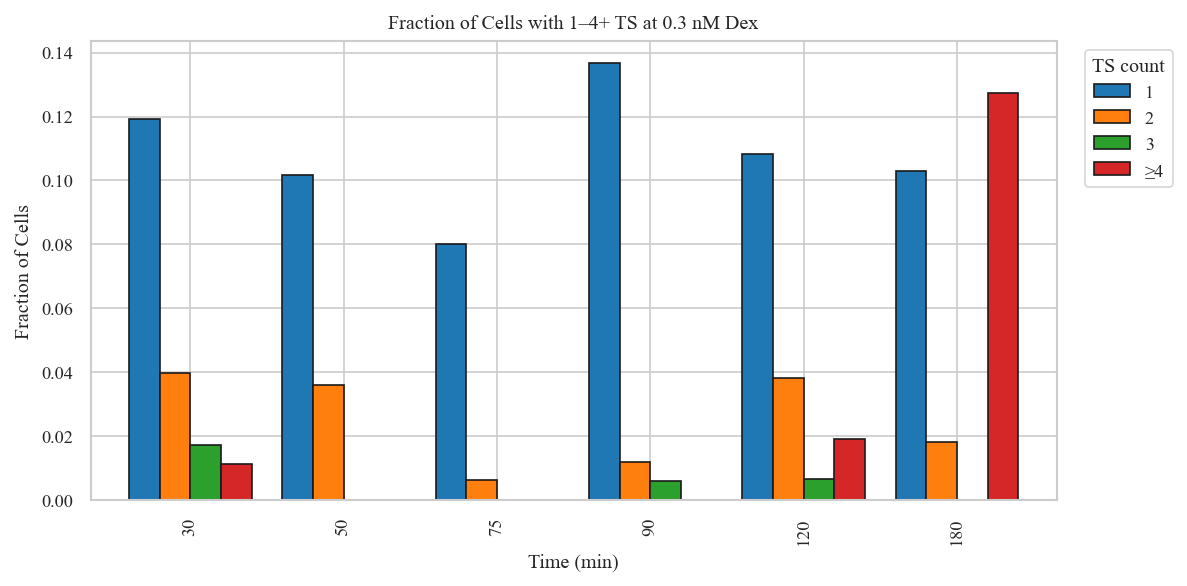

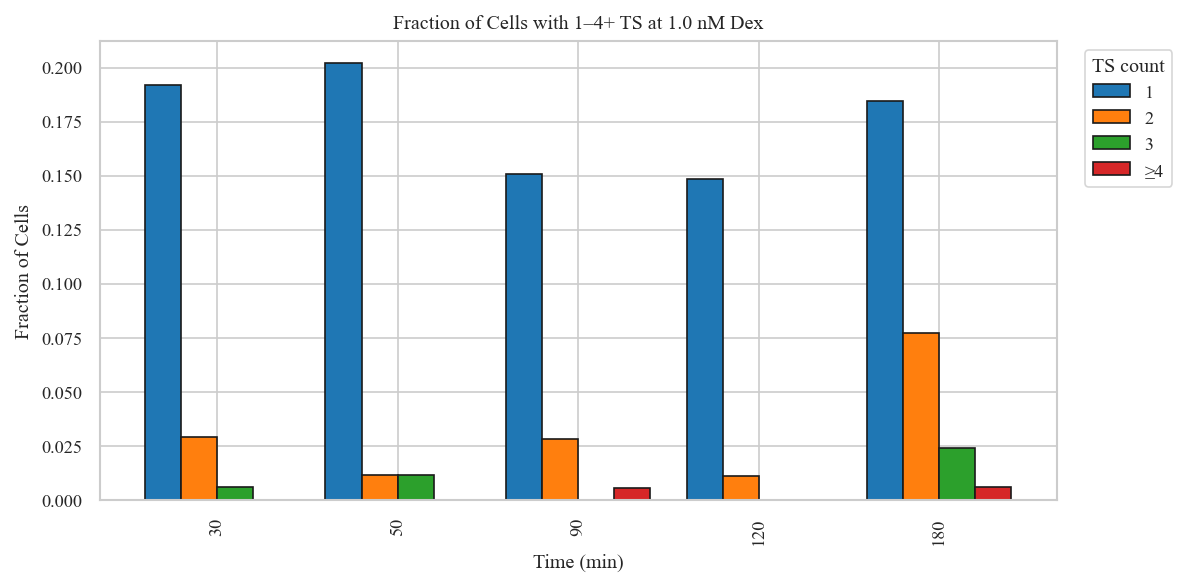

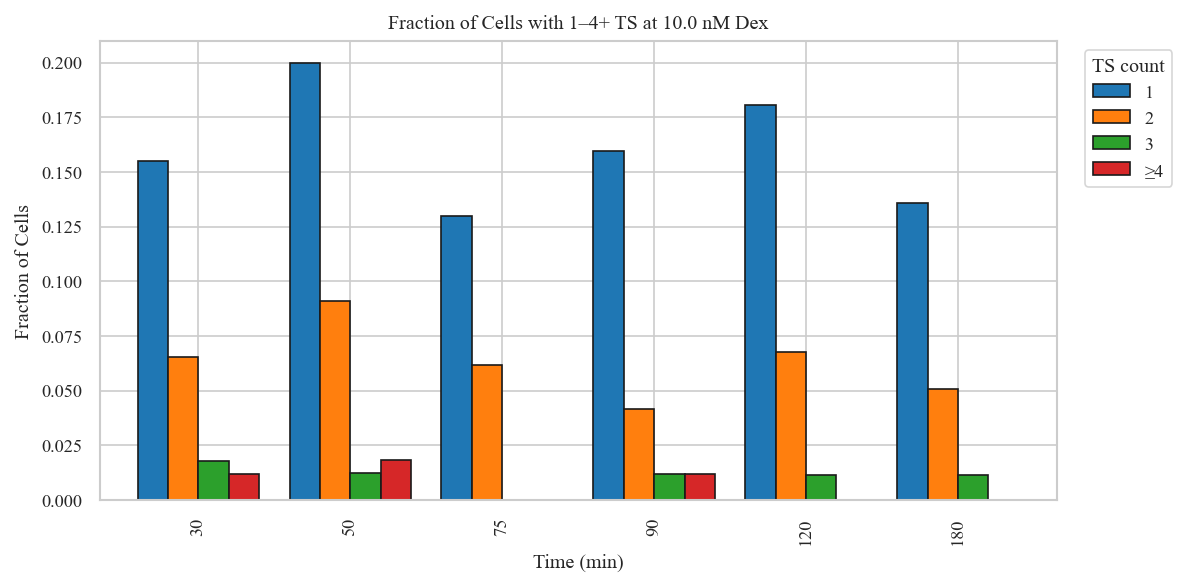

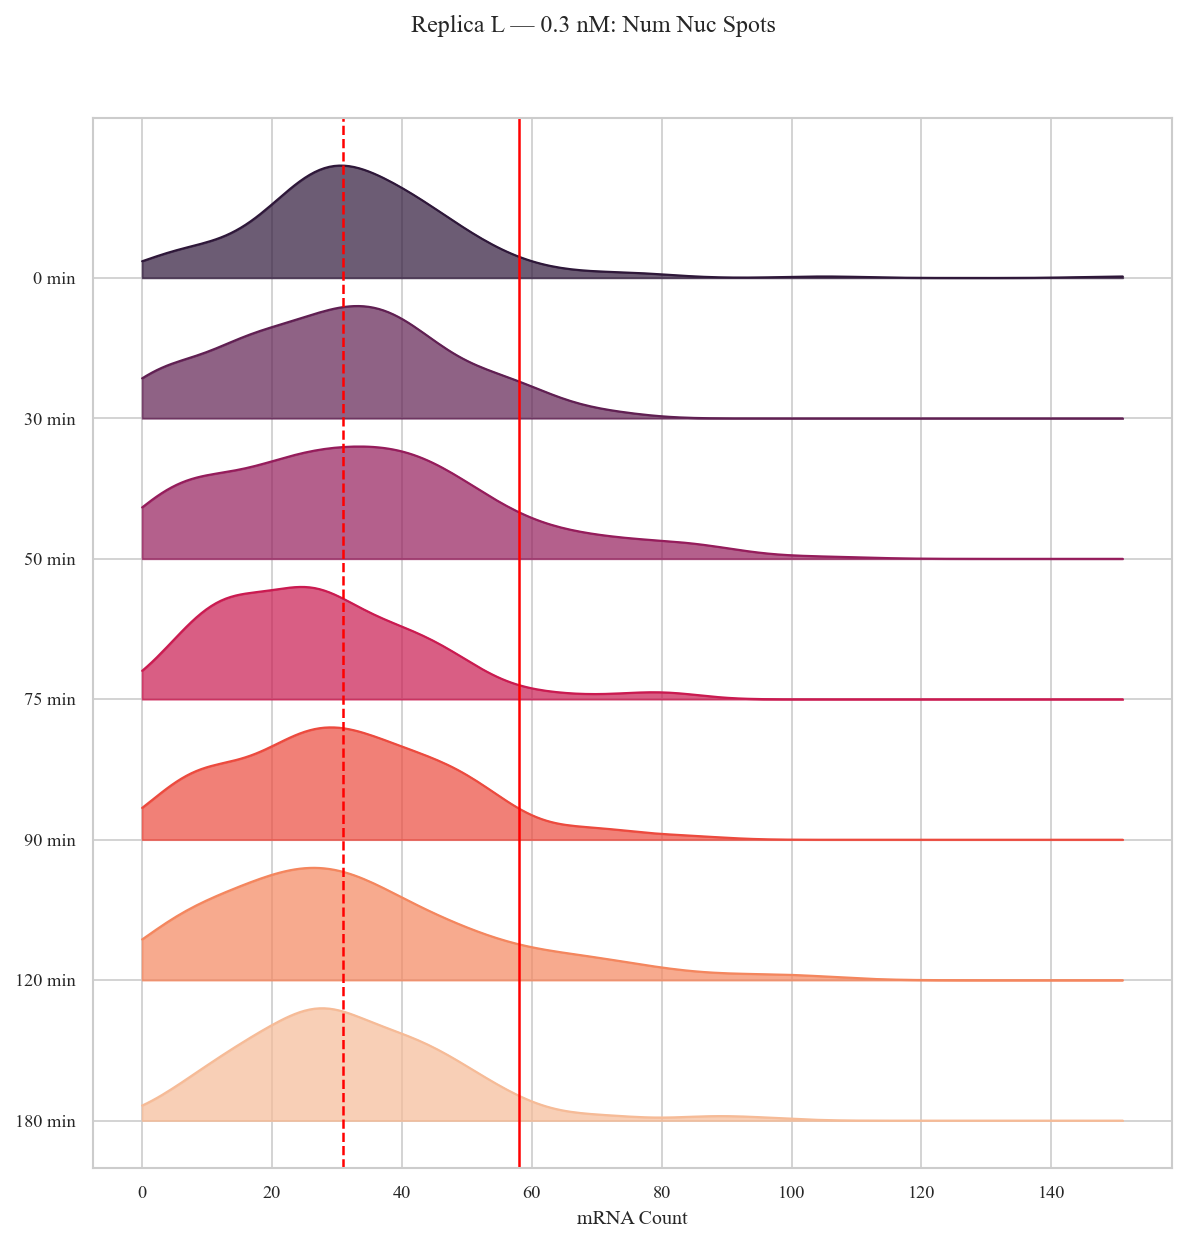

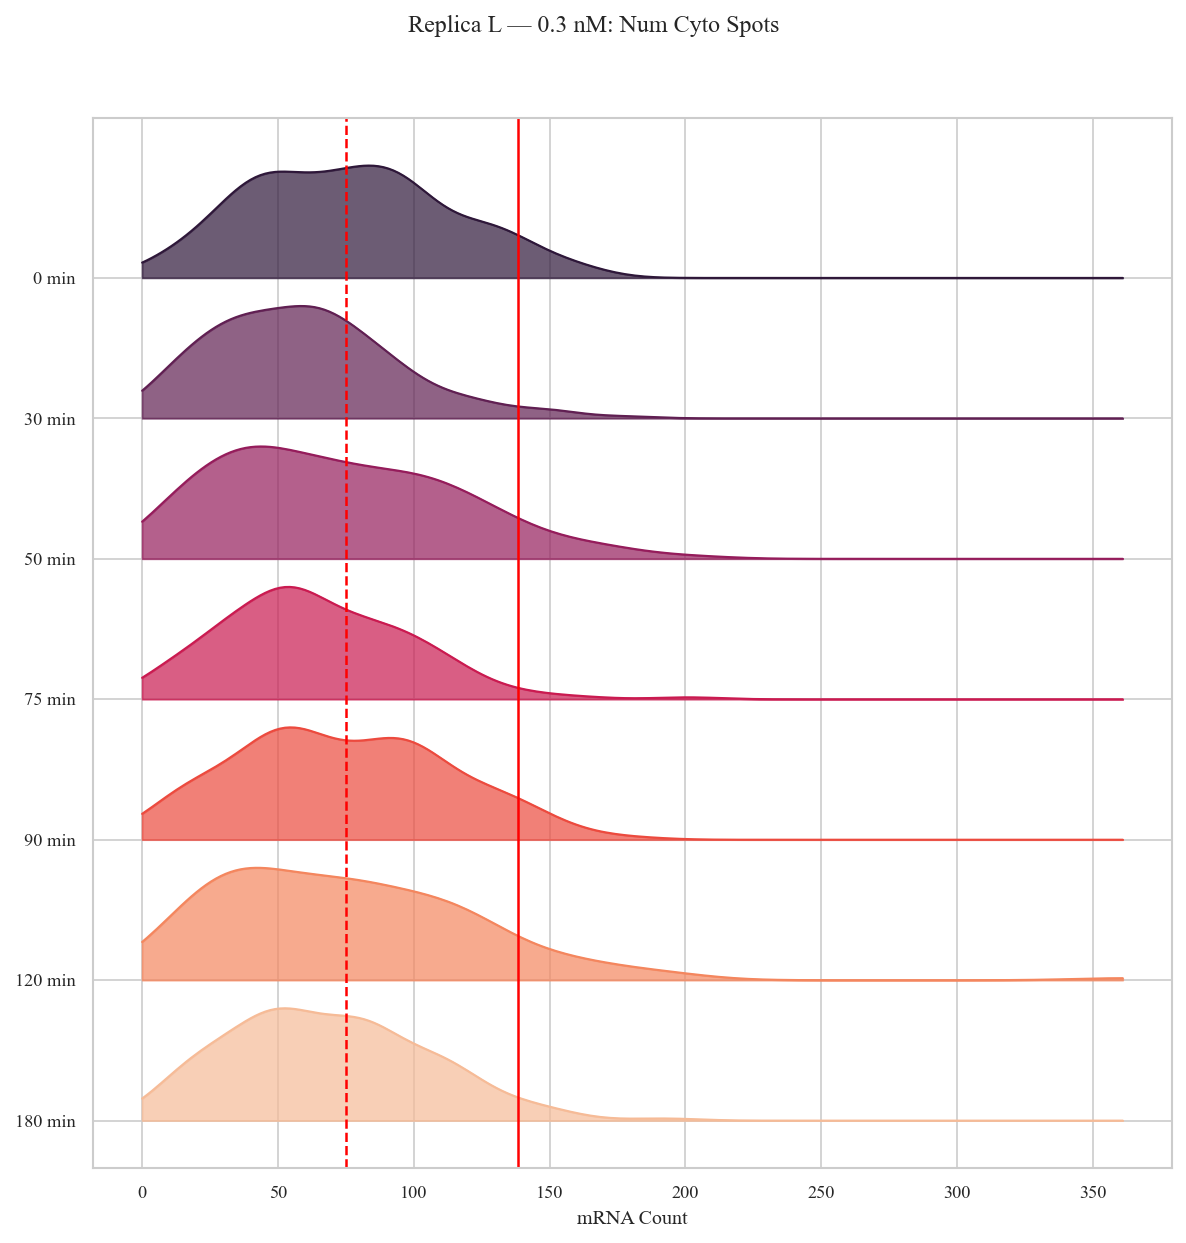

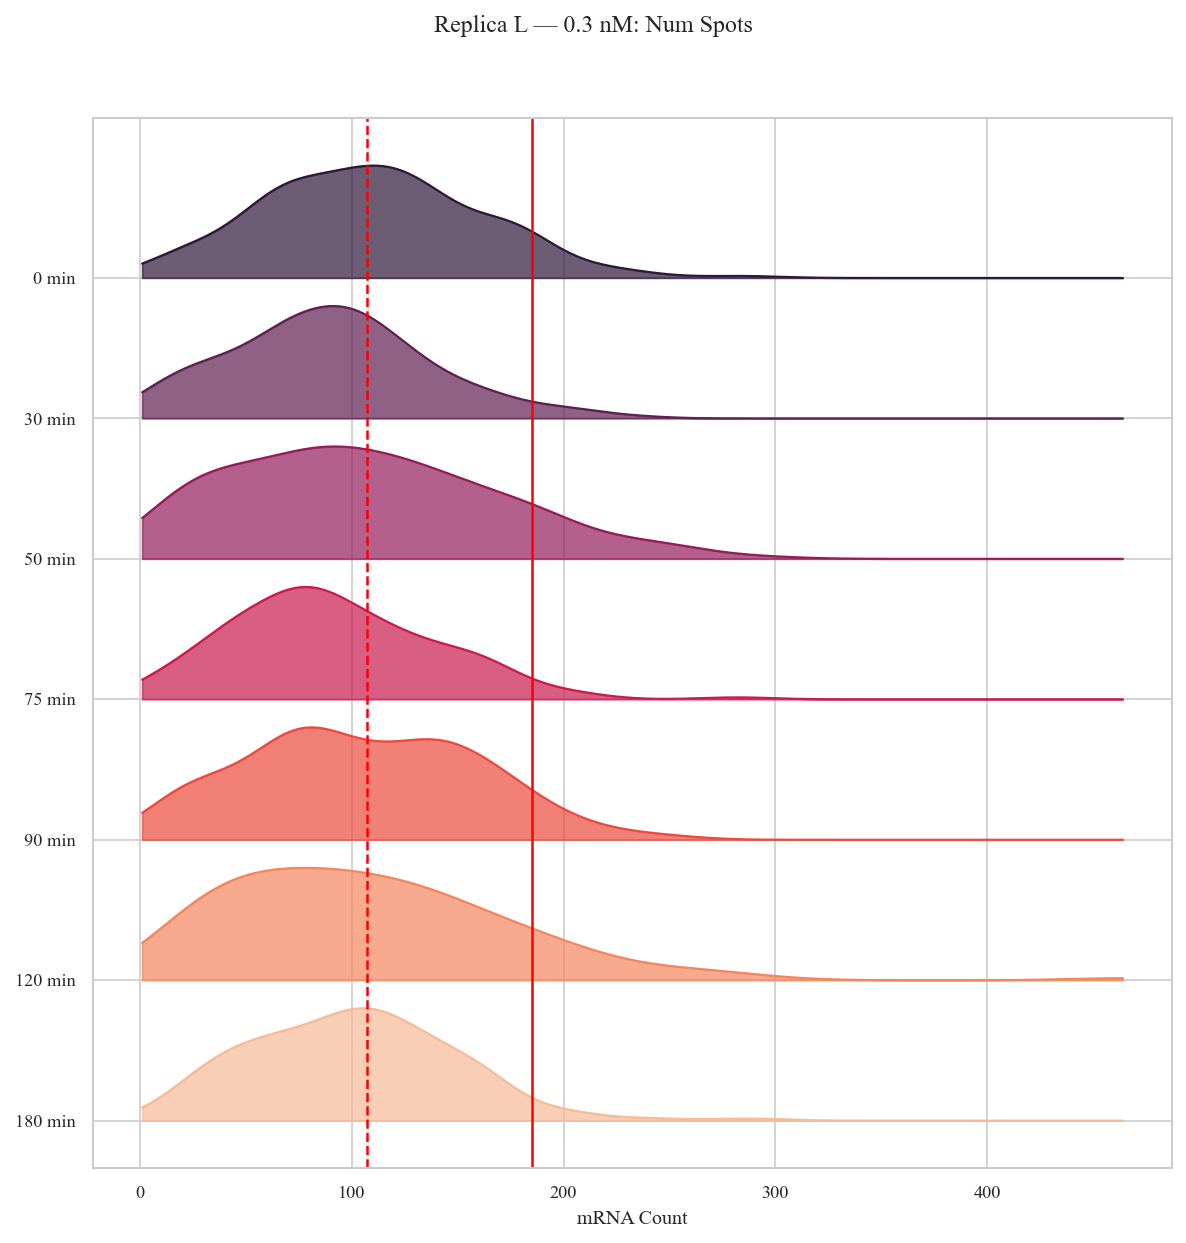

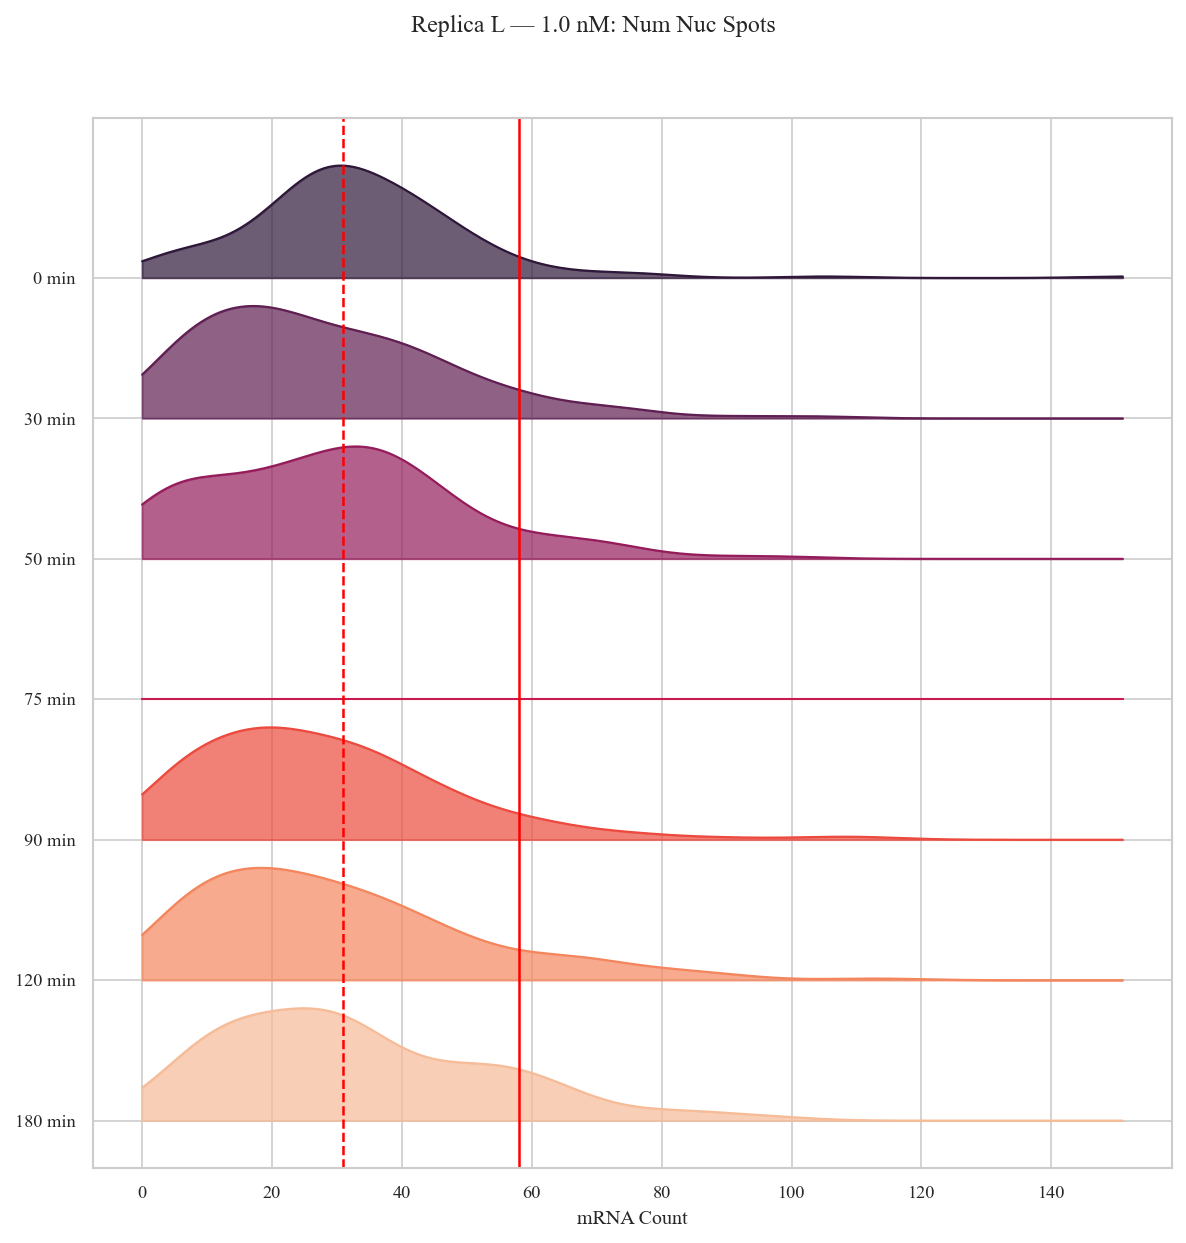

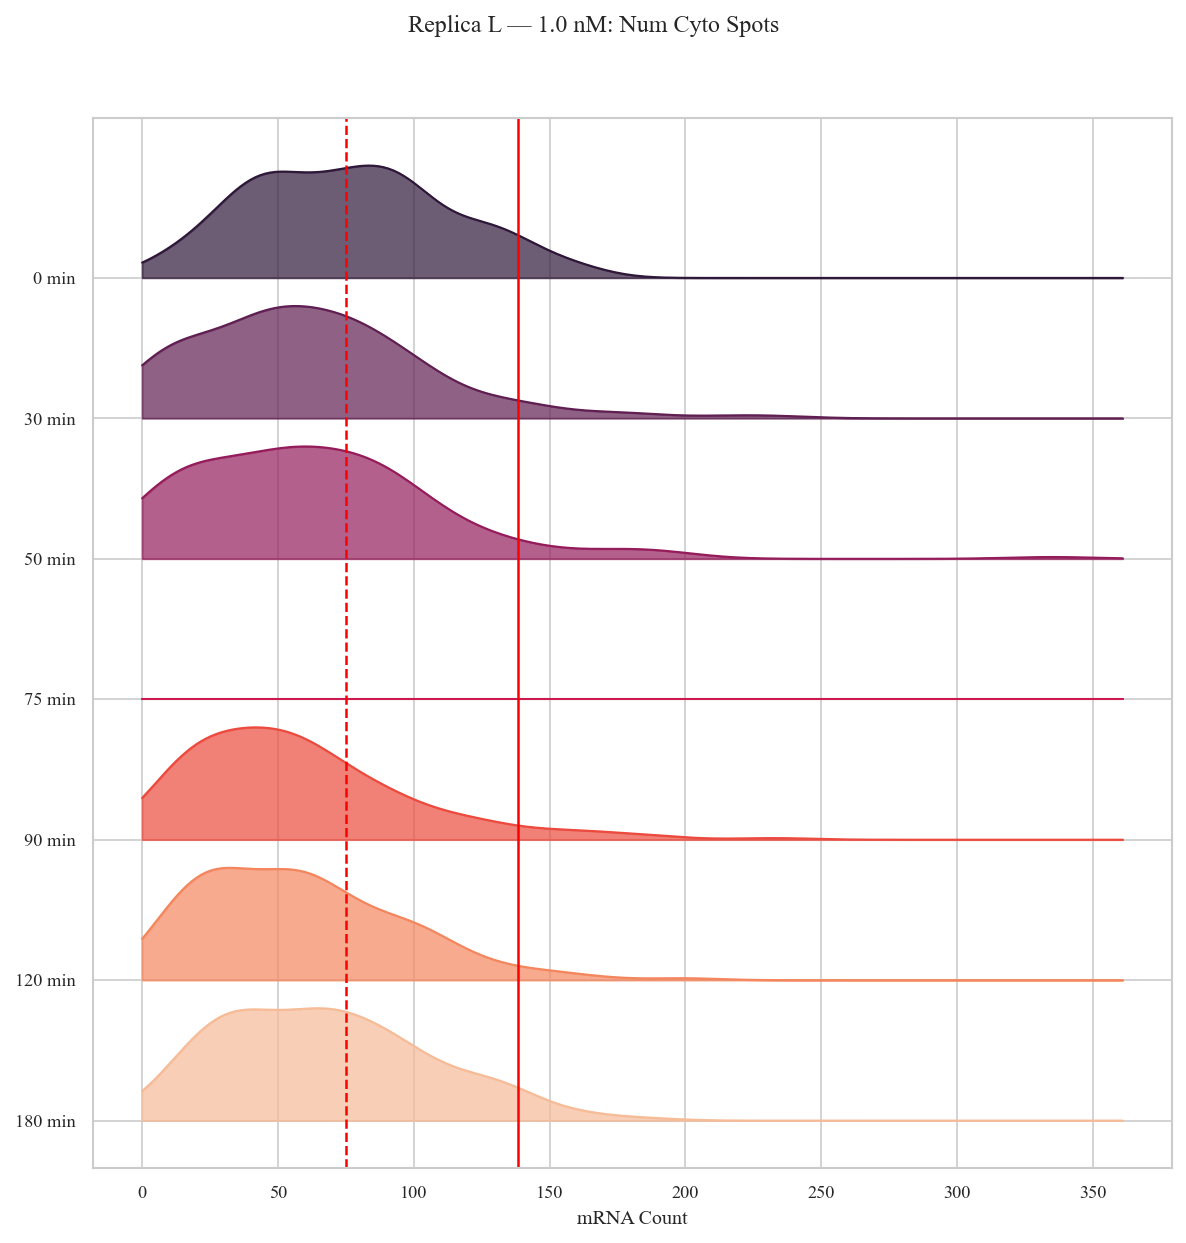

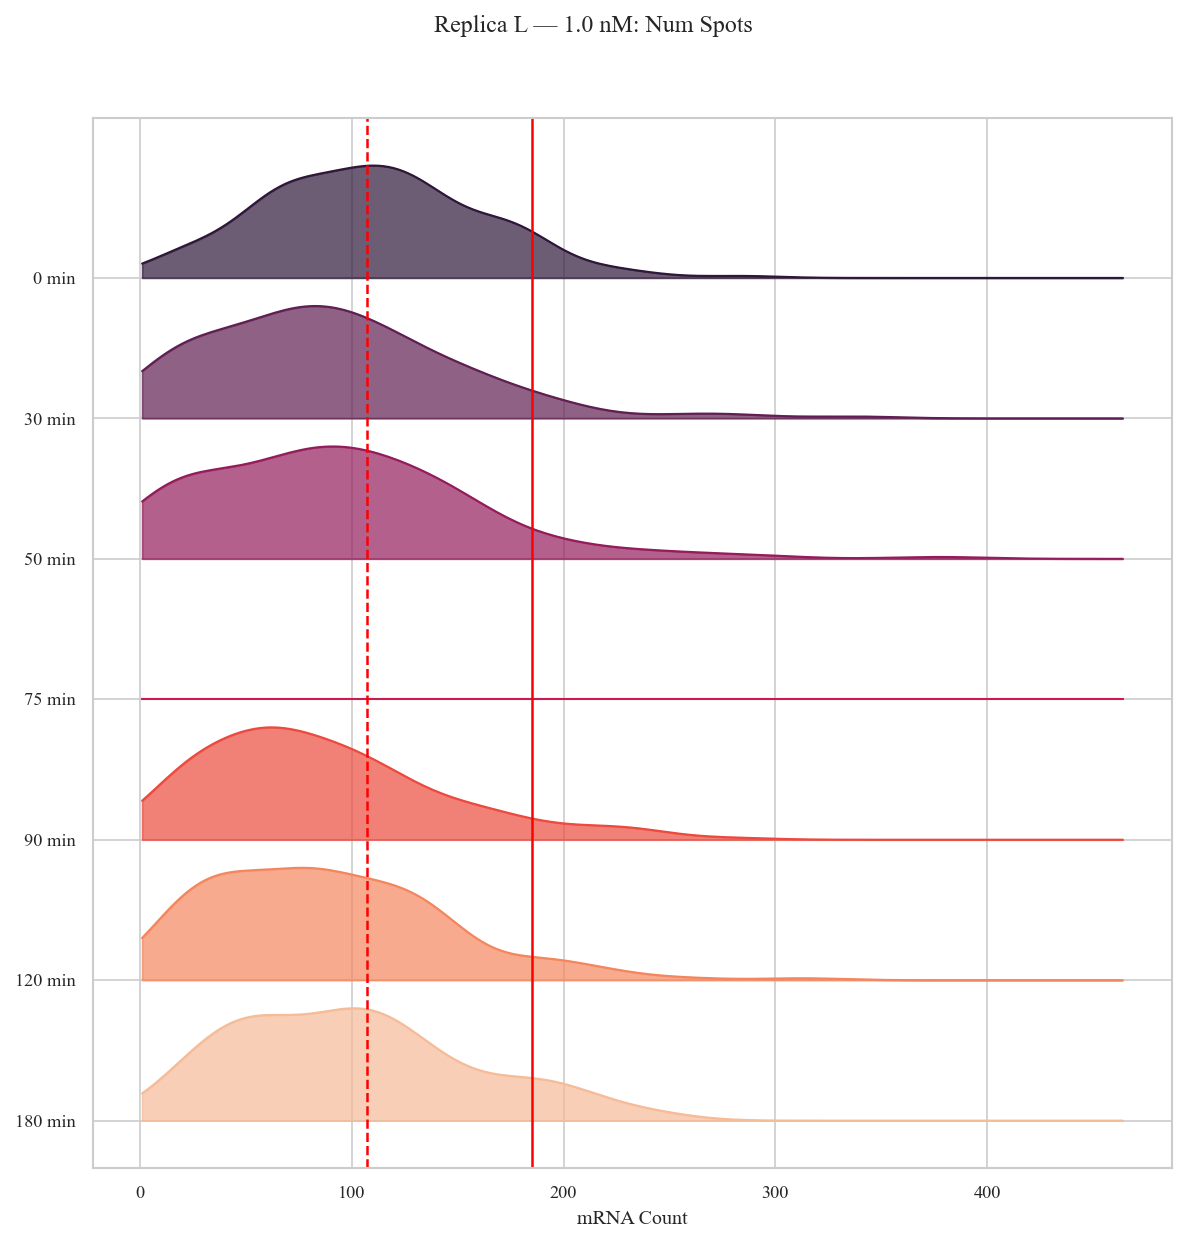

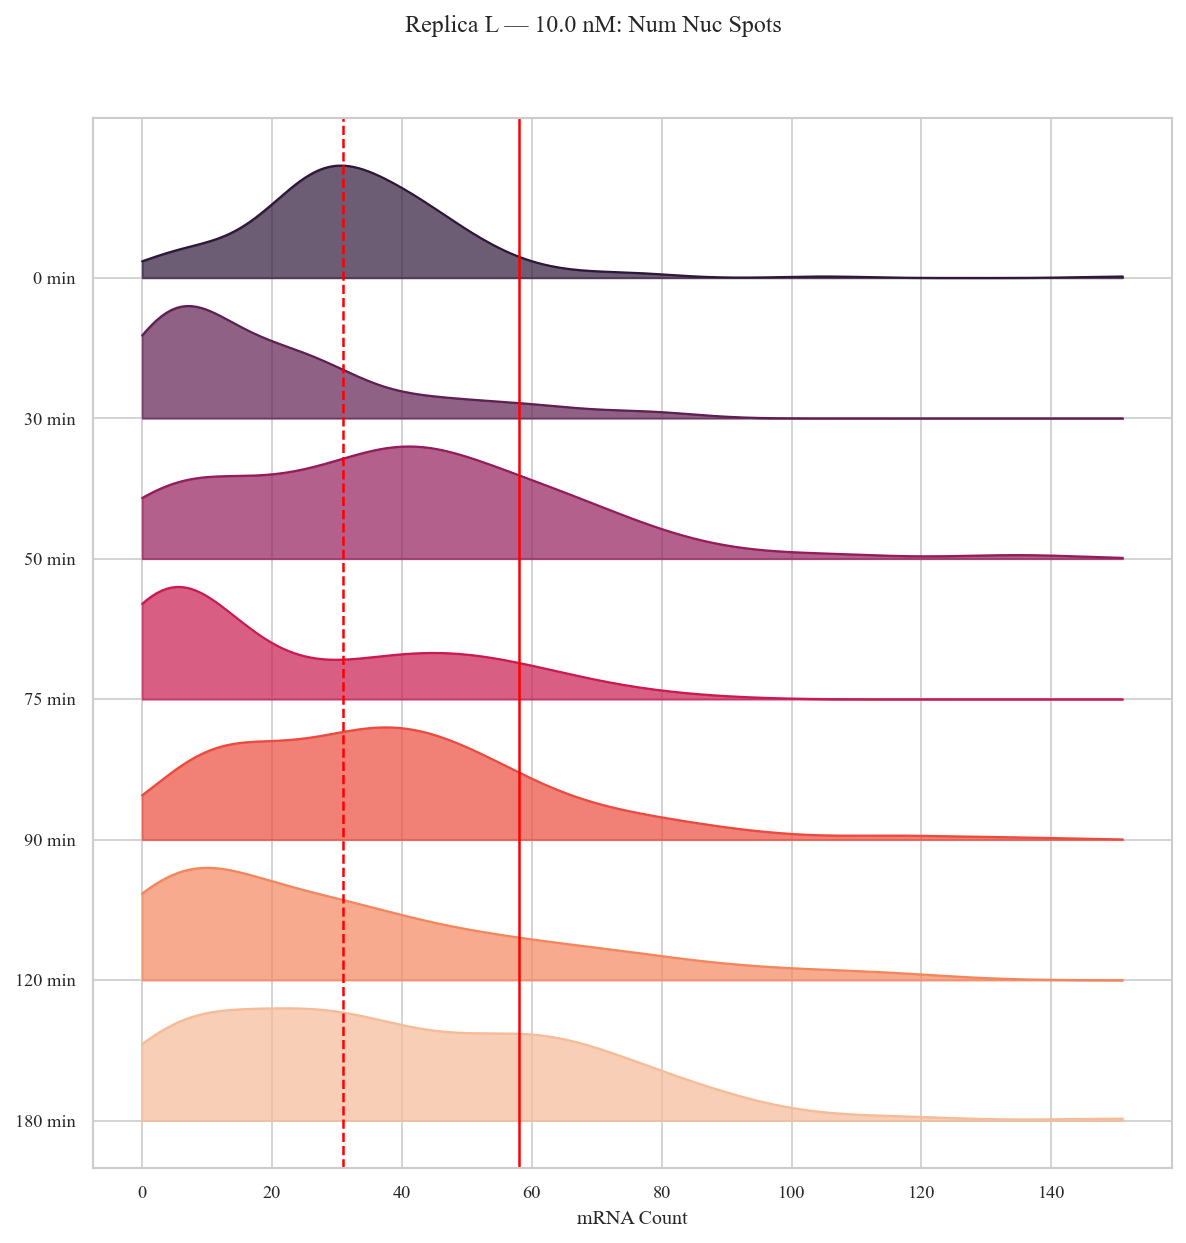

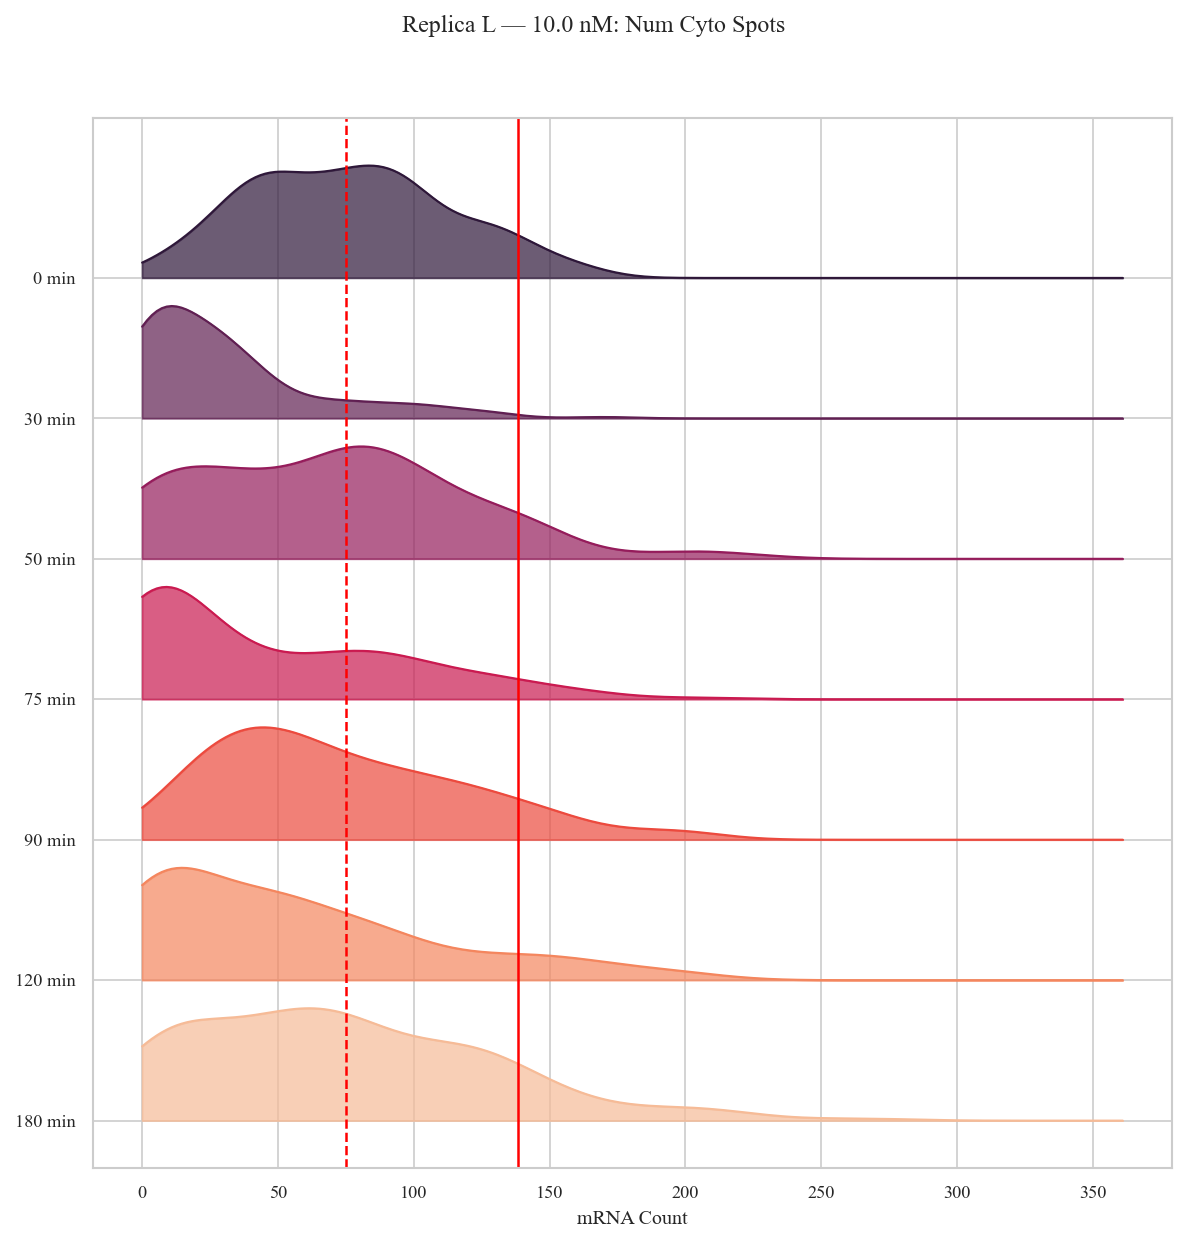

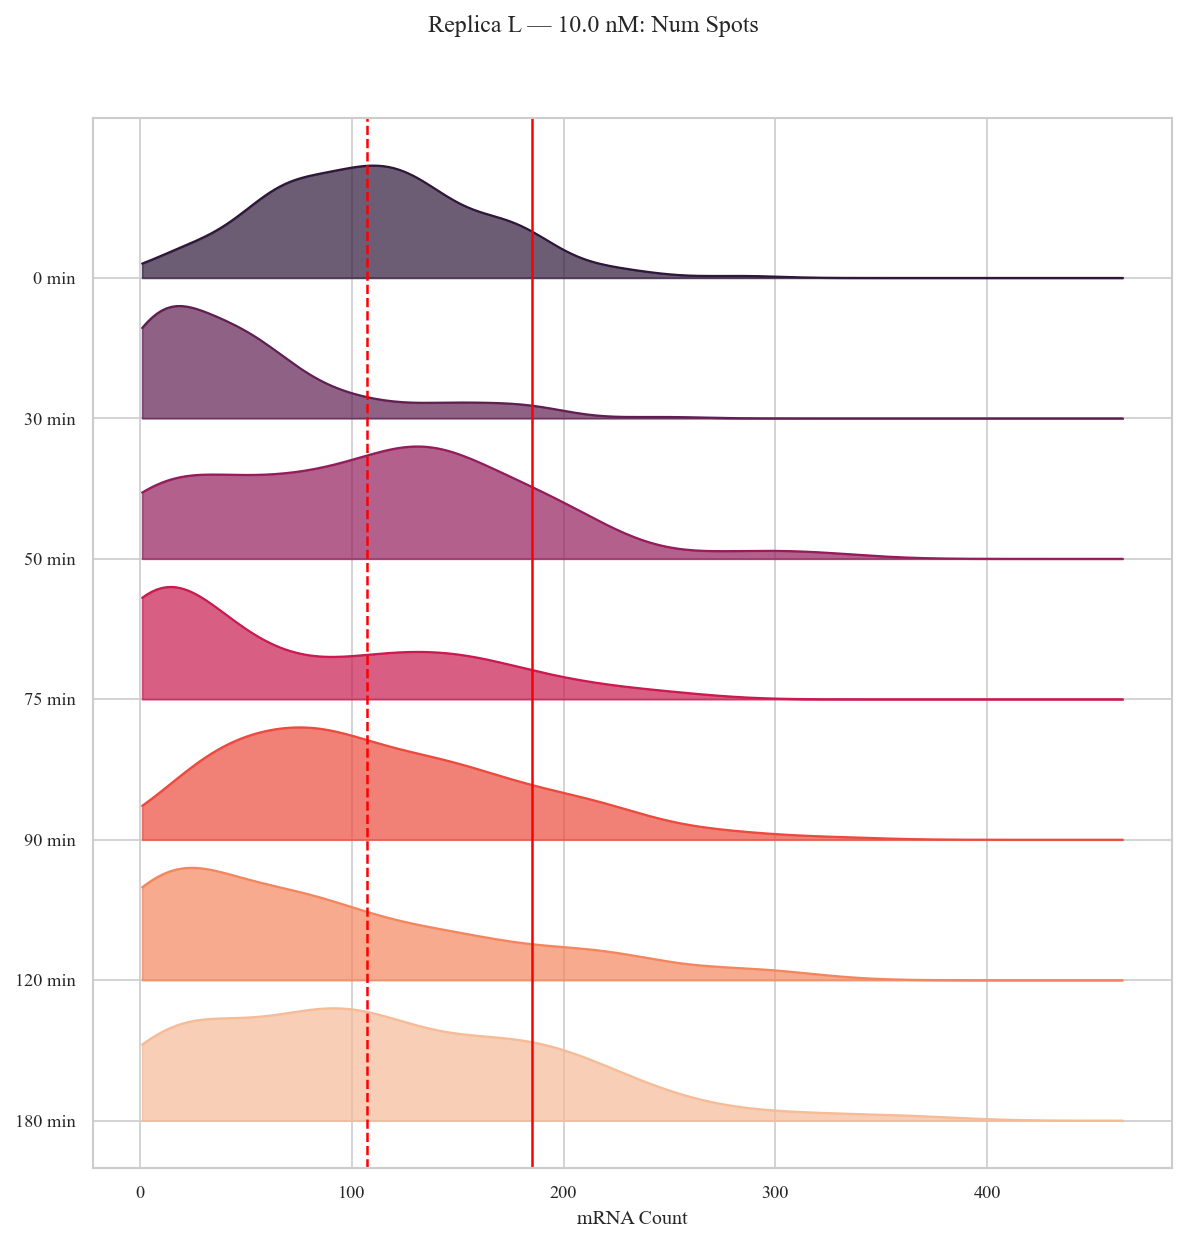

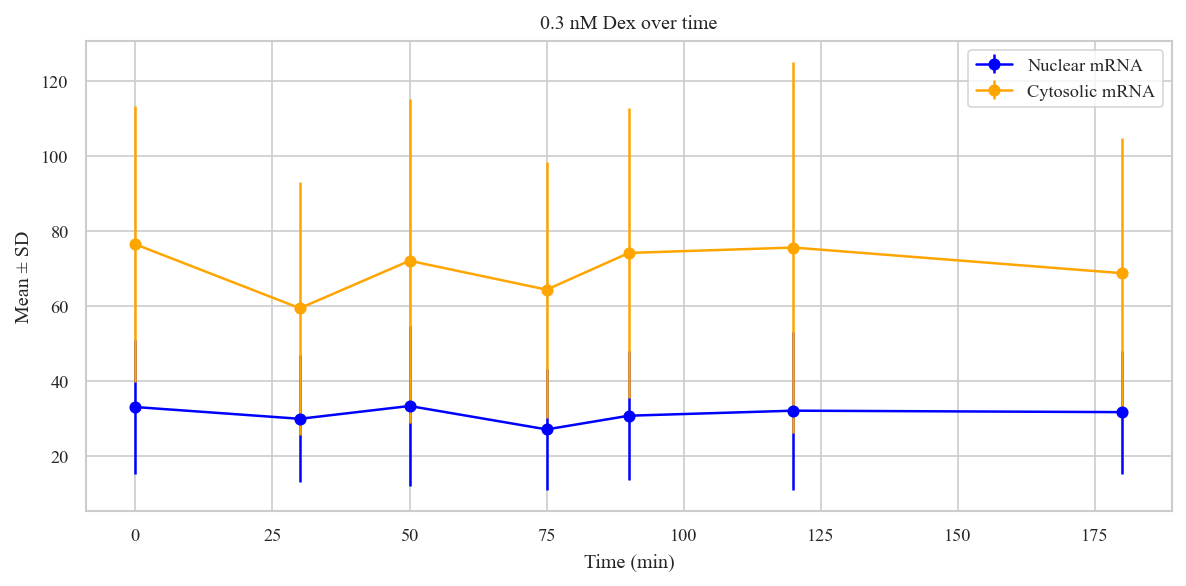

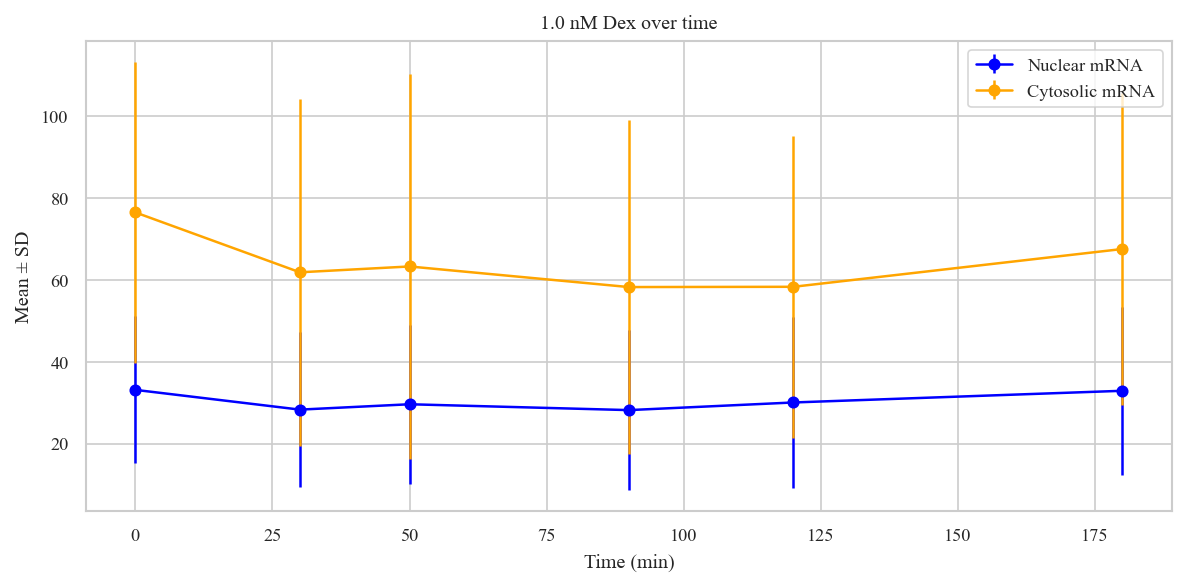

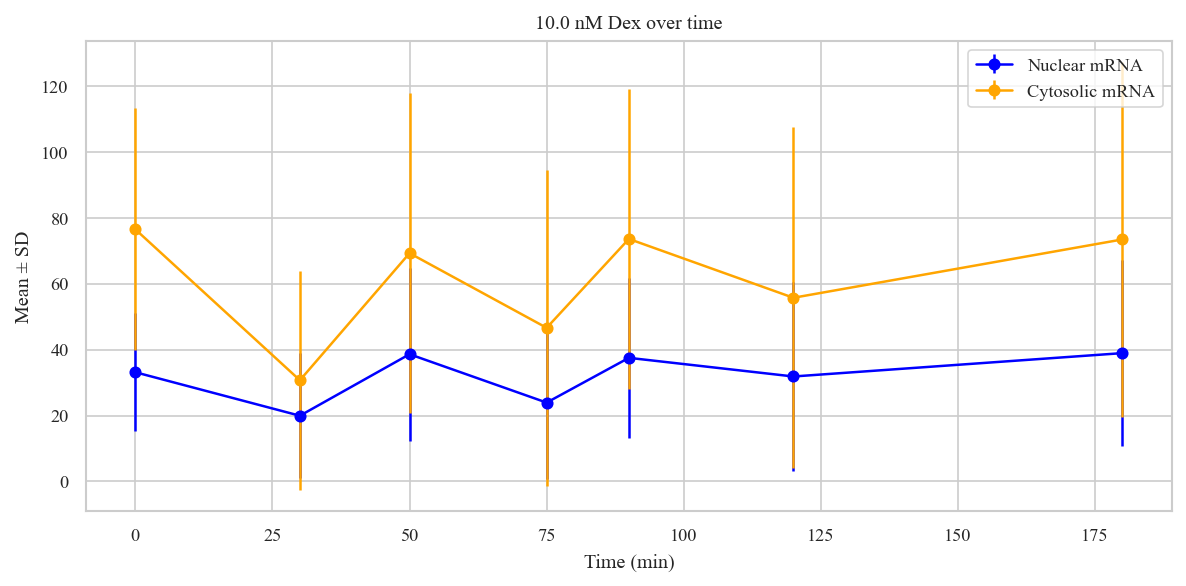

In [10]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_L_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '80' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 80
prefix = rep_prefix * (10 ** num_digits) 

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_L'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots()

**`DUSP1 Replica G 75min Concentration sweep R1`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_100pM_75min_060322.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_100pM_75min_060322.h5 -> Analysis_DUSP1_CS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220628/DUSP1_conc_sweep_0min_060322.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220628/DUSP1_conc_sweep_0min_060322.h5 -> Analysis_DUSP1_CS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220705/DUSP1_conc_sweep_10nM_75min_060322.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220705/DUSP1_conc_sweep_10nM_75min_060322.h5 -> Analysis_DUSP1_CS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_1pM_75min_060322.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eri

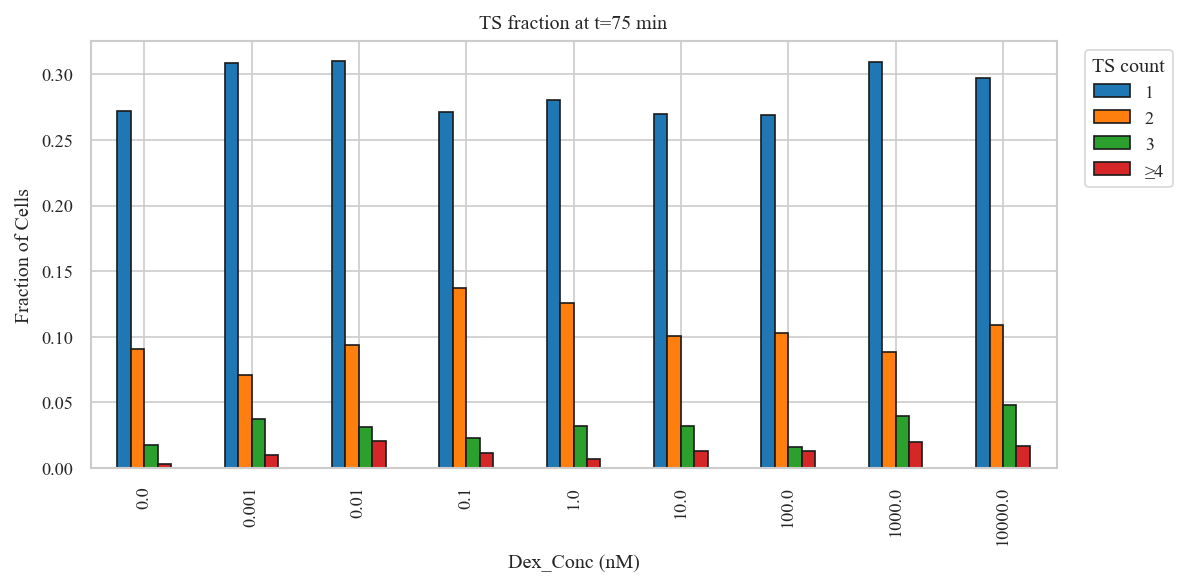

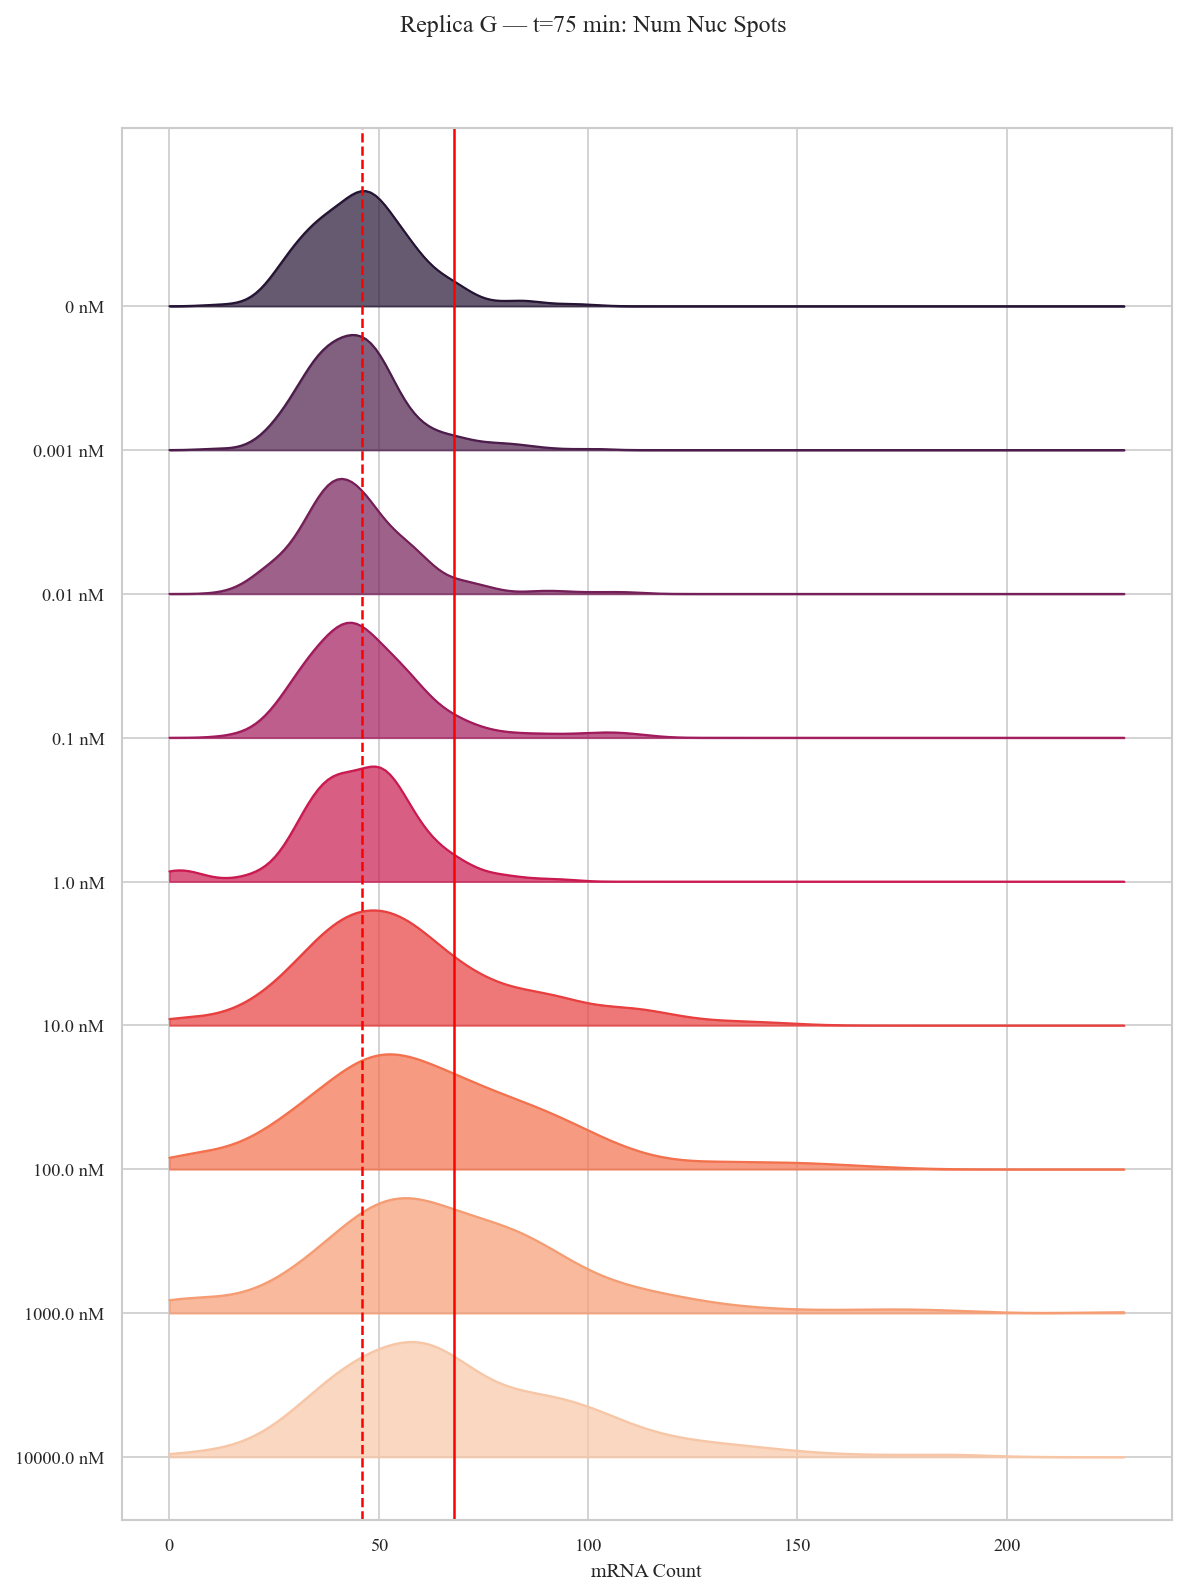

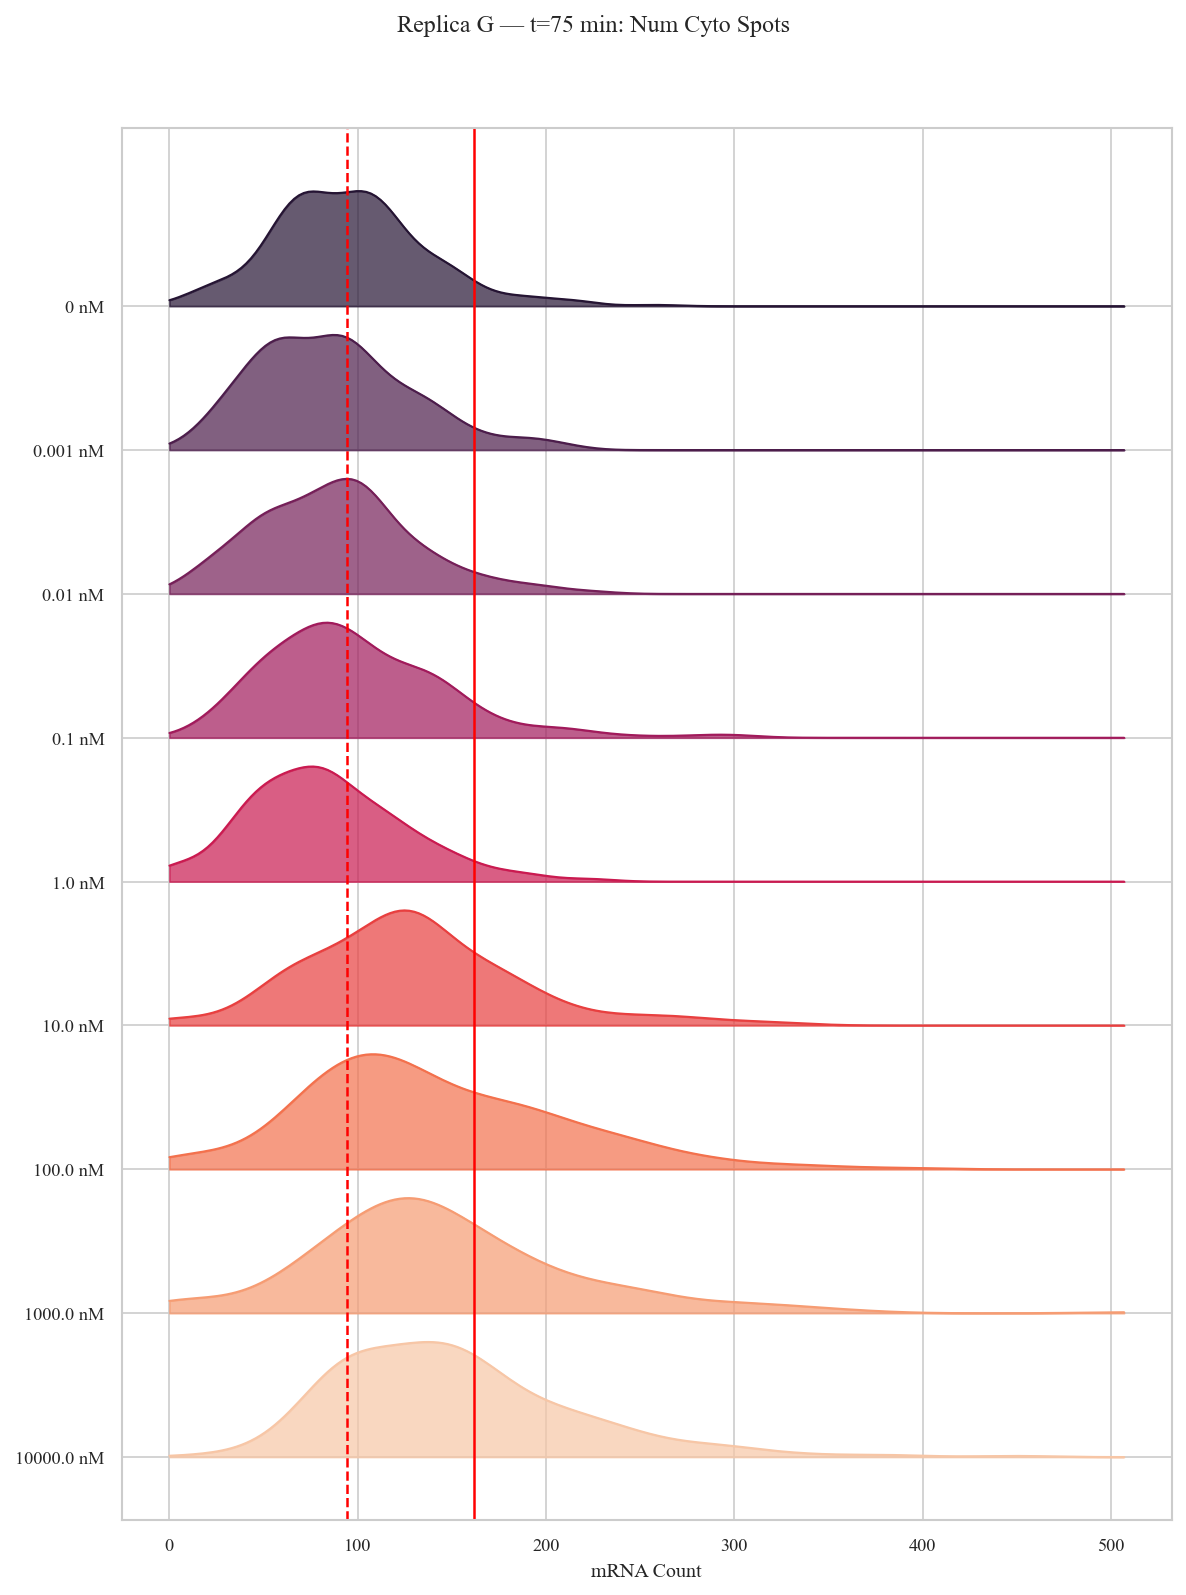

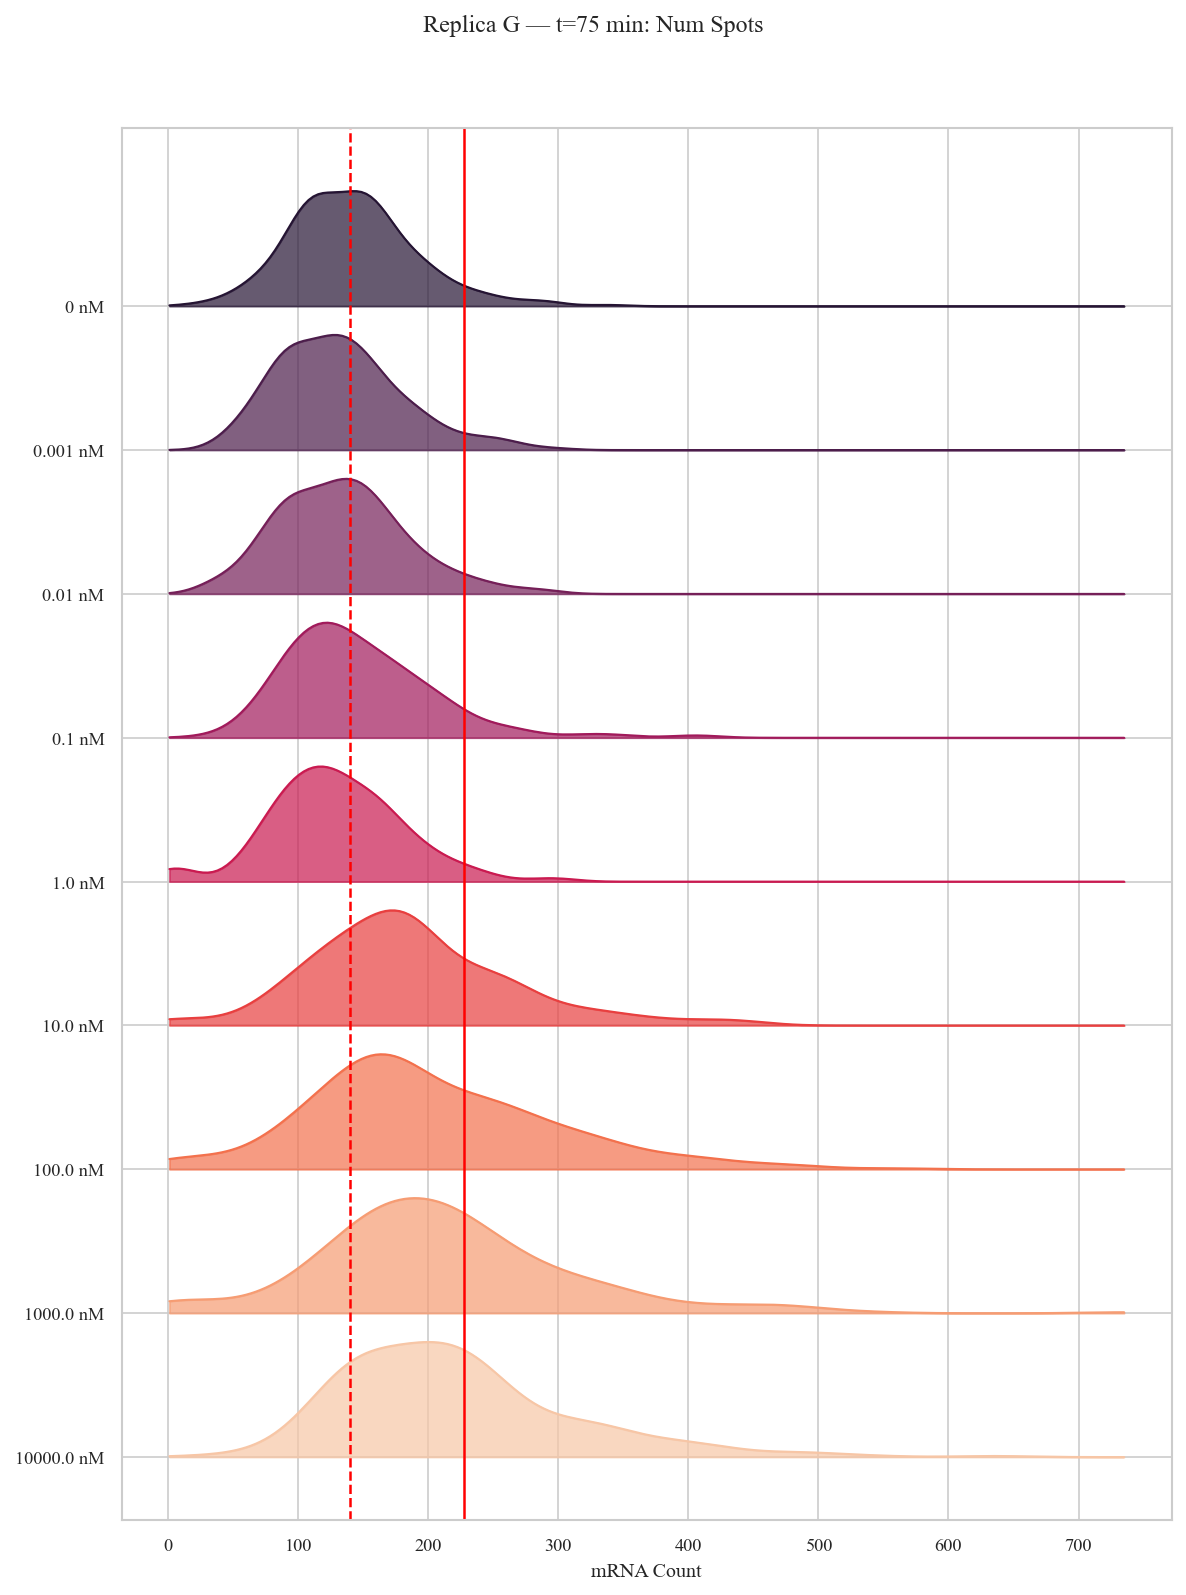

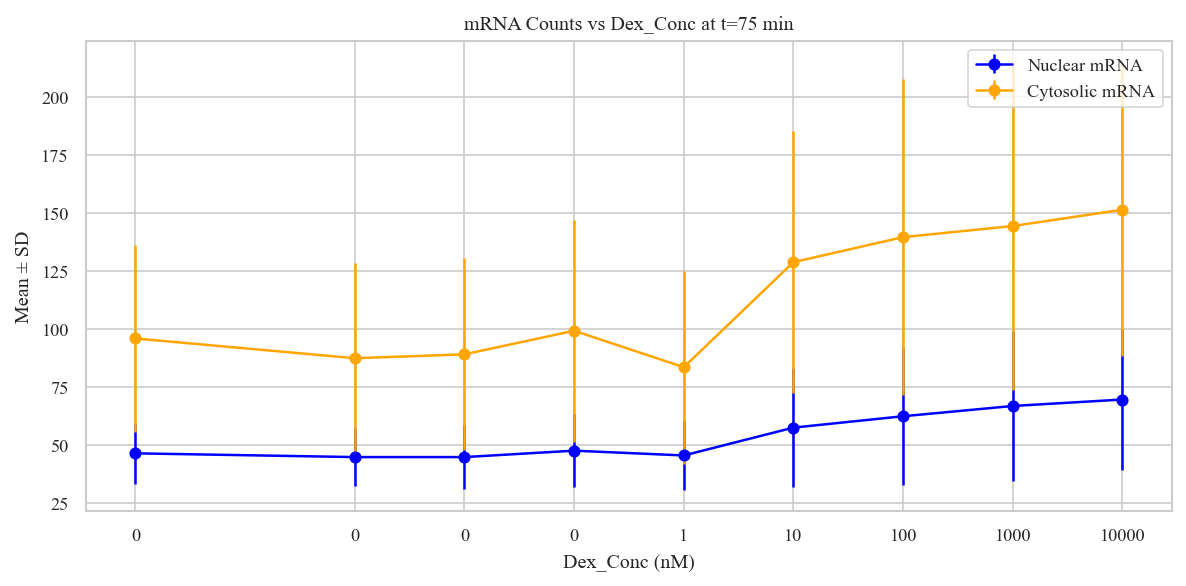

In [11]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_CS_R1_Final3')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '80' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 90
prefix = rep_prefix * (10 ** num_digits) 

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_G'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots(mode='conc', save_dir=save_dir)

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_10pM_75min_071422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_10pM_75min_071422.h5 -> Analysis_DUSP1_H_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220718/DUSP1_conc_sweep_R2_0min_071422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220718/DUSP1_conc_sweep_R2_0min_071422.h5 -> Analysis_DUSP1_H_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_100pM_75min_071422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_100pM_75min_071422.h5 -> Analysis_DUSP1_H_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_1pM_75min_071422.h5
Reading DataFrame from: /Volumes/share/smFISH_imag

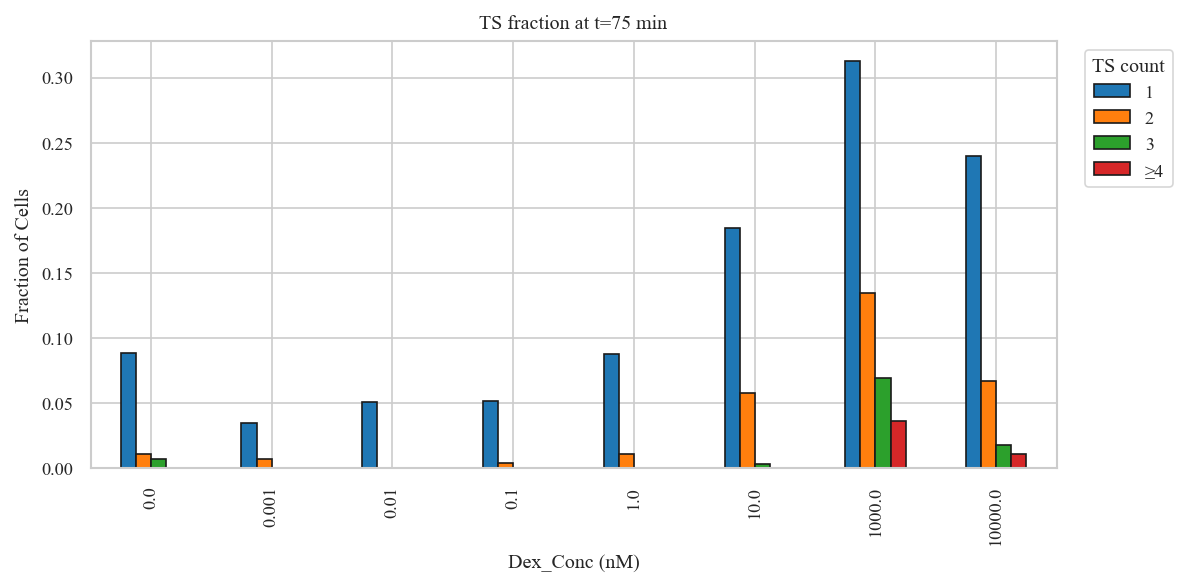

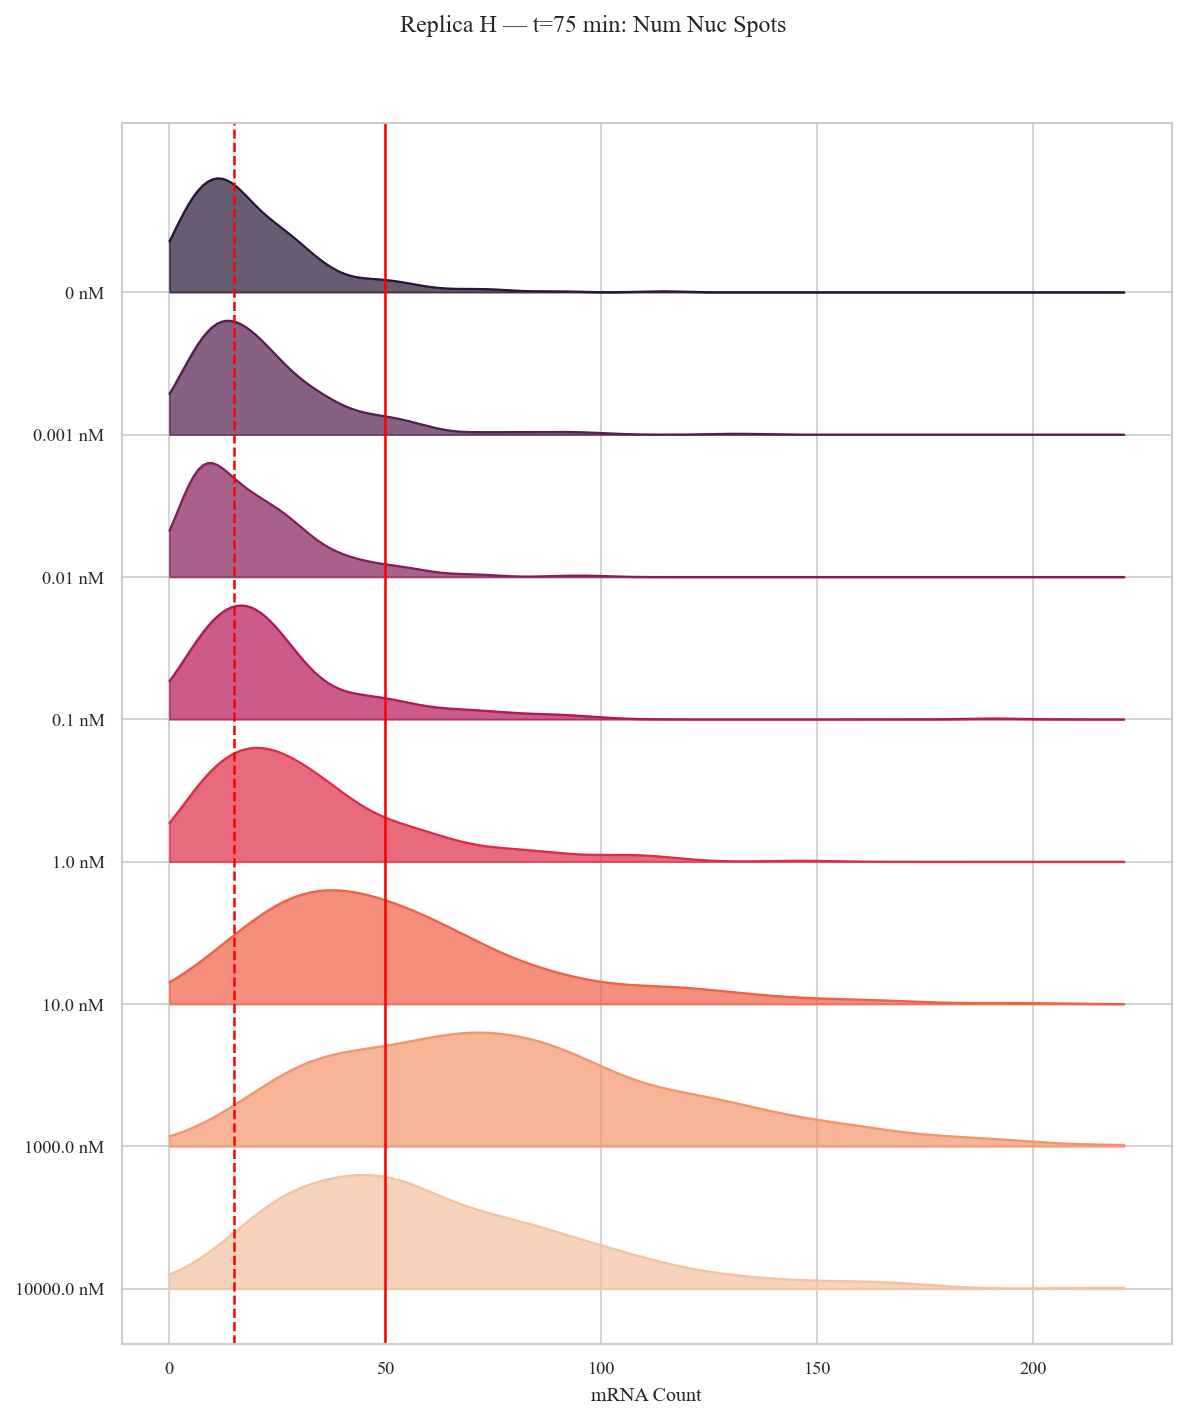

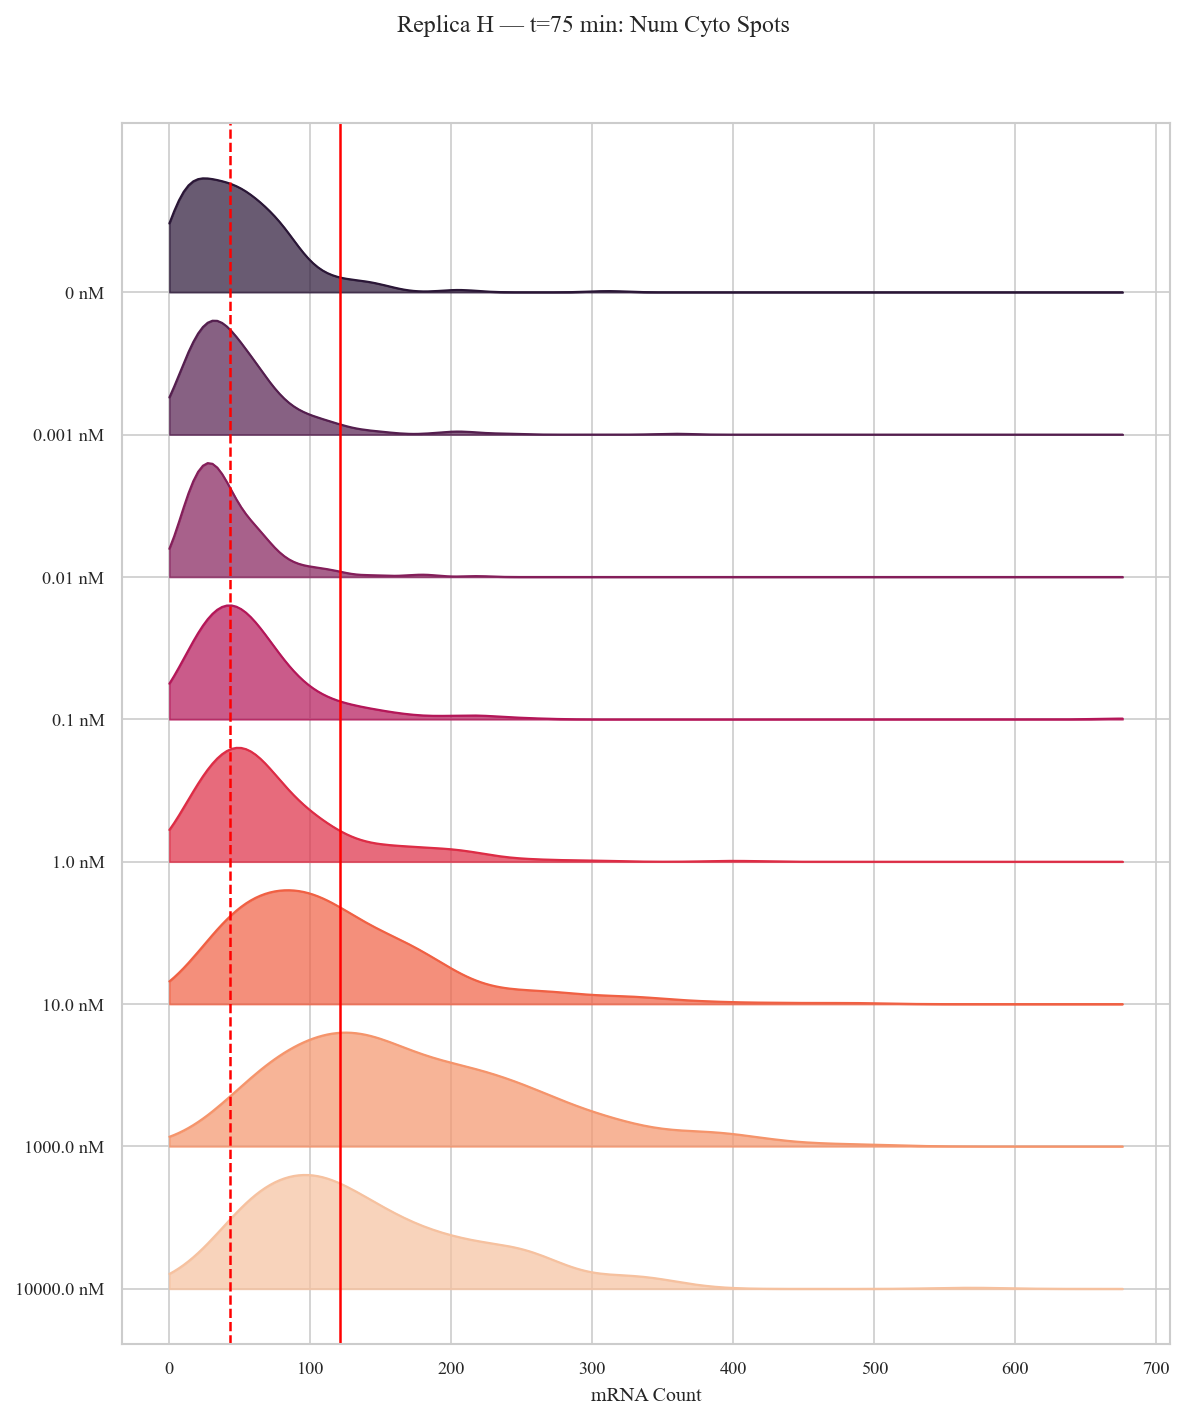

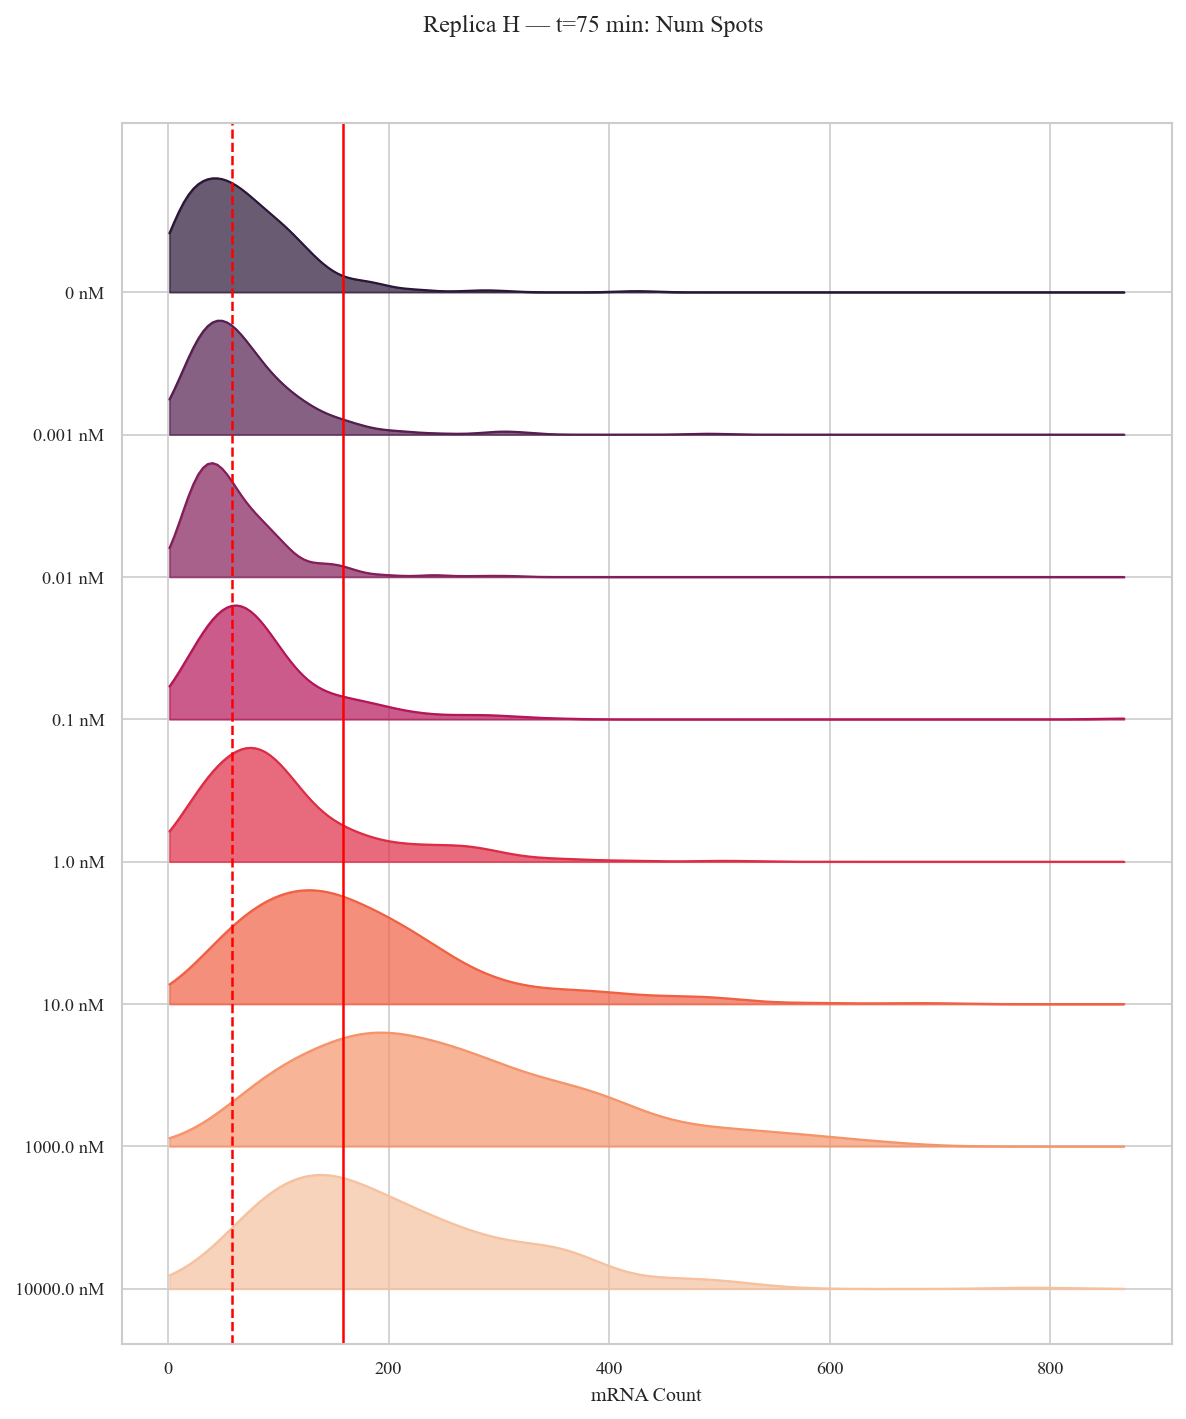

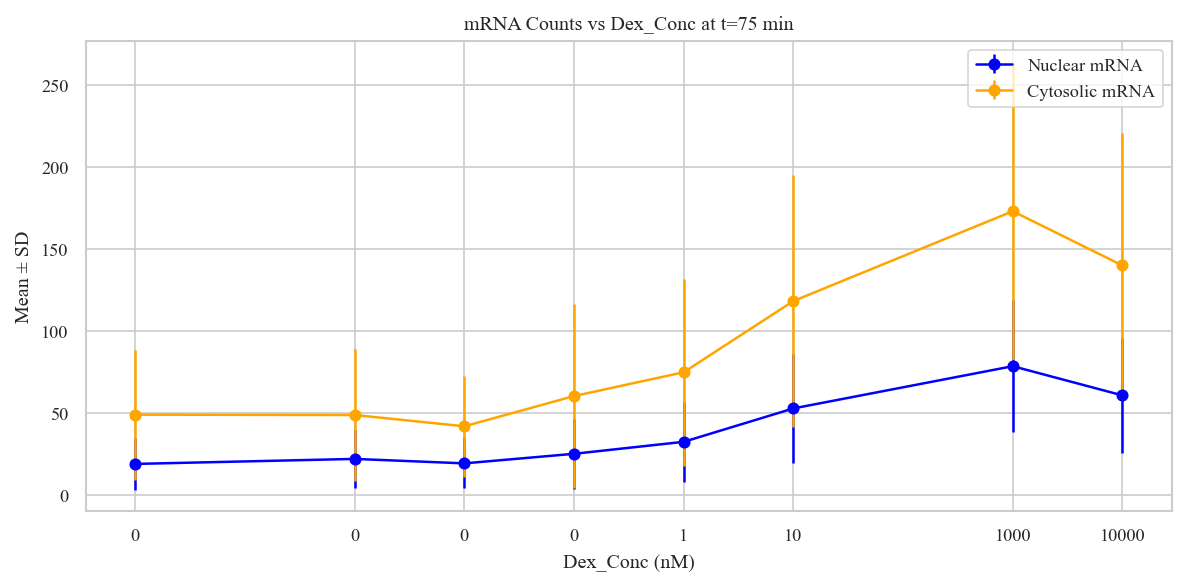

In [12]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_H_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '80' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 110
prefix = rep_prefix * (10 ** num_digits) 

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_H'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots(mode='conc', save_dir=save_dir)

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221011/DUSP1_Dex_Sweep_1uM_75min_092022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221011/DUSP1_Dex_Sweep_1uM_75min_092022.h5 -> Analysis_DUSP1_I_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_10pM_75min_092022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_10pM_75min_092022.h5 -> Analysis_DUSP1_I_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221006/DUSP1_Dex_Sweep_1nM_75min_092022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221006/DUSP1_Dex_Sweep_1nM_75min_092022.h5 -> Analysis_DUSP1_I_Final_2025-03-05/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221006/DUSP1_Dex_Sweep_100nM_75min_092022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_image

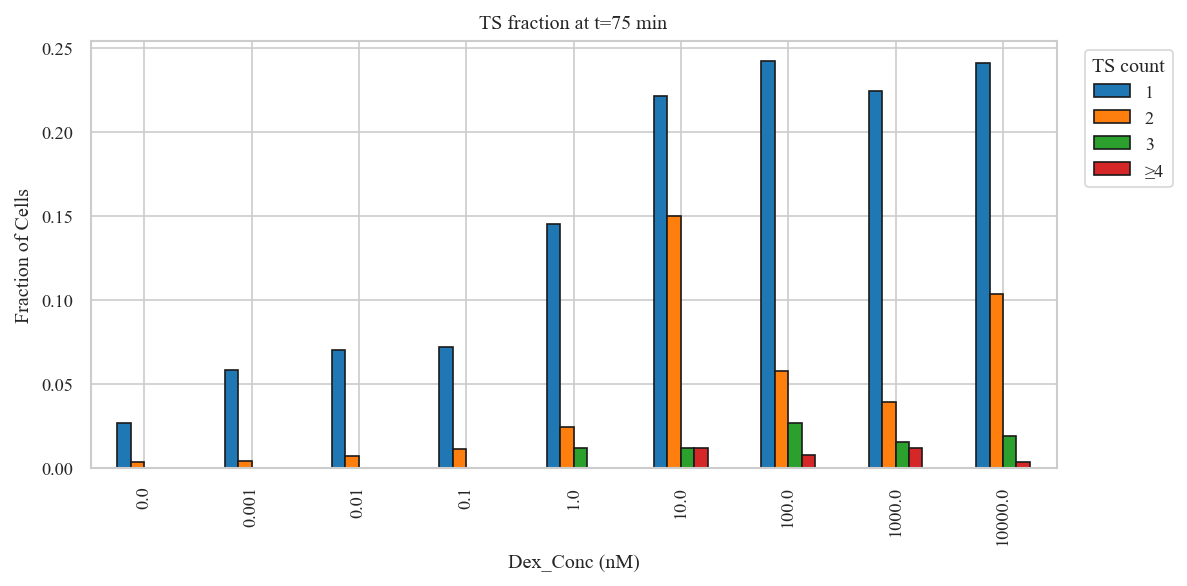

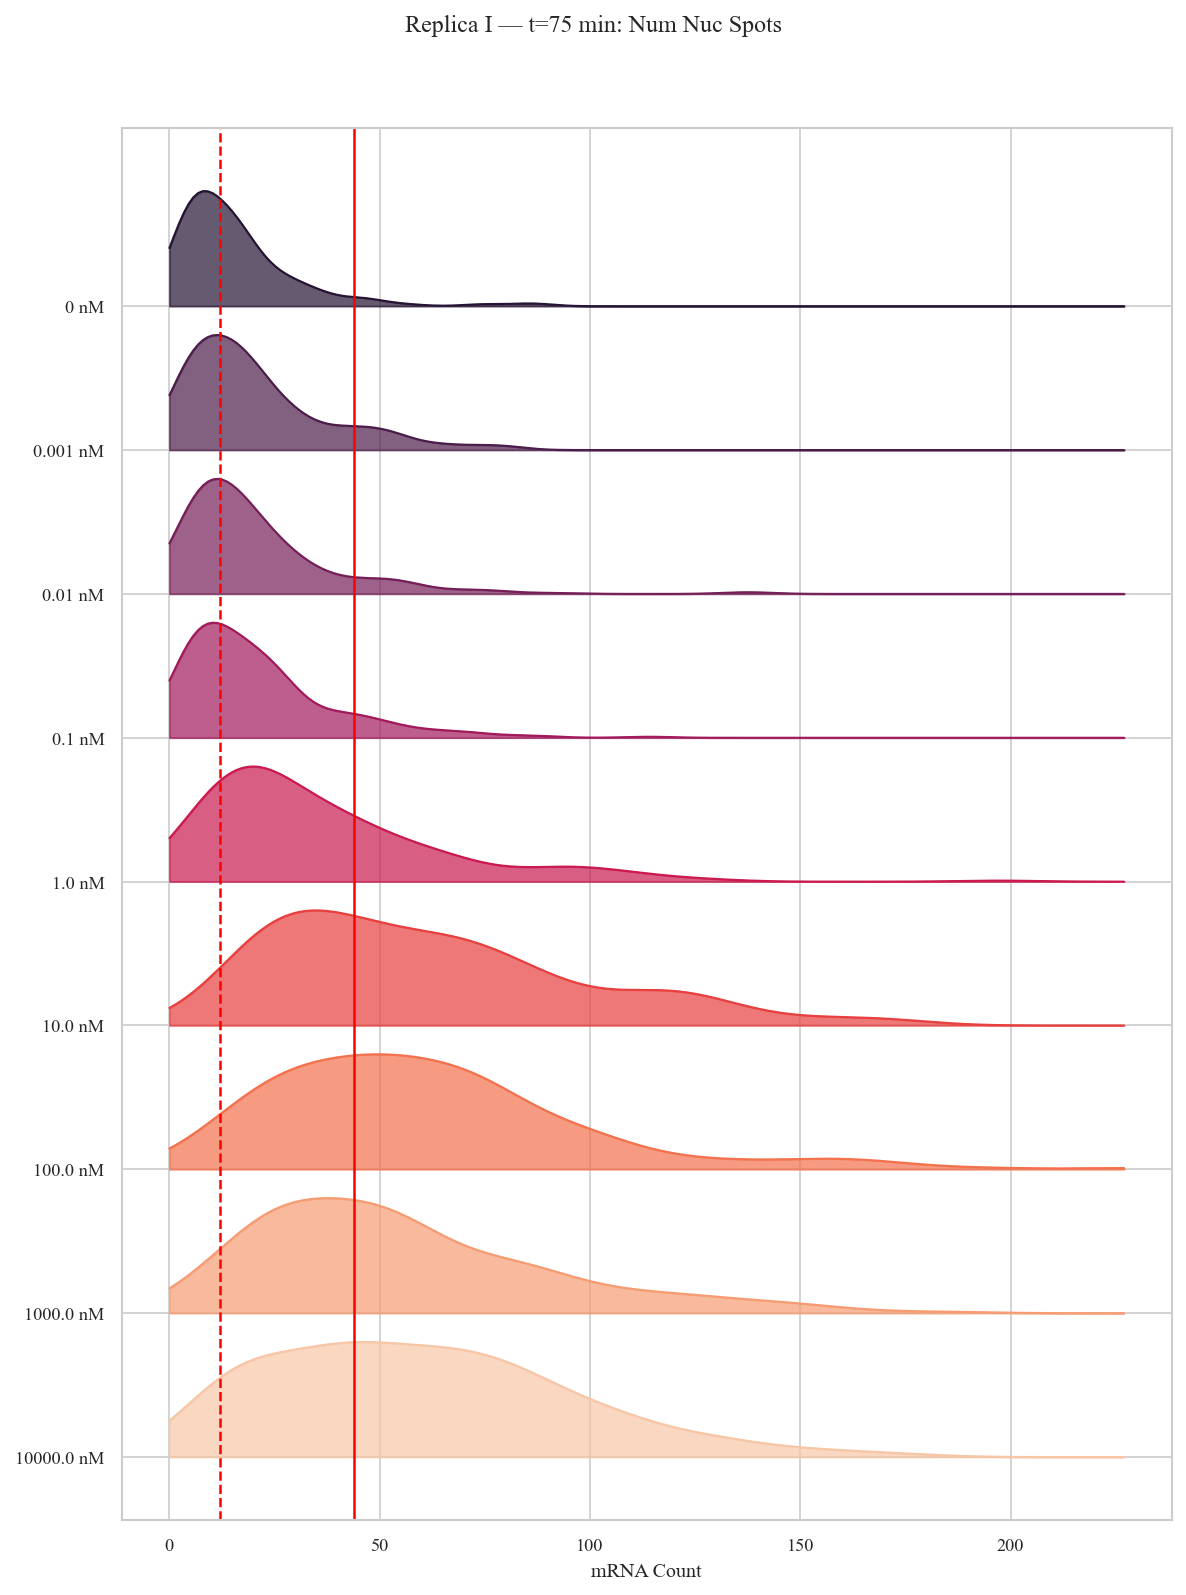

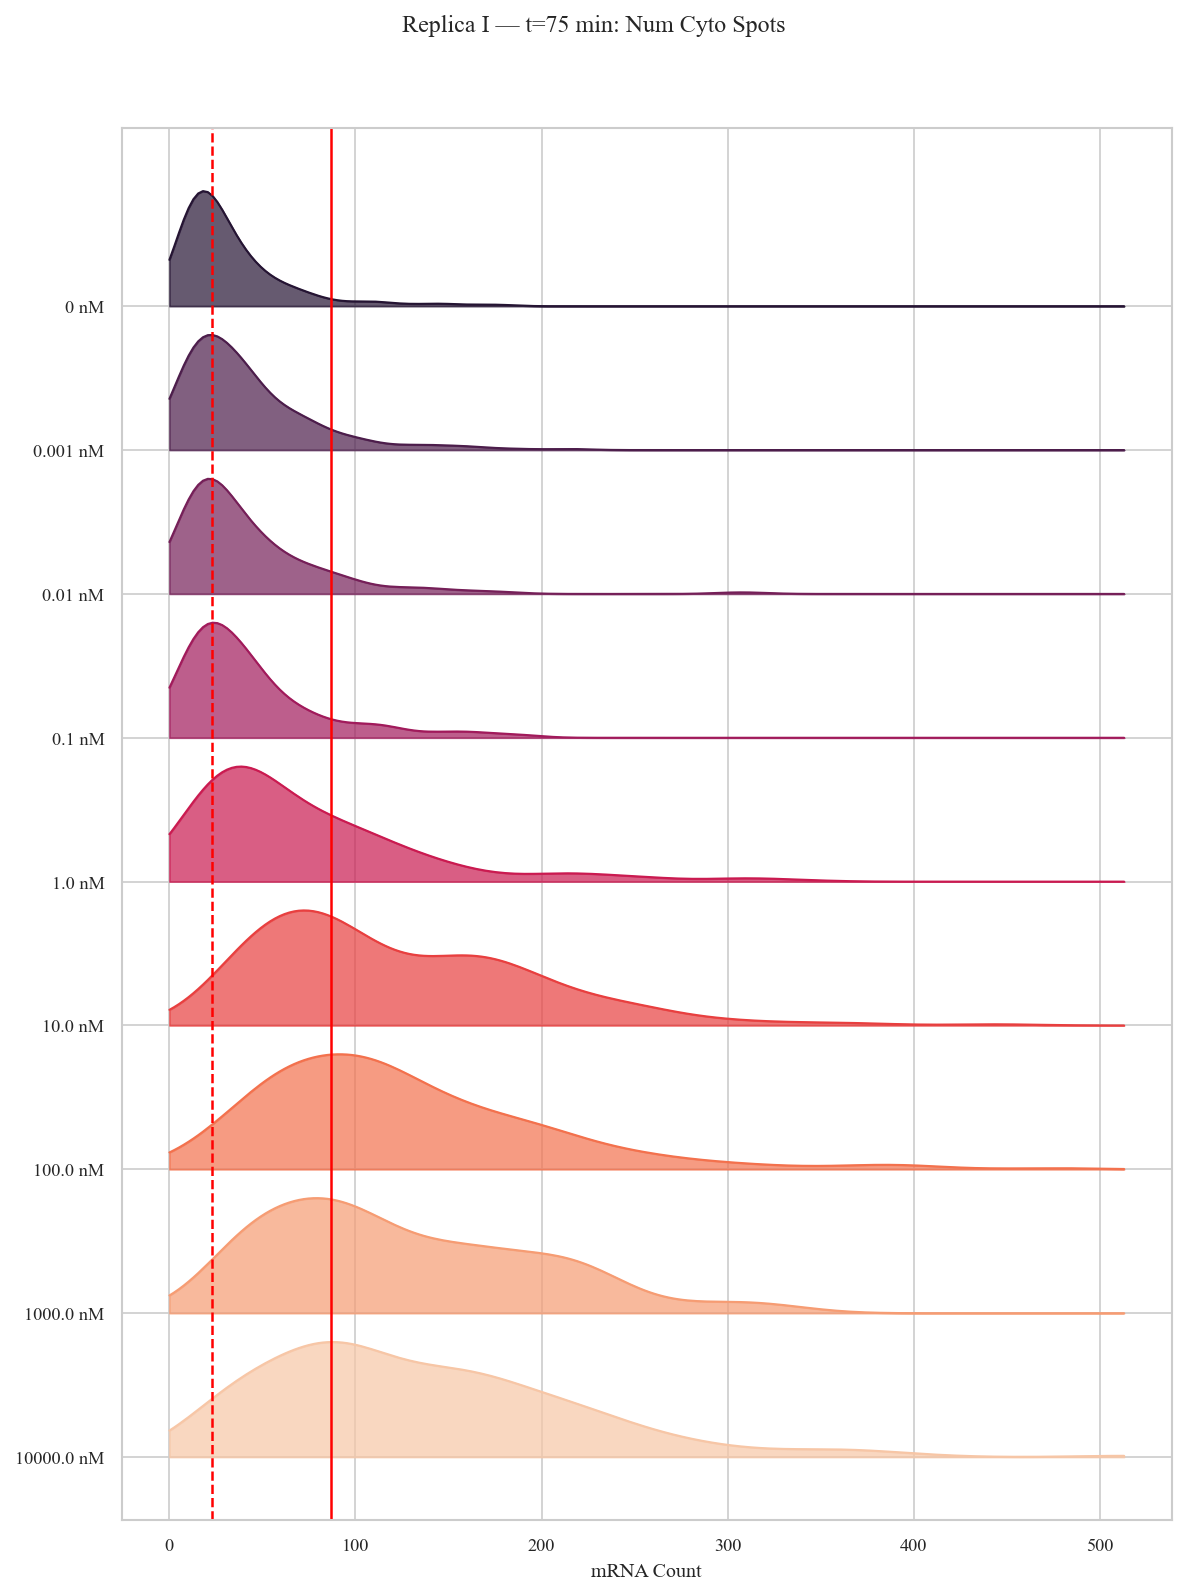

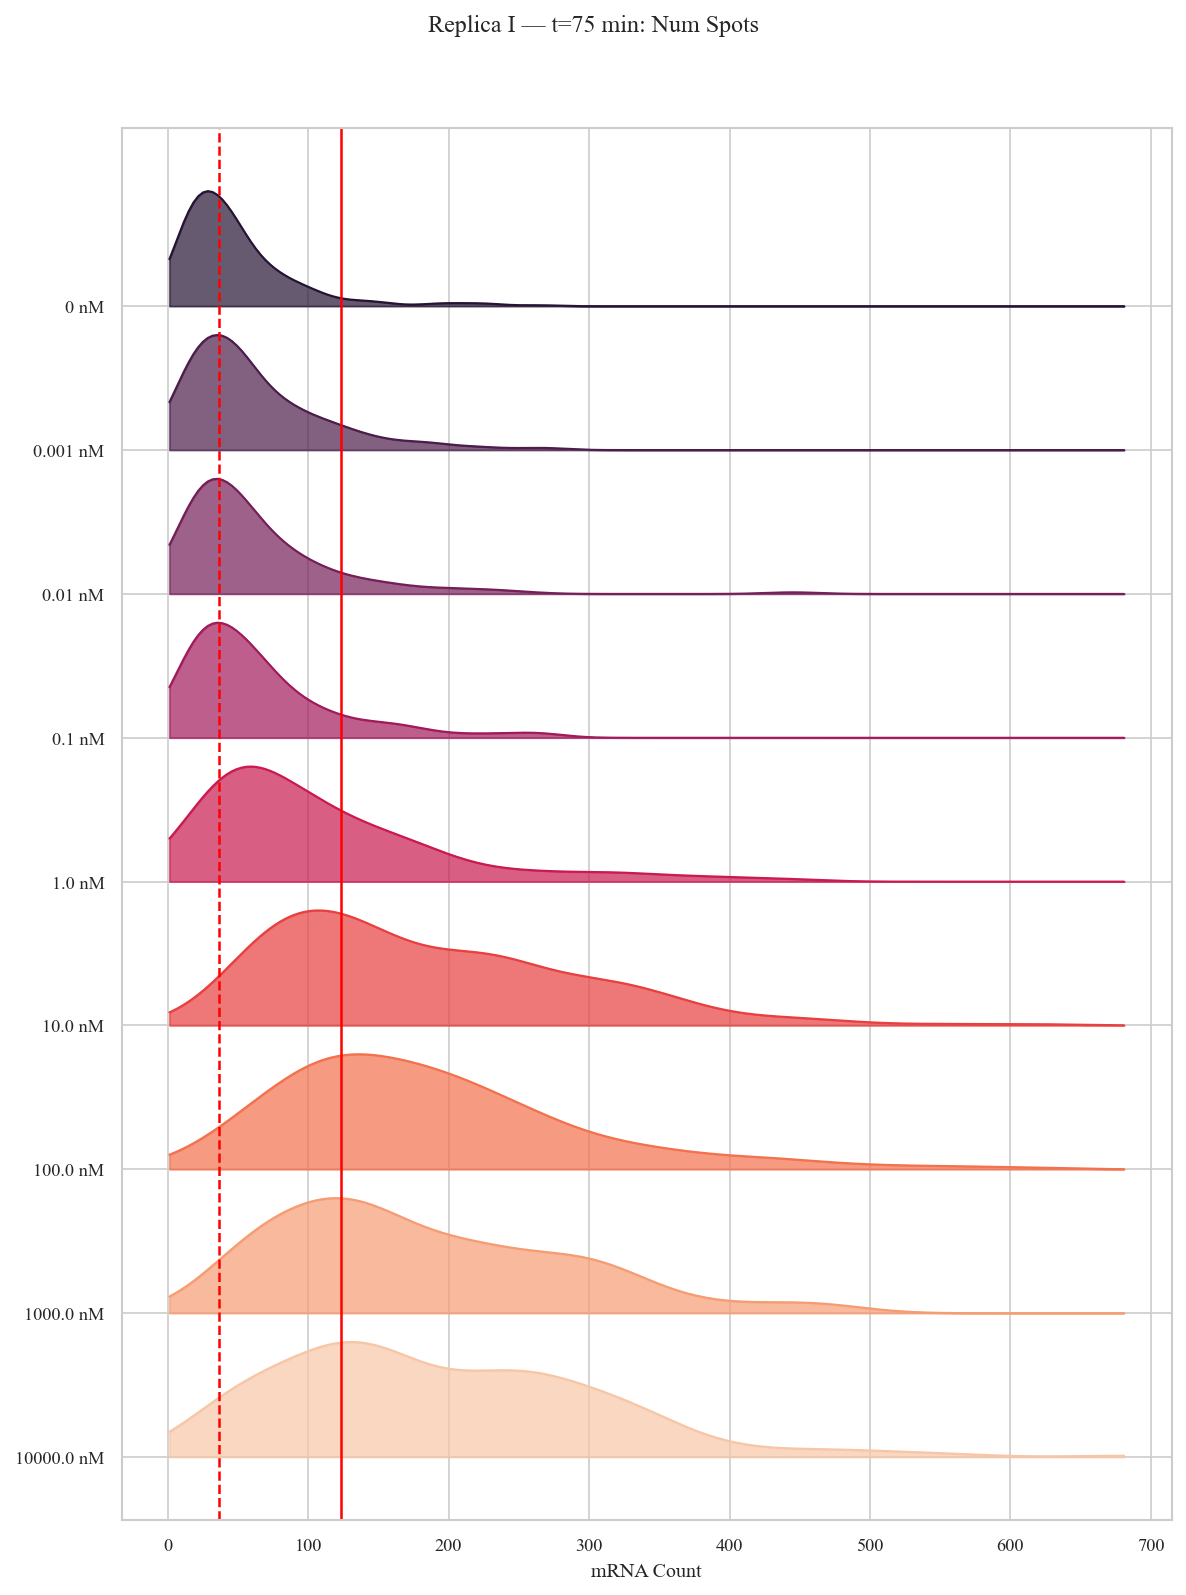

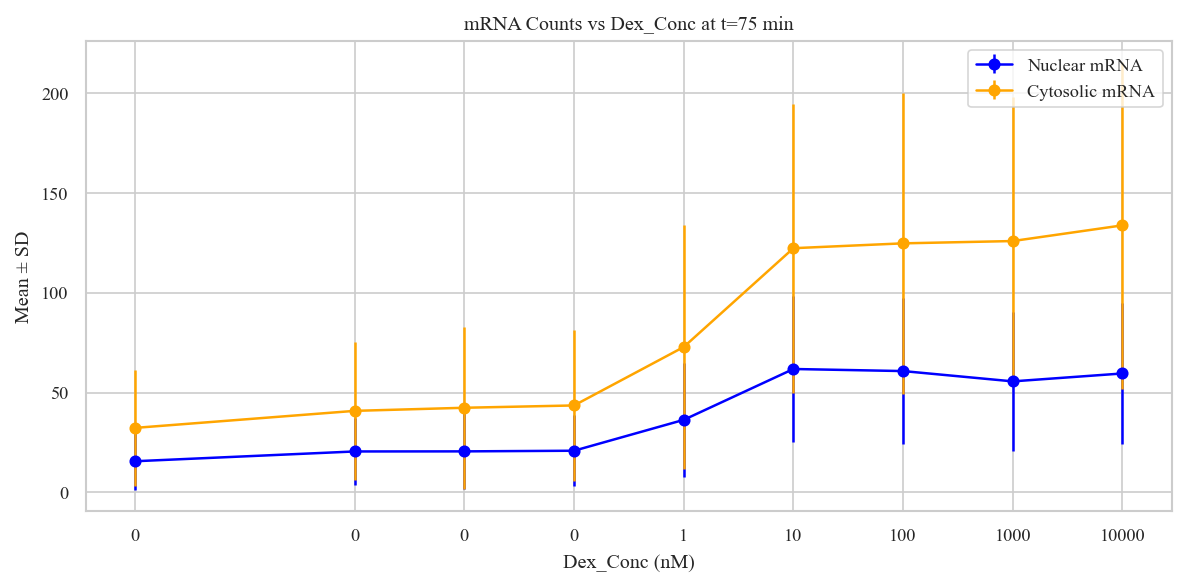

In [13]:
# 1. Create an instance of the DUSP1AnalysisManager class.
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_I_Final')

# Load the datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print(f"Data loaded and moving to SNRAnalysis...")
# 2. Create an instance of the SNRAnalysis class.
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

print(f"SNR analysis complete, data merged and moving to DUSP1Measurement...")
# 3. Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '80' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 120
prefix = rep_prefix * (10 ** num_digits) 

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save the intermediate results
rep_string = 'DUSP1_I'
# intermediate_dir = save_dir
# os.makedirs(intermediate_dir, exist_ok=True)
# cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# # cell_level_results.to_csv(os.path.join(intermediate_dir, f"{rep_string}_cellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_spots_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Spots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_clusters_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_Clusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# # merged_cellprops_df.to_csv(os.path.join(intermediate_dir, f"{rep_string}_CellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# print(f"Intermediate results saved, moving to filtering...")

# Initialize filtering object
filterer = DUSP1_filtering(method=method, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Apply filtering and measurement
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = filterer.apply_all(
    spots=merged_spots_df,
    clusters=merged_clusters_df,
    cellprops=merged_cellprops_df
)

print(f"Filtering complete, saving results...")
# Save all results to CSV
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}.csv"), index=False)
# SSITcellresults.to_csv(os.path.join(output_dir, f"{rep_string}_SSITcellresults_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_spots.to_csv(os.path.join(output_dir, f"{rep_string}_FinalSpots_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{rep_string}_FinalClusters_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{rep_string}_FinalCellProps_MG{mg_threshold}_{date_str}_{method}.csv"), index=False)

# print(f"Results saved, moving to display...")
# # 4. Create an instance of the DUSP1DisplayManager class.
# display_manager = DUSP1DisplayManager(am, 
#                                       cell_level_results=SSITcellresults,
#                                       spots=filtered_spots,
#                                       clusters=filtered_clusters,
#                                       cellprops=filtered_cellprops,
#                                       removed_spots=removed_spots)
# # Run the main display function.
# display_manager.main_display()

# 5. Create an instance of the PostProcessingDisplay class.
post_processing_display = PostProcessingDisplay(spots_df=filtered_spots,
                                                clusters_df=filtered_clusters,
                                                cellprops_df=filtered_cellprops,
                                                ssit_cellresults_df= SSITcellresults)
# Run the post-processing display function.
post_processing_display.display_overview_plots(mode='conc', save_dir=save_dir)

# DUSP1 Concatination and Replica Checks

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1) SETUP ────────────────────────────────────────────────────────────────────
base_dir = "/Volumes/share/Users/Eric/GR_DUSP1_AllData/DUSP1_AllAnalysis_061125"

def get_replica(fname):
    """
    Given a filename like "DUSP1_D_FinalCellProps_…", returns the letter ("D", "E", etc.).
    We split on underscores and take position 1.
    """
    return os.path.basename(fname).split("_")[1]

def normalize_dex_col(df):
    """
    Find any column whose lowercase is "dex_conc" and rename it to "dex_conc" (all lowercase).
    If no such column exists, return df unchanged.
    """
    for c in df.columns:
        if c.lower() == "dex_conc":
            return df.rename(columns={c: "dex_conc"})
    return df

# ── 2) LOAD ALL CSVs ─────────────────────────────────────────────────────────────

# 2a) SSITcellresults
ssit_paths = glob.glob(os.path.join(base_dir, "*_SSITcellresults_*.csv"))
ssit_list = []
for path in ssit_paths:
    rep = get_replica(path)
    df = pd.read_csv(path)
    df["replica"] = rep
    df = normalize_dex_col(df)
    ssit_list.append(df)
ssit_all = pd.concat(ssit_list, ignore_index=True)

# 2b) FinalClusters
cluster_paths = glob.glob(os.path.join(base_dir, "*_FinalClusters_*.csv"))
cluster_list = []
for path in cluster_paths:
    rep = get_replica(path)
    df = pd.read_csv(path)
    df["replica"] = rep
    df = normalize_dex_col(df)
    cluster_list.append(df)
clusters_all = pd.concat(cluster_list, ignore_index=True)

# 2c) FinalCellProps
cellprop_paths = glob.glob(os.path.join(base_dir, "*_FinalCellProps_*.csv"))
cellprop_list = []
for path in cellprop_paths:
    rep = get_replica(path)
    df = pd.read_csv(path)
    df["replica"] = rep
    df = normalize_dex_col(df)
    cellprop_list.append(df)
cellprops_all = pd.concat(cellprop_list, ignore_index=True)

# ── 3) TS FRACTION CALCULATION ───────────────────────────────────────────────────

# Keep only nuclear TS (is_nuc == 1)
ts_nuc = clusters_all[clusters_all["is_nuc"] == 1]

# Count TS per cell (group by replica, dex_conc, time, h5_idx, fov, cell_label)
ts_count = (
    ts_nuc
    .groupby(["replica", "dex_conc", "time", "h5_idx", "fov", "cell_label"])
    .size()
    .reset_index(name="ts_count")
)

# All cells with replica, dex_conc, time, h5_idx, fov, cell_label
all_cells = (
    cellprops_all[["replica", "dex_conc", "time", "h5_idx", "fov", "cell_label"]]
    .drop_duplicates()
)

# Merge TS counts onto all_cells; missing TS → ts_count = 0
merged = pd.merge(
    all_cells,
    ts_count,
    on=["replica", "dex_conc", "time", "h5_idx", "fov", "cell_label"],
    how="left"
).fillna({"ts_count": 0})

# Binary flag: has_ts = 1 if ts_count ≥ 1
merged["has_ts"] = (merged["ts_count"] >= 1).astype(int)

# 3a) Fraction per replica × dex_conc × time
frac_per_rep = (
    merged
    .groupby(["replica", "dex_conc", "time"])
    .agg(fraction=("has_ts", "mean"))
    .reset_index()
)

# 3b) Mean ± SD of those fractions across replicas
frac_stats = (
    frac_per_rep
    .groupby(["dex_conc", "time"])
    .agg(mean_frac=("fraction", "mean"),
         sd_frac  =("fraction", "std"))
    .reset_index()
)

# 3c) Overall (all cells pooled) mean ± SD at each dex_conc × time
overall_stats = (
    merged
    .groupby(["dex_conc", "time"])
    .agg(mean_overall=("has_ts", "mean"),
         sd_overall  =("has_ts", "std"))
    .reset_index()
)

# Merge per‐replica stats with overall stats
combined_stats = pd.merge(
    frac_stats,
    overall_stats,
    on=["dex_conc", "time"],
    how="left"
)

# ── 4) PLOT TS FRACTION OVER TIME (include 0 min control on each curve) ─────────
sns.set_theme(style="whitegrid", context="paper")
concs = sorted(combined_stats["dex_conc"].unique())

for conc in concs:
    if conc == 0:
        continue

    # 1) Fetch the control row (dex_conc=0, time=0)
    ctrl_row = combined_stats[
        (combined_stats["dex_conc"] == 0) & (combined_stats["time"] == 0)
    ].iloc[0]

    # 2) Stats for this concentration
    subset = combined_stats[combined_stats["dex_conc"] == conc].copy()

    # 3) Build a “control” row labeled at this conc, time=0
    control_for_conc = {
        "dex_conc":      conc,
        "time":          0,
        "mean_frac":     ctrl_row["mean_frac"],
        "sd_frac":       ctrl_row["sd_frac"],
        "mean_overall":  ctrl_row["mean_overall"],
        "sd_overall":    ctrl_row["sd_overall"]
    }
    control_df = pd.DataFrame([control_for_conc])
    subset = pd.concat([subset, control_df], ignore_index=True)

    # 4) Sort by time so that 0 min is first
    subset = subset.sort_values("time")

    # 5) Plot shaded “overall ± SD” and error‐bar “mean_frac ± sd_frac”
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.fill_between(
        subset["time"],
        subset["mean_overall"] - subset["sd_overall"],
        subset["mean_overall"] + subset["sd_overall"],
        color="lightgray",
        alpha=0.5,
        label="Overall (all‐cells) ± SD"
    )
    ax.errorbar(
        subset["time"],
        subset["mean_frac"],
        yerr=subset["sd_frac"],
        fmt="-o",
        capsize=5,
        color="purple",
        label="Mean(replica) ± SD(replica)"
    )

    ax.set_title(f"{conc} nM Dex: Fraction of Cells with ≥1 TS Over Time")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Fraction of Cells")
    ax.set_ylim(0, 1)
    ax.set_xticks(subset["time"].values)
    ax.legend()
    plt.tight_layout()

    # — Save this figure to base_dir —
    filename = f"TS_fraction_{int(conc*1000)}pM_{conc}_nM.png"
    # e.g., if conc=0.3 → "TS_fraction_300pM_0.3_nM.png"
    fig.savefig(os.path.join(base_dir, filename), dpi=150)
    plt.close(fig)


# ── 5) JOY (RIDGE) PLOTS FOR mRNA DISTRIBUTIONS (with CDF lines) ───────────────────
metrics = ["num_nuc_spots", "num_cyto_spots", "num_spots"]
axis_limits = {
    "num_nuc_spots": (0, 500),
    "num_cyto_spots": (0, 500),
    "num_spots": (0, 1000),
}

# Precompute CDF thresholds (median & 95th) on the control (dex_conc=0, time=0)
cdf_thr = {}
for m in metrics:
    control_vals = ssit_all[
        (ssit_all["dex_conc"] == 0) & (ssit_all["time"] == 0)
    ][m].dropna().values

    # Optional sanity check for negatives:
    print(f"METRIC {m}: control min = {control_vals.min() if len(control_vals)>0 else 'N/A'}, "
          f"control max = {control_vals.max() if len(control_vals)>0 else 'N/A'}")

    if len(control_vals) > 0:
        sorted_vals = np.sort(control_vals)
        cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        cdf_thr[m] = (
            np.interp(0.50, cdf, sorted_vals),   # median
            np.interp(0.95, cdf, sorted_vals)    # 95th percentile
        )
    else:
        cdf_thr[m] = (None, None)

for conc in sorted(ssit_all["dex_conc"].unique()):
    if conc == 0:
        continue

    df_conc = ssit_all[ssit_all["dex_conc"] == conc]
    times = [0] + sorted(df_conc["time"].unique().tolist())

    for m in metrics:
        # (Optional) Check data range at each conc:
        all_vals = np.concatenate([
            ssit_all[(ssit_all["dex_conc"] == 0) & (ssit_all["time"] == 0)][m].dropna().values,
            df_conc[m].dropna().values
        ])
        print(f"For conc={conc} nM, metric={m}: data min={all_vals.min()}, data max={all_vals.max()}")

        fig, ax = plt.subplots(figsize=(8, len(times) * 1.2))
        fig.suptitle(f"{conc} nM Dex: {m.replace('_',' ').title()} (All Replicas)", fontsize=14)

        # Use rocket_r colormap for ridge plots
        bins = np.linspace(axis_limits[m][0], axis_limits[m][1], 30)
        cmap = sns.color_palette("rocket_r", n_colors=len(times))[::-1]

        for i, t in enumerate(times):
            if t == 0:
                data = ssit_all[(ssit_all["dex_conc"] == 0) & (ssit_all["time"] == 0)][m]
            else:
                data = df_conc[df_conc["time"] == t][m]

            hist, edges = np.histogram(data.dropna(), bins=bins, density=True)
            xs = (edges[:-1] + edges[1:]) / 2
            if hist.max() > 0:
                heights = hist / hist.max() * 0.8
            else:
                heights = np.zeros_like(xs)
            y_off = len(times) - 1 - i

            ax.fill_between(xs, y_off, y_off + heights, color=cmap[i], alpha=0.7)

        # Overlay CDF threshold lines
        lo, hi = cdf_thr[m]
        if lo is not None and hi is not None:
            ax.axvline(lo, color='red', linestyle='--', linewidth=1, label="Median (control)")
            ax.axvline(hi, color='red', linestyle='-', linewidth=1, label="95th pct (control)")

        # Force X‐axis to [0, axis_limits[m][1]] so nothing appears < 0
        ax.set_xlim(axis_limits[m][0], axis_limits[m][1])

        ax.set_yticks([len(times) - 1 - i for i in range(len(times))])
        ax.set_yticklabels([f"{t} min" for t in times])
        ax.set_xlabel("mRNA Count")
        # Only add legend once per plot (avoid duplicate entries)
        if lo is not None:
            ax.legend(loc="upper right")
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # — Save this ridge plot to base_dir —
        filename = f"joy_{int(conc*1000)}pM_{conc}nM_{m}.png"
        # e.g., "joy_300pM_0.3nM_num_nuc_spots.png"
        fig.savefig(os.path.join(base_dir, filename), dpi=150)
        plt.close(fig)


# ── 6) LINE PLOTS FOR NUCLEAR & CYTOPLASMIC mRNA COUNTS ─────────────────────────────
# Include 0 min control on each concentration's curve
for m in ["num_nuc_spots", "num_cyto_spots"]:
    for conc in sorted(ssit_all["dex_conc"].unique()):
        if conc == 0:
            continue

        # Build a DataFrame that includes both this concentration’s cells and the control cells at time=0
        df_conc = ssit_all[(ssit_all["dex_conc"] == conc)]
        df_control = ssit_all[(ssit_all["dex_conc"] == 0) & (ssit_all["time"] == 0)]
        df_combined = pd.concat([df_conc, df_control], ignore_index=True)

        # 6a) Per‐replica mean for each time (including control)
        rep_means = (
            df_combined
            .groupby(["replica", "time"])
            .agg(mean_val=(m, "mean"))
            .reset_index()
        )
        rep_stats = (
            rep_means
            .groupby("time")
            .agg(mean_of_means=("mean_val", "mean"),
                 sd_of_means=("mean_val", "std"))
            .reset_index()
        )

        # 6b) Overall (all‐cells combined) mean ± SD at each time (including control)
        overall = (
            df_combined
            .groupby("time")
            .agg(mean_overall=(m, "mean"),
                 sd_overall=(m, "std"))
            .reset_index()
        )

        merged_stats = pd.merge(rep_stats, overall, on="time", how="left")
        merged_stats = merged_stats.sort_values("time")

        fig, ax = plt.subplots(figsize=(8, 4))

        # Shaded: overall ± SD
        ax.fill_between(
            merged_stats["time"],
            merged_stats["mean_overall"] - merged_stats["sd_overall"],
            merged_stats["mean_overall"] + merged_stats["sd_overall"],
            color="lightgray",
            alpha=0.5,
            label="Overall (all‐cells) ± SD"
        )

        # Errorbar: mean(replica‐means) ± SD(replica‐means)
        ax.errorbar(
            merged_stats["time"],
            merged_stats["mean_of_means"],
            yerr=merged_stats["sd_of_means"],
            fmt="-o",
            capsize=5,
            color="green",
            label="Mean(replica) ± SD(replica)"
        )

        ax.set_title(f"{conc} nM Dex: {m.replace('_', ' ').title()} Over Time")
        ax.set_xlabel("Time (min)")
        ax.set_ylabel("Count")
        ax.set_xticks(merged_stats["time"].values)
        ax.legend()
        plt.tight_layout()

        # — Save this line plot to base_dir —
        filename = f"line_{int(conc*1000)}pM_{conc}nM_{m}.png"
        # e.g., "line_300pM_0.3nM_num_nuc_spots.png"
        fig.savefig(os.path.join(base_dir, filename), dpi=150)
        plt.close(fig)